Sara Mancini - 66458A <h1> [P4] Wavelet-based ECG delineation for SVT </h1> Biomedical Signals 2025/26

### dep install

In [1]:
!pip install wfdb PyWavelets numpy scipy matplotlib wget

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=181e7bd2313d146531fa276bc69b035416f036821819784b0d9a9f3d7cf7c093
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


### data dl

#### dataset 1: PTB-XL

preemptivly "scouting" patients to save time

In [ ]:
import os
import wget

# paths
base_url = "https://physionet.org/files/ptb-xl/1.0.3/"
local_path = "ptbxl_data/"
os.makedirs(local_path, exist_ok=True)

# download metadata csvs
for csv_file in ["ptbxl_database.csv", "scp_statements.csv"]:
    url = base_url + csv_file
    print(f"downloading {csv_file}...")
    wget.download(url, out=os.path.join(local_path, csv_file))
print("\nmetadata downloaded")

downloading ptbxl_database.csv...
downloading scp_statements.csv...

metadata downloaded


In [ ]:
import pandas as pd
import ast

# load metadata csv
csv_file = os.path.join(local_path, "ptbxl_database.csv")
df = pd.read_csv(csv_file, index_col="ecg_id")

# parse scp_codes column
df["scp_codes"] = df["scp_codes"].apply(ast.literal_eval)

# svt-related keywords mapping
svt_categories = {
    "PSVT": "Paroxysmal Supraventricular Tachycardia",
    "SVTAC": "Atrial Tachycardia",
    "AFLT": "Atrial Flutter",
    "AFIB": "Atrial Fibrillation",
    "STACH": "Sinus Tachycardia",
    "PAC": "Atrial Premature Complex "
}

# get only positive codes and map to category
def get_positive_categories(code_dict):
    result = {}
    for code, value in code_dict.items():
        if code in svt_categories and value > 0:
            result[svt_categories[code]] = value
    return result

# filter df for any record with >0 svt-related code
df_svt = df[df["scp_codes"].apply(lambda d: any(code in svt_categories and v>0 for code,v in d.items()))]
print("Number of records with SVT-related codes:", len(df_svt))

# dict to store ids per category
category_ids = {cat: [] for cat in svt_categories.values()}

for ecg_id, row in df_svt.iterrows():
    positive = get_positive_categories(row["scp_codes"])
    for cat in positive.keys():
        category_ids[cat].append(ecg_id)

for cat, ids in category_ids.items():
    print(f"\n{cat}: {len(ids)} records ")
    print(ids)

# combine all svt-related ids into one list
recordings_ids = []
for ids in category_ids.values():
    recordings_ids.extend(ids)

Number of records with SVT-related codes: 169

Paroxysmal Supraventricular Tachycardia: 24 records 
[1299, 1919, 2051, 3134, 3267, 3476, 6822, 7889, 8461, 9866, 10306, 12346, 12489, 12537, 13155, 13186, 14286, 14780, 15253, 16106, 16229, 16753, 19540, 21410]

Atrial Tachycardia: 0 records 
[]

Atrial Flutter: 56 records 
[17, 18, 20, 23, 34, 449, 858, 1173, 1773, 2430, 2739, 3306, 4874, 5252, 5390, 6179, 6205, 7159, 7412, 7462, 7512, 7567, 7796, 8265, 8476, 10065, 10160, 10564, 10900, 10913, 10933, 10943, 10986, 11343, 11886, 12891, 12986, 13386, 13987, 14070, 14083, 15106, 15478, 15513, 16401, 17049, 17067, 17080, 17096, 17106, 17119, 19170, 19896, 19961, 20085, 21006]

Atrial Fibrillation: 48 records 
[351, 4117, 4401, 4423, 4531, 4532, 4761, 5634, 5776, 7215, 7221, 7489, 8215, 9592, 10723, 11510, 12369, 12542, 12602, 12632, 12847, 12879, 12948, 13199, 13742, 13832, 14102, 14221, 14792, 14824, 14862, 15039, 15834, 16731, 16834, 17386, 17457, 18485, 18928, 18966, 19667, 19925, 19941, 

In [ ]:
len_svt = len(recordings_ids)

# strict normal detection
def is_strict_normal(code_dict):
    return (
        set(code_dict.keys()) == {"NORM", "SR"}
        and code_dict.get("NORM", 0) == 100.0
        and code_dict.get("SR", None) == 0.0
    )

# filter by scp_codes
df_norm = df[df["scp_codes"].apply(is_strict_normal)]

# filter further for those whose report contains "sinusrhythmus normales ekg"
df_norm = df_norm[
    df_norm["report"].fillna("").str.lower().str.contains("sinusrhythmus normales ekg")
]

print("Number of total strictly normal ecgs:", len(df_norm))

# same number as svt group
normal_ids = df_norm.index.tolist()[:len_svt]

print("\nSelected Normal:", len_svt,"records")
print(normal_ids)

# append to final dataset
recordings_ids.extend(normal_ids)

Number of total strictly normal ecgs: 689

Selected Normal: 169 records
[3, 4, 5, 6, 9, 10, 13, 14, 16, 21, 24, 25, 29, 31, 33, 35, 36, 42, 43, 46, 47, 51, 53, 55, 56, 57, 58, 59, 61, 66, 67, 70, 71, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 99, 104, 109, 110, 111, 113, 114, 115, 117, 120, 121, 123, 124, 125, 126, 129, 147, 165, 174, 178, 183, 193, 196, 197, 198, 200, 201, 202, 203, 204, 206, 208, 221, 224, 227, 229, 230, 231, 239, 241, 244, 248, 252, 353, 354, 355, 356, 358, 359, 361, 364, 365, 366, 368, 370, 371, 372, 373, 374, 375, 376, 379, 387, 389, 391, 392, 393, 395, 397, 398, 401, 403, 406, 431, 432, 434, 435, 438, 451, 490, 506, 533, 580, 582, 587, 590, 638, 644, 662, 729, 753, 773, 776, 777, 779, 783, 784, 787, 790, 792, 793, 797, 808, 813, 815, 904, 905, 935, 958, 1018, 1054, 1190, 1230, 1247, 1254, 1257, 1259, 1263]


high-res data dl <small> <i> still takes abt 5 mins </i> </small>

In [ ]:
# download the .dat and .hea files from records500
for ecg_id in recordings_ids:
    # folder is based on thousands
    folder = f"{ecg_id//1000*1000:05d}"
    for ext in [".dat", ".hea"]:
        filename = f"{ecg_id:05d}_hr{ext}"
        url = f"{base_url}records500/{folder}/{filename}"
        out_file = os.path.join(local_path, filename)
        try:
            print(f"downloading {filename}...")
            wget.download(url, out=out_file)
        except Exception as e:
            print(f"\n could not download {filename}: {e}")

print("\nall files downloaded")

downloading 01299_hr.dat...
downloading 01299_hr.hea...
downloading 01919_hr.dat...
downloading 01919_hr.hea...
downloading 02051_hr.dat...
downloading 02051_hr.hea...
downloading 03134_hr.dat...
downloading 03134_hr.hea...
downloading 03267_hr.dat...
downloading 03267_hr.hea...
downloading 03476_hr.dat...
downloading 03476_hr.hea...
downloading 06822_hr.dat...
downloading 06822_hr.hea...
downloading 07889_hr.dat...
downloading 07889_hr.hea...
downloading 08461_hr.dat...
downloading 08461_hr.hea...
downloading 09866_hr.dat...
downloading 09866_hr.hea...
downloading 10306_hr.dat...
downloading 10306_hr.hea...
downloading 12346_hr.dat...
downloading 12346_hr.hea...
downloading 12489_hr.dat...
downloading 12489_hr.hea...
downloading 12537_hr.dat...
downloading 12537_hr.hea...
downloading 13155_hr.dat...
downloading 13155_hr.hea...
downloading 13186_hr.dat...
downloading 13186_hr.hea...
downloading 14286_hr.dat...
downloading 14286_hr.hea...
downloading 14780_hr.dat...
downloading 14780_hr

#### dataset2: LUDB

scouting relevant patients again

In [2]:
import os
import wget

# paths
base_url = "https://physionet.org/files/ludb/1.0.1/"
local_path = "ludb_data/"
os.makedirs(local_path, exist_ok=True)

files = ["ludb.csv"]

for fname in files:
    # force raw file bc it kept downloading html
    url = base_url + fname + "?download=1"
    print(f"downloading {fname}...")
    wget.download(url, out=os.path.join(local_path, fname))

print("\nmetadata downloaded")

downloading ludb.csv...

metadata downloaded


In [3]:
import pandas as pd

csv_file2 = os.path.join(local_path, "ludb.csv")
df2 = pd.read_csv(csv_file2)

# normalize for searching
df2["Rhythms_norm"] = df2["Rhythms"].str.lower()
df2["Extrasystolies_norm"] = df2["Extrasystolies"].astype(str).str.lower()

# svt rhythms
svt_rhythms2 = {
    "Atrial fibrillation": "atrial fibrillation",
    "Atrial flutter": "atrial flutter, typical",
    "Sinus tachycardia": "sinus tachycardia"
}

# mask for each svt rhythm
svt_masks = {name: df2["Rhythms_norm"] == pattern
             for name, pattern in svt_rhythms2.items()}

# extrasystole mask
extras_mask = df2["Extrasystolies_norm"].str.contains("atrial extrasystole|pac|atrial extrasystole,|atrial extrasystole:", na=False)

# collect id lists
svt_ids = {name: df2.loc[mask, "ID"].tolist()
           for name, mask in svt_masks.items()}

extras_ids = df2.loc[extras_mask, "ID"].tolist()

print("SVT rhythm IDs")
for name, ids in svt_ids.items():
    print(f"{name}: {ids}")

print("\nPAC IDs")
print(extras_ids)

# flatten svt dict values into a single list
svt_all_ids = []
for lst in svt_ids.values():
    svt_all_ids.extend(lst)

# concatenate with extrasystole ids
recordings_ids2 = svt_all_ids + extras_ids


SVT rhythm IDs
Atrial fibrillation: [8, 38, 44, 51, 83, 88, 93, 95, 96, 101, 110, 112, 129, 173]
Atrial flutter: [35, 52, 103]
Sinus tachycardia: [70, 114, 117, 188]

PAC IDs
[7, 22, 60, 66, 78, 108, 132]


In [4]:
# find norm recordings
normal_mask_rhythm = df2["Rhythms_norm"] == "sinus rhythm"

# all other diagnostic fields must be empty except electric axis
other_fields = [
    "Extrasystolies",
    "Conduction abnormalities",
    "Hypertrophies",
    "Cardiac pacing",
    "Ischemia",
    "Non-specific repolarization abnormalities",
    "Other states"
]

# check they are empty or none
empty_other_fields_mask = df2[other_fields].isna() | (df2[other_fields] == "")
empty_other_fields_mask = empty_other_fields_mask.all(axis=1)

# sinus rhythm + all other fields empty
normal_mask = normal_mask_rhythm & empty_other_fields_mask

# extract ids
normal_ids = df2.loc[normal_mask, "ID"].tolist()

print("Number of normal recordings:", len(normal_ids))
print("\nNormal recording IDs:")
print(normal_ids)

# append to existing list
recordings_ids2 = recordings_ids2 + normal_ids

Number of normal recordings: 23

Normal recording IDs:
[56, 58, 62, 119, 123, 135, 142, 149, 152, 154, 157, 161, 162, 166, 168, 177, 187, 190, 193, 194, 195, 198, 199]


data dl <small> (abt 2-4 mins) </small>

In [5]:
base_url = "https://physionet.org/files/ludb/1.0.1/data/"
os.makedirs(local_path, exist_ok=True)

# download the .dat and .hea and all .leads (annots)
lead_exts = [
    ".dat", ".hea",
    ".avf", ".avl", ".avr",
    ".i", ".ii", ".iii",
    ".v1", ".v2", ".v3", ".v4", ".v5", ".v6"
]

for rid in recordings_ids2:
    for ext in lead_exts:
        fname = f"{rid}{ext}"
        url = base_url + fname
        out_file = os.path.join(local_path, fname)

        try:
            print(f"downloading {fname} ...")
            wget.download(url, out=out_file)
        except Exception as e:
            print(f"\ncould not download {fname}: {e}")

print("\nall files downloaded")

downloading 8.dat ...
downloading 8.hea ...
downloading 8.avf ...
downloading 8.avl ...
downloading 8.avr ...
downloading 8.i ...
downloading 8.ii ...
downloading 8.iii ...
downloading 8.v1 ...
downloading 8.v2 ...
downloading 8.v3 ...
downloading 8.v4 ...
downloading 8.v5 ...
downloading 8.v6 ...
downloading 38.dat ...
downloading 38.hea ...
downloading 38.avf ...
downloading 38.avl ...
downloading 38.avr ...
downloading 38.i ...
downloading 38.ii ...
downloading 38.iii ...
downloading 38.v1 ...
downloading 38.v2 ...
downloading 38.v3 ...
downloading 38.v4 ...
downloading 38.v5 ...
downloading 38.v6 ...
downloading 44.dat ...
downloading 44.hea ...
downloading 44.avf ...
downloading 44.avl ...
downloading 44.avr ...
downloading 44.i ...
downloading 44.ii ...
downloading 44.iii ...
downloading 44.v1 ...
downloading 44.v2 ...
downloading 44.v3 ...
downloading 44.v4 ...
downloading 44.v5 ...
downloading 44.v6 ...
downloading 51.dat ...
downloading 51.hea ...
downloading 51.avf ...
downlo

### data inspection + plots

annotation format

In [ ]:
import wfdb

ann = wfdb.rdann("ludb_data/7", "ii")
print("samples:", ann.sample)
print("symbols:", ann.symbol)
print("aux:", ann.aux_note)

samples: [ 962  977  996 1028 1108 1151 1396 1425 1447 1466 1480 1498 1547 1610
 1650 1693 1717 1747 1759 1774 1793 1836 1905 1946 2260 2293 2317 2333
 2348 2371 2404 2486 2520 2773 2802 2827 2840 2856 2874 2917 2988 3025
 3276 3302 3326 3344 3357 3377 3430 3488 3527 3775 3804 3827 3843 3859
 3880 3934 3994 4030 4271 4297 4327 4337 4352 4370]
symbols: ['(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')', '(', 't', ')', '(', 'p', ')', '(', 'N', ')']
aux: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


representative examples plots for pres (not actual algo applied)

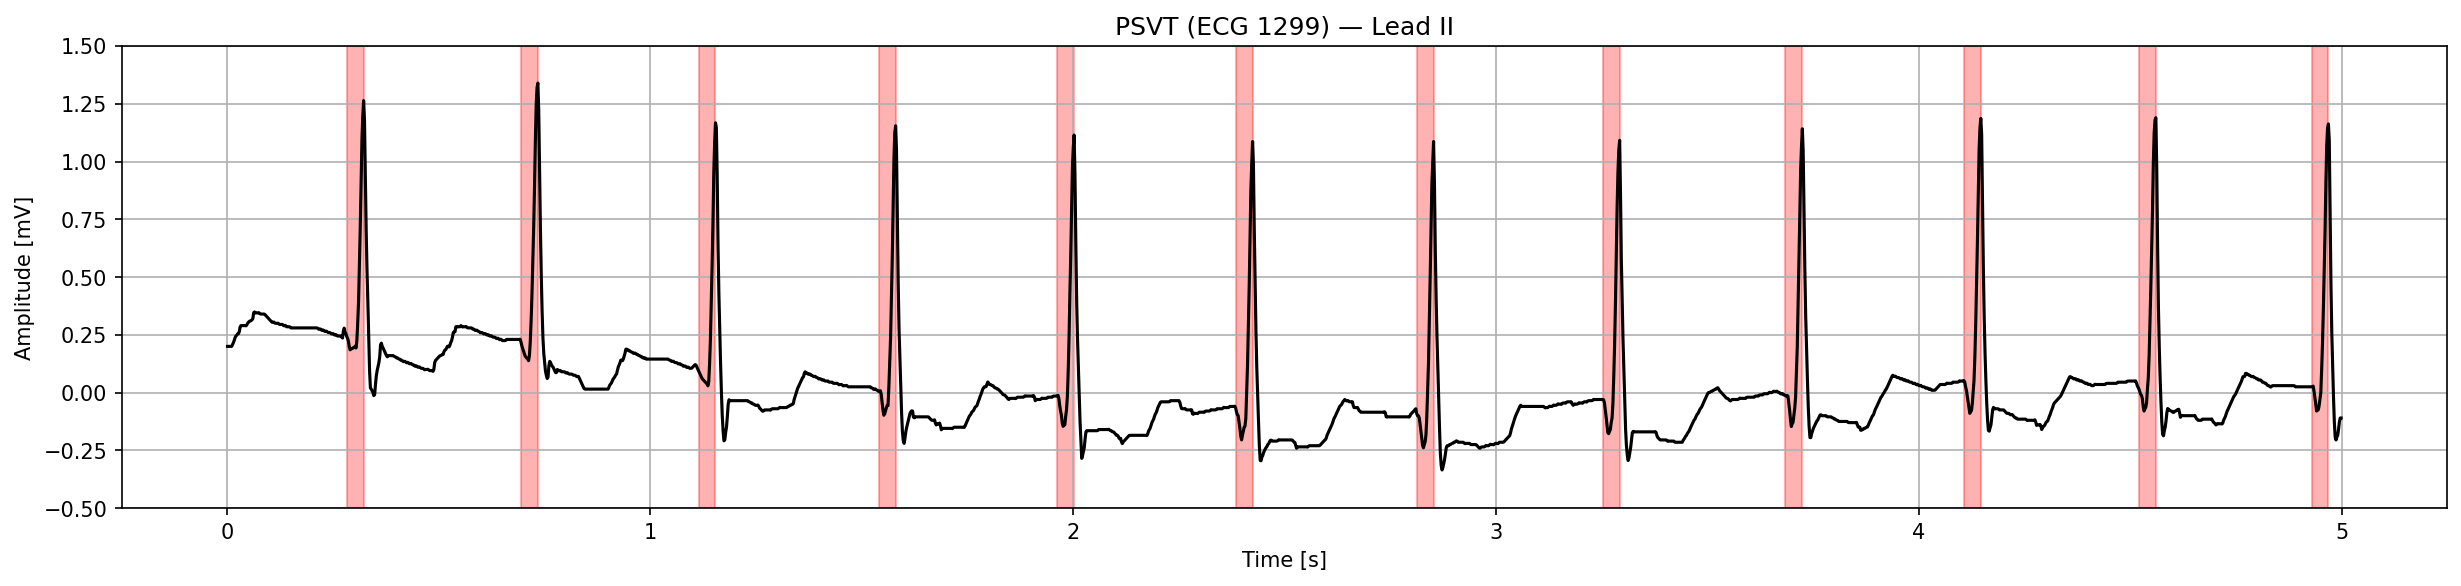

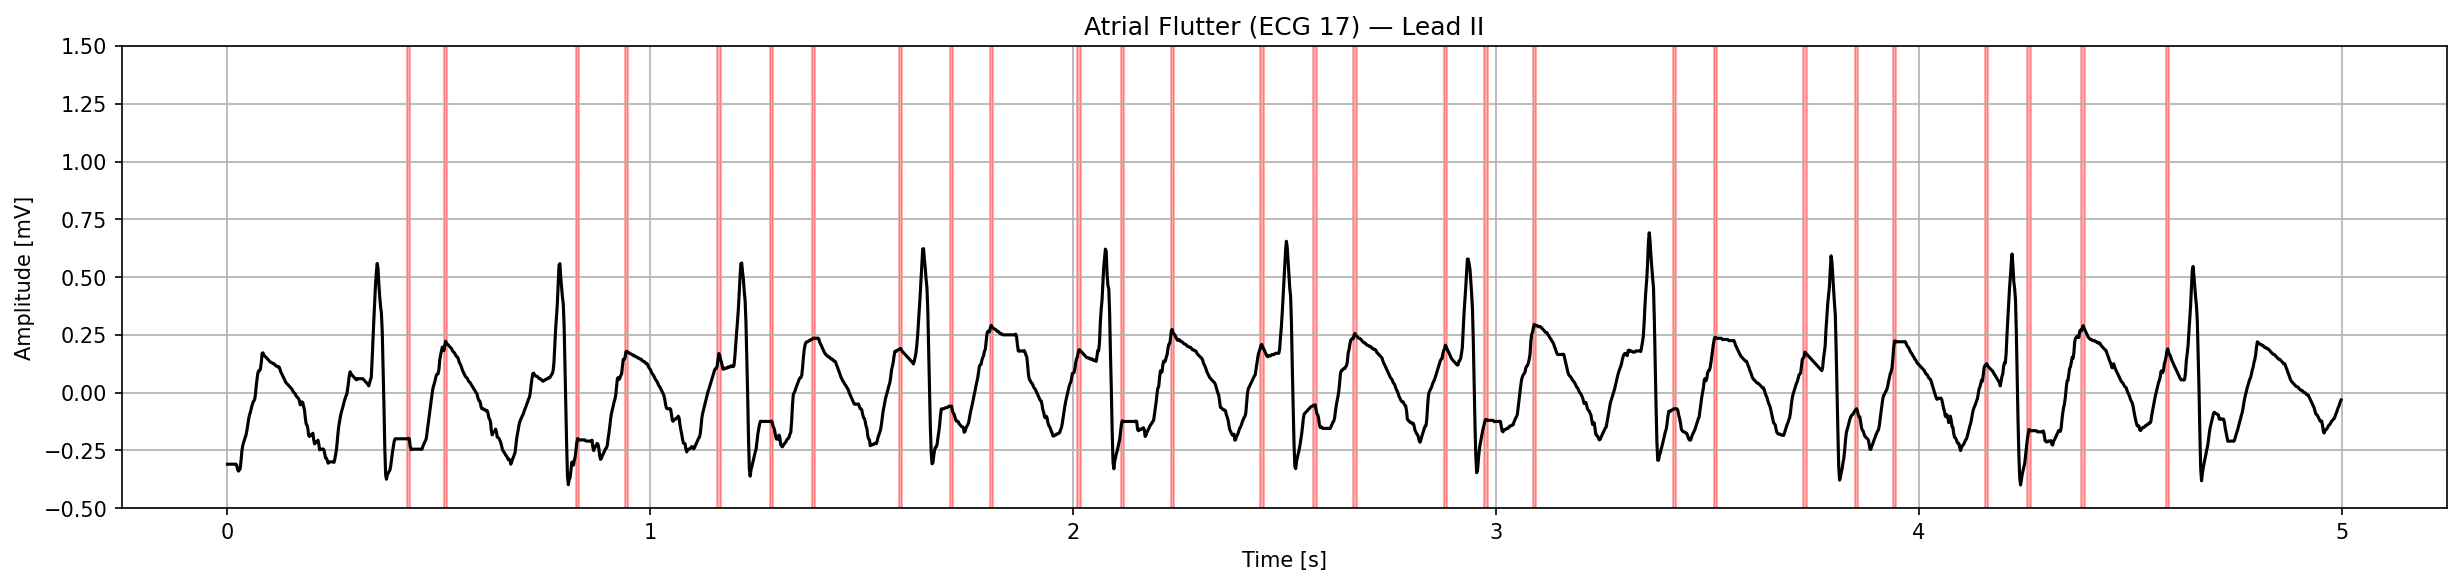

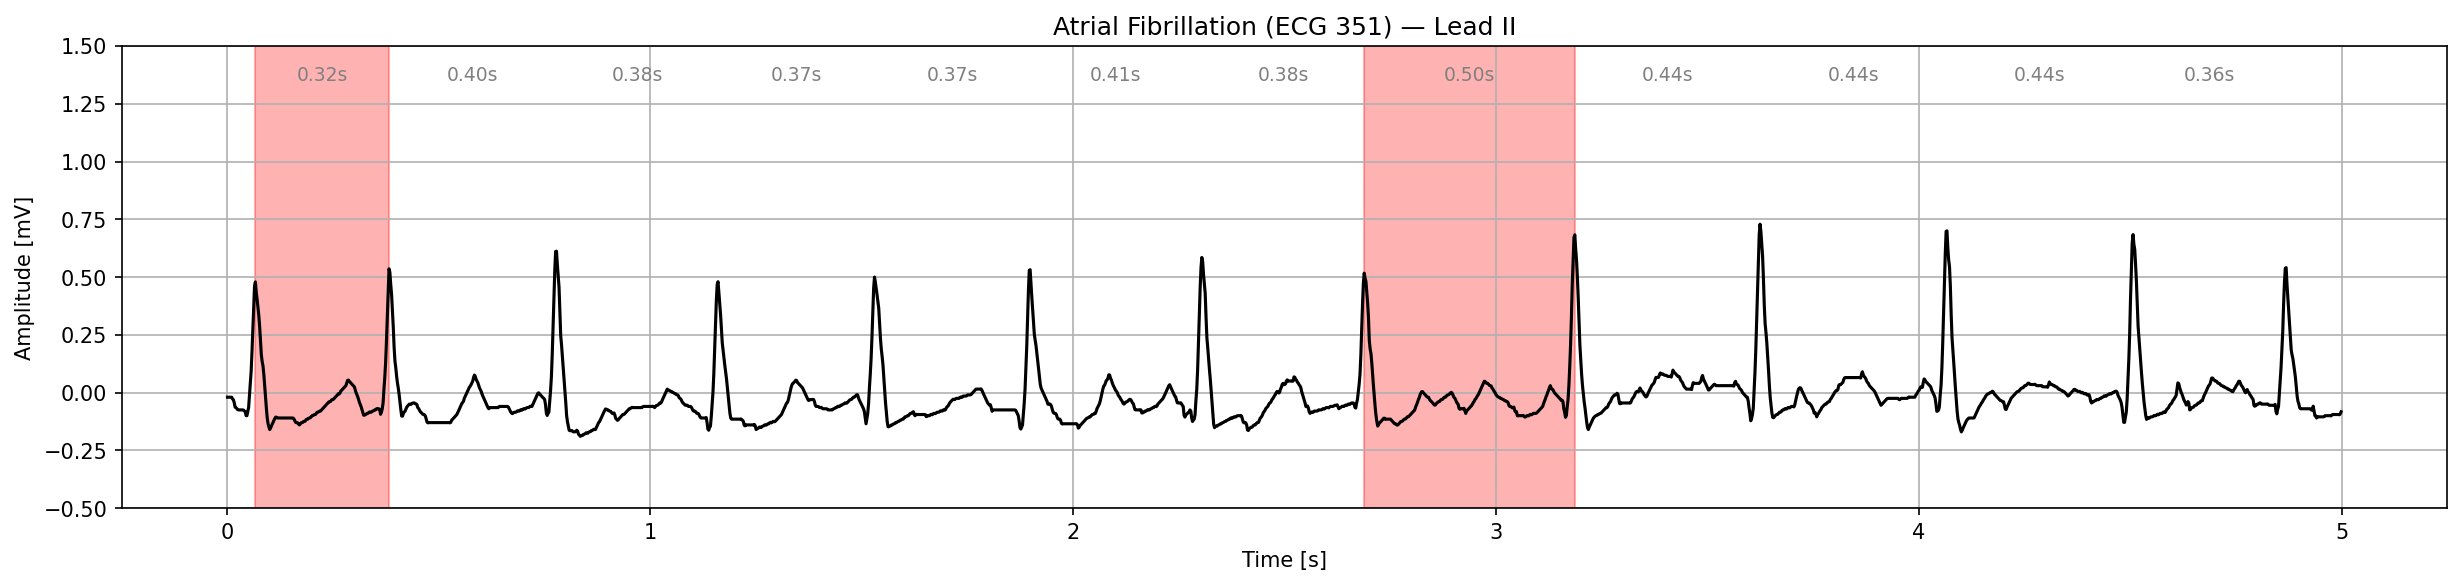

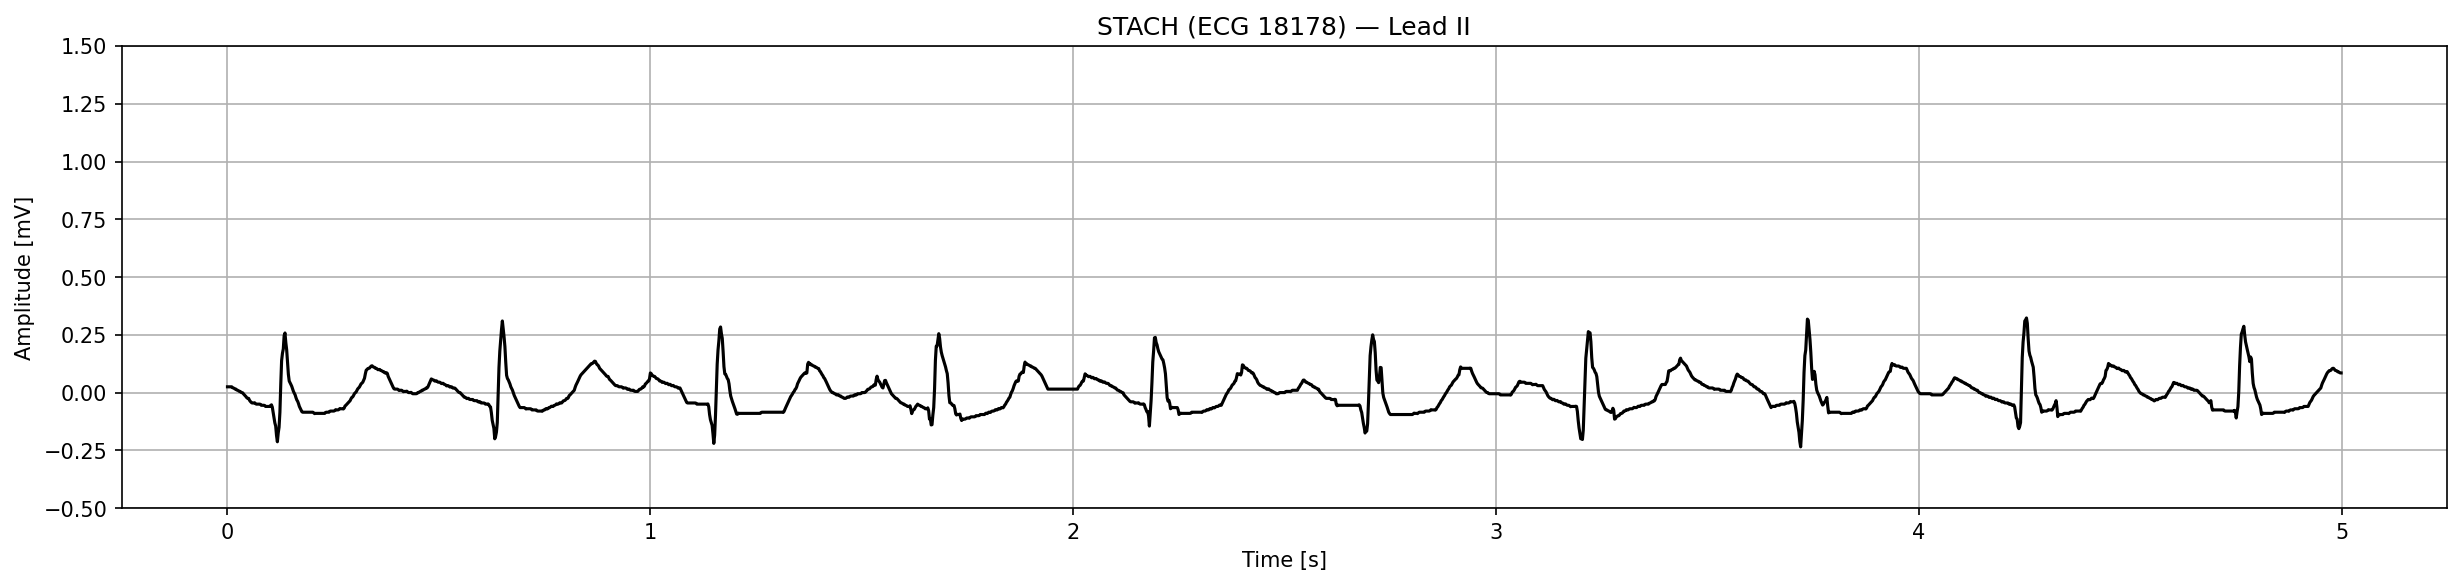


ECG Stats Summary:
   ECG_ID             Category  Mean (mV)  Min (mV)  Max (mV)  Std (mV)  \
0    1299                 PSVT   0.026806    -0.335     1.340  0.229290   
1      17       Atrial Flutter   0.014938    -0.400     0.692  0.189729   
2     351  Atrial Fibrillation  -0.017537    -0.189     0.729  0.128633   
3   18178                STACH  -0.002282    -0.235     0.323  0.076905   

   Estimated HR (bpm)  
0          142.180095  
1          139.534884  
2          153.846154  
3          116.731518  


In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import os

# example patient ids per category
example_ids = {
    "PSVT": 1299,
    "Atrial Flutter": 17,
    "Atrial Fibrillation": 351,
    "STACH": 18178,
}

stats_list = []
y_min, y_max = -0.5, 1.5

for category, ecg_id in example_ids.items():
    fname = f"{ecg_id:05d}_hr"
    filepath = os.path.join("ptbxl_data", fname)

    try:
        record, fields = wfdb.rdsamp(filepath)
        sig = record
        fs = fields['fs']

        n_samples = int(5*fs)
        t = np.arange(n_samples)/fs
        lead2 = sig[:n_samples, 1]

        mean_val = np.mean(lead2)
        min_val = np.min(lead2)
        max_val = np.max(lead2)
        std_val = np.std(lead2)

        # r peaks (not the algo just quick func to plot)
        r_peaks, _ = find_peaks(lead2, distance=0.4*fs, prominence=0.2*np.ptp(lead2))
        rr_intervals = np.diff(r_peaks)/fs
        median_rr = np.median(rr_intervals) if len(rr_intervals)>0 else 1.0
        hr_est = 60 / median_rr if median_rr>0 else np.nan

        highlights = []
        annotations = []

        if category == "PSVT":
            for r in r_peaks:
                # look 40 ms before R
                start = max(r - int(0.04*fs), 0)
                pre_r = lead2[start:r]
                # highlight for hidden/small P
                if np.max(np.abs(pre_r)) < 0.15*np.ptp(lead2):
                    highlights.append((start, r))
                # highlight gradual upstroke (if there's delta wave)
                elif pre_r[-1] > 0.3*np.ptp(lead2):
                    highlights.append((start, r))
        elif category == "Atrial Flutter":
            for i in range(len(r_peaks)-1):
                segment = lead2[r_peaks[i]:r_peaks[i+1]]
                peaks, _ = find_peaks(segment, distance=fs*0.04, prominence=0.05*np.ptp(segment))
                for p in peaks:
                    highlights.append((r_peaks[i]+p-2, r_peaks[i]+p+2))
        elif category == "Atrial Fibrillation":
                # more sensitive r peak detection for afib
                r_peaks, _ = find_peaks(
                    lead2,
                    distance=0.3*fs,
                    prominence=0.05*np.ptp(lead2)
                )
                rr_intervals = np.diff(r_peaks)/fs
                median_rr = np.median(rr_intervals) if len(rr_intervals)>0 else 1.0
                hr_est = 60 / median_rr if median_rr>0 else np.nan

                # highlights for irregular rr intervals >15%
                highlights = []
                for i, rr in enumerate(rr_intervals):
                    if abs(rr-median_rr)/median_rr > 0.15:
                        start = r_peaks[i]
                        end = r_peaks[i+1]
                        highlights.append((start,end))

                # annotate all rr intervals
                annotations = []
                for i, rr in enumerate(rr_intervals):
                    xpos = (r_peaks[i] + r_peaks[i+1])/2 / fs
                    annotations.append((xpos, rr))

        # plot
        plt.figure(figsize=(20, 4), dpi=150)
        plt.plot(t, lead2, color='black', label='Lead II')

        for start,end in highlights:
            plt.axvspan(start/fs, end/fs, color='red', alpha=0.3)

        # annotate rr intervals for afib
        if category=="Atrial Fibrillation":
            for xpos, rr in annotations:
                plt.text(xpos, y_max*0.9, f"{rr:.2f}s", color='gray', ha='center', fontsize=9)

        plt.title(f"{category} (ECG {ecg_id}) — Lead II")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude [mV]")
        plt.ylim(y_min, y_max)
        plt.grid(True)
        plt.show()

        stats_list.append({
            "ECG_ID": ecg_id,
            "Category": category,
            "Mean (mV)": mean_val,
            "Min (mV)": min_val,
            "Max (mV)": max_val,
            "Std (mV)": std_val,
            "Estimated HR (bpm)": hr_est
        })

    except Exception as e:
        print(f"couldn't load {ecg_id}: {e}")

stats_df = pd.DataFrame(stats_list)
print("\nECG Stats Summary:")
print(stats_df)

### algo functions

#### 1. wavelet transform

In [52]:
import numpy as np
from scipy.signal import resample

def waveletH(w):
    return np.exp(1j*w/2) * np.cos(w/2)**3

def waveletG(w):
    return 4j*np.exp(1j*w/2) * np.sin(w/2)

def waveletFilters(N, fs):
    M = int(N * 250 / fs)
    w = np.arange(0, 2*np.pi, 2*np.pi/M)
    Q = [waveletG(w)]
    for k in range(2,6):
        G = waveletH(w)
        for l in range(1,k-1):
            G *= waveletH(2**l * w)
        Q.append(waveletG(2**(k-1)*w) * G)
    for i in range(len(Q)):
        Q[i] = np.fft.fft(resample(np.fft.ifft(Q[i]), N))
    return Q

def atrous_decompose_aligned(sig, levels=4):
    #no delay correction
    sig = np.asarray(sig, float)
    N = len(sig)
    Q = waveletFilters(N, fs)

    details = []
    for q in Q[:levels]:
        d = np.real(np.fft.ifft(np.fft.fft(sig) * q))
        details.append(d)

    return details

pres plot

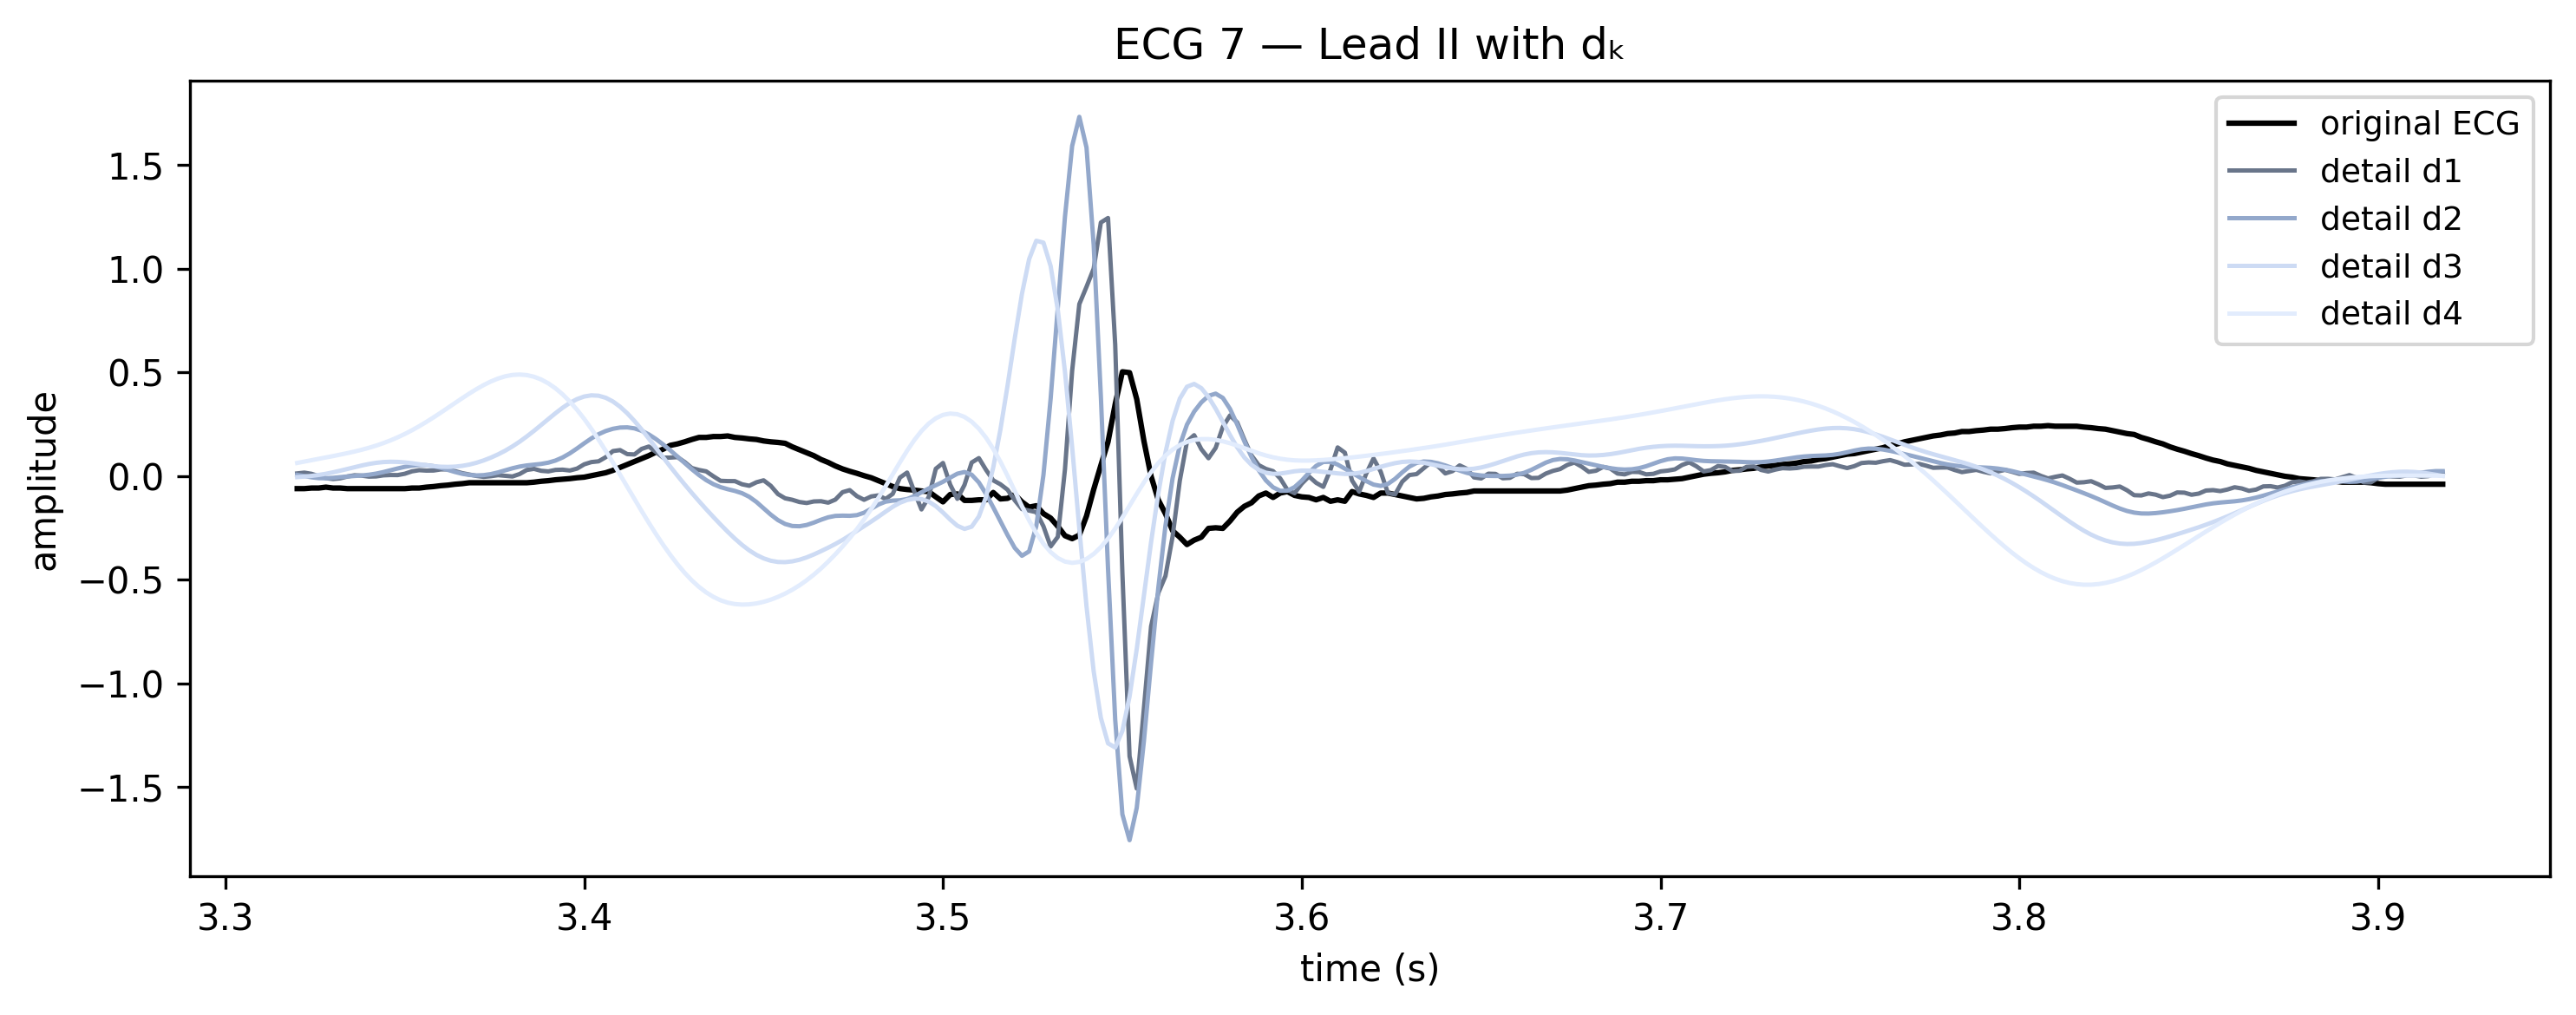

In [53]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np

example_ecg = 7
record = f"{example_ecg}"
path = os.path.join("ludb_data", record)

sig, fields = wfdb.rdsamp(path)

leadII = sig[:, 1]

details = atrous_decompose_aligned(leadII, 4)
d1 = details[0]
d2 = details[1]
d3 = details[2]
d4 = details[3]

fs = fields["fs"]
start_sec = 3.32
win_sec = 0.6

start = int(start_sec * fs)
end = int((start_sec + win_sec) * fs)

t = np.arange(start, end) / fs

palette = [
    "#69758a",
    "#93a8cb",
    "#cddbf4",
    "#e2ecfd",
]

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(t, leadII[start:end], color="black", lw=1.5, label="original ECG")

plt.plot(t, d1[start:end], color=palette[0], lw=1.2, label="detail d1")
plt.plot(t, d2[start:end], color=palette[1], lw=1.2, label="detail d2")
plt.plot(t, d3[start:end], color=palette[2], lw=1.2, label="detail d3")
plt.plot(t, d4[start:end], color=palette[3], lw=1.2, label="detail d4")

plt.title("ECG 7 — Lead II with dₖ", fontsize=12)
plt.xlabel("time (s)")
plt.ylabel("amplitude")

plt.legend(
    frameon=True,
    edgecolor="#cccccc",
    fontsize=9
)

plt.tight_layout()
plt.show()

#### 2. qrs detection

In [54]:
#helpers
def modulus_maxima_pair(d, nZ):

    N = len(d)

    # left maximum
    i = nZ - 1
    while i > 1 and abs(d[i]) >= abs(d[i-1]):
        i -= 1

    n_pre = max(0, min(i, N-1))   # safe for ovf

    # right maximum
    j = nZ + 1
    while j < N-1 and abs(d[j]) >= abs(d[j+1]):
        j += 1

    n_post = max(0, min(j, N-1))  # safe for ovf

    # values
    v_pre = d[n_pre]
    v_post = d[n_post]

    # classify + fallback
    if v_pre >= 0 and v_post < 0:
        pos_max = v_pre
        neg_min = v_post
    elif v_post >= 0 and v_pre < 0:
        pos_max = v_post
        neg_min = v_pre
    else:
        pos_max = max(v_pre, v_post)
        neg_min = min(v_pre, v_post)

    AMMp = pos_max - neg_min

    return AMMp, n_pre, n_post

def delta_d(d, nZ, W):
    lo = max(0, nZ - W)
    hi = min(len(d), nZ + W + 1)
    win = d[lo:hi]
    if win.size == 0:
        return 0.0
    return float(np.max(win) - np.min(win))


def compute_threshold(recent_vals):
    #paper eq. 5.3
    if len(recent_vals) == 0:
        return 0.0
    return (11.0 / 32.0) * float(np.mean(recent_vals))

#main detection
def qrs_detect_online(d2, d3, fs, learning_time=0.5, N_recent=4):

    # params (paper)
    WQRS_ms = 250
    W100_ms = 100

    WQRS = int(WQRS_ms * fs / 1000)
    W100 = int(W100_ms * fs / 1000)

    recent_d2 = []
    recent_d3 = []
    eps2 = 0.0
    eps3 = 0.0

    # state
    candidate = None
    candidate_amp = 0.0
    counter = 0
    confirmed_R = []

    # diagnostics
    candidates_history = []
    eps2_history = []
    eps3_history = []
    evaluated_candidates = []  # (nZ, d2_val, d3_val, eps2, eps3, accepted_bool)

    L = len(d2)
    time_sec = 0.0

    for n in range(1, L):
        time_sec = n / float(fs)

        # zero-crossing detection
        if np.sign(d2[n]) != np.sign(d2[n-1]):
            # get amplitude using modulus maxima pair routine
            amp, _, _ = modulus_maxima_pair(d2, n)
            candidates_history.append((n, amp))

            if counter == 0:
                # first candidate -> store and start WQRS window
                candidate = n
                candidate_amp = amp
                counter = WQRS
            else:
                # inside window -> if stronger replace and reset counter
                if amp > candidate_amp:
                    candidate = n
                    candidate_amp = amp
                    counter = WQRS

        # countdown and evaluate when window ends
        if counter > 0:
            counter -= 1

            if counter == 0 and candidate is not None:
                nZ = candidate

                # delta d2 (eq 5.1)
                d2_val = delta_d(d2, nZ, W100)
                eps2 = compute_threshold(recent_d2)   # eq 5.3

                accepted = False
                if d2_val > eps2:                     # eq 5.2
                    # delta d3 (eq 5.4)
                    d3_val = delta_d(d3, nZ, W100)
                    eps3 = compute_threshold(recent_d3)

                    if d3_val > eps3:                 # eq 5.5
                        # confirmed candidate
                        recent_d2.append(d2_val)
                        recent_d3.append(d3_val)
                        # keep only last N_recent
                        if len(recent_d2) > N_recent:
                            recent_d2.pop(0)
                        if len(recent_d3) > N_recent:
                            recent_d3.pop(0)

                        # update eps histories
                        eps2 = compute_threshold(recent_d2)
                        eps3 = compute_threshold(recent_d3)
                        eps2_history.append((n, eps2))
                        eps3_history.append((n, eps3))

                        # only output after learning period
                        if time_sec > learning_time:
                            confirmed_R.append(int(nZ))

                        accepted = True

                evaluated_candidates.append((nZ, d2_val, (d3_val if 'd3_val' in locals() else None),
                                             eps2, eps3, accepted))

                # reset candidate state
                candidate = None
                candidate_amp = 0.0

    R = np.array(confirmed_R, dtype=int)
    diag = {
        "recent_d2": recent_d2,
        "recent_d3": recent_d3,
        "candidates_history": candidates_history,
        "evaluated_candidates": evaluated_candidates,
        "eps2_history": eps2_history,
        "eps3_history": eps3_history
    }
    return R, diag

pres plot

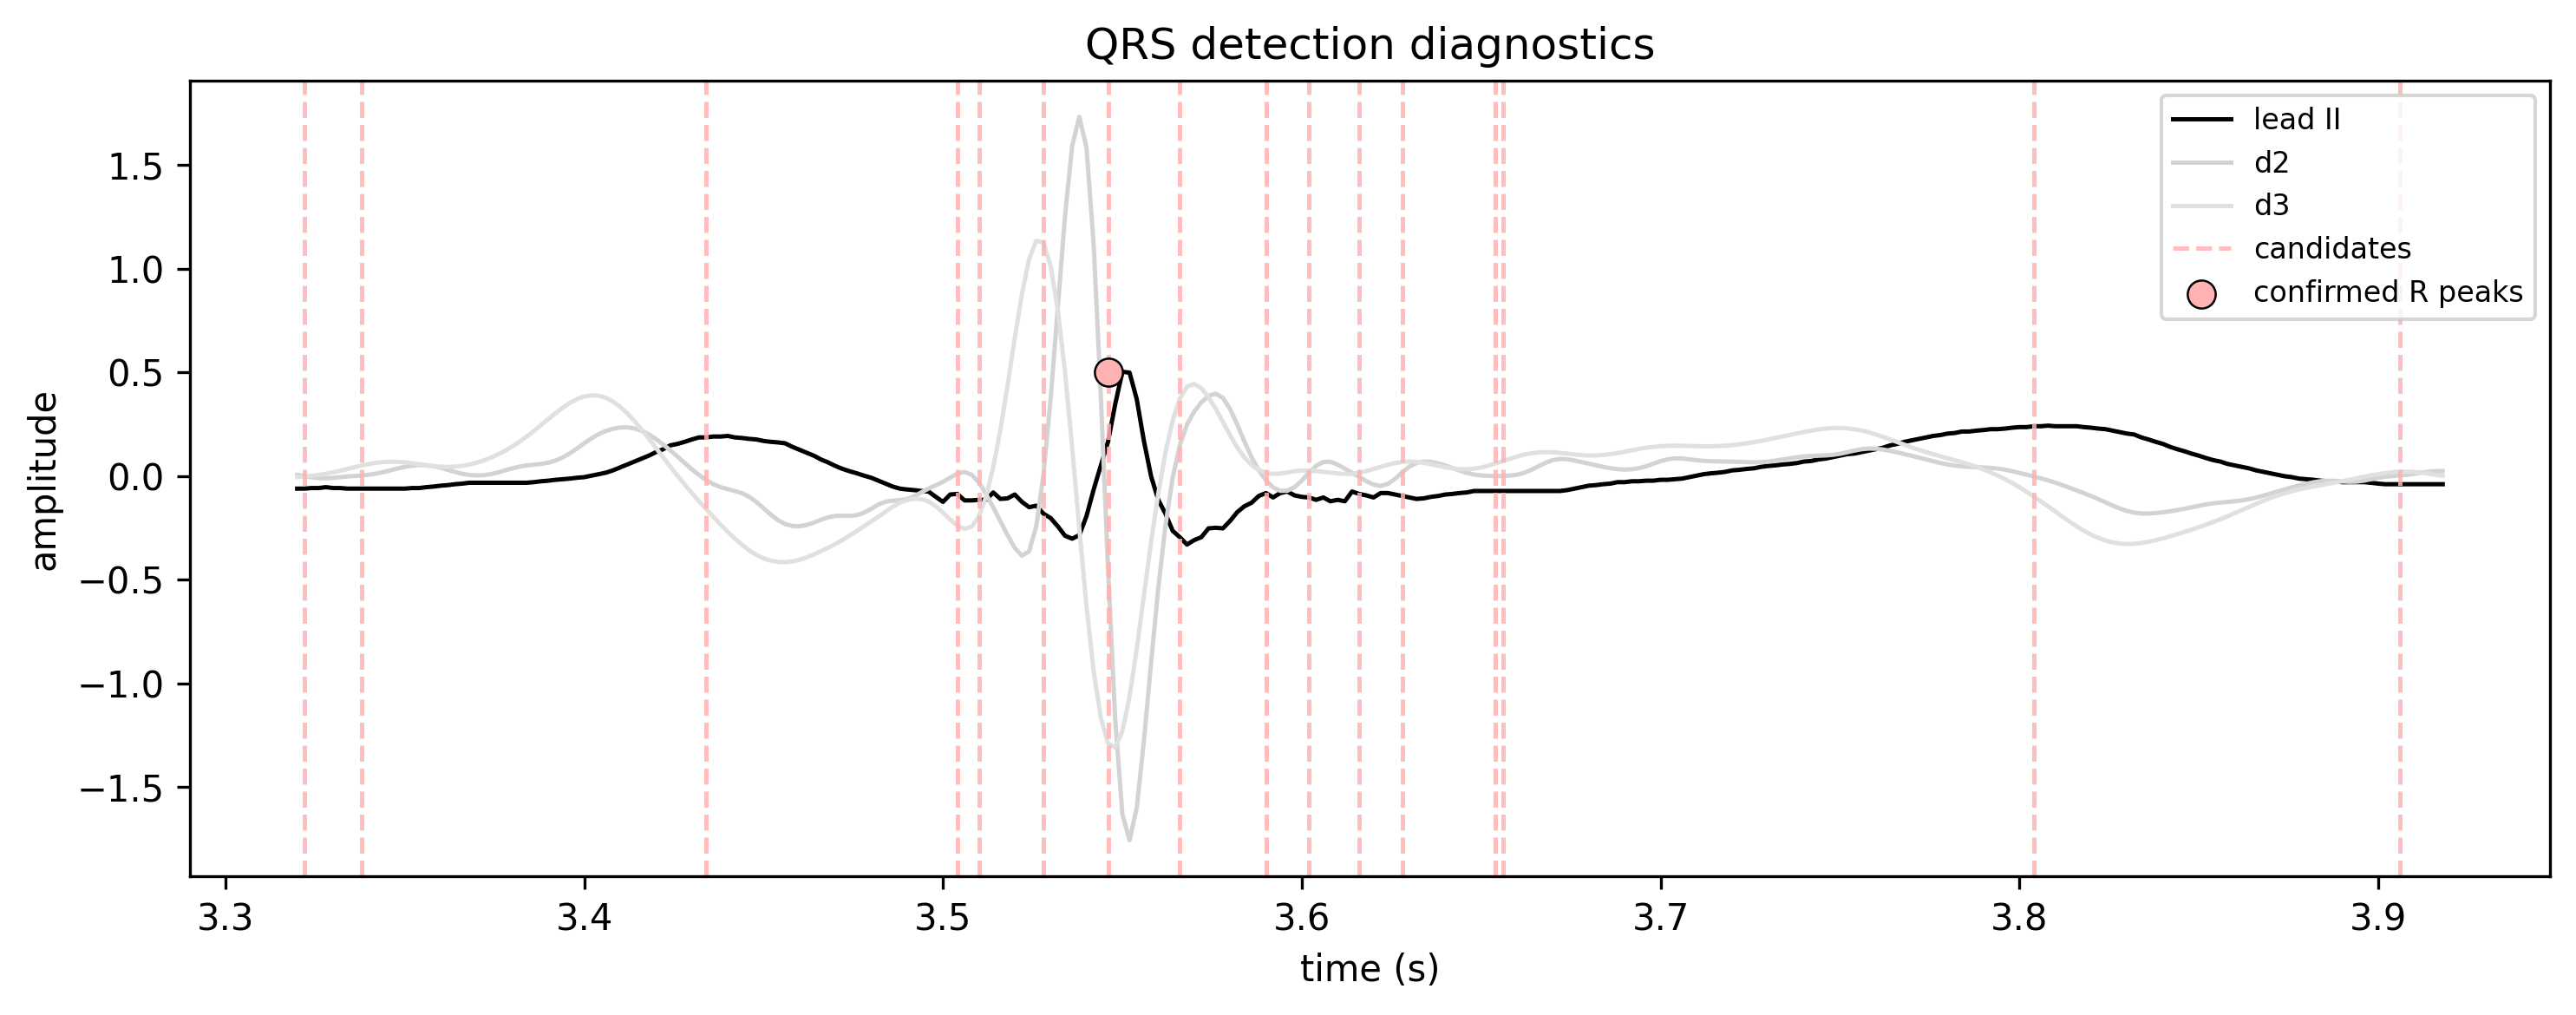

In [55]:
R, diag = qrs_detect_online(d2, d3, fs, 1)

recent_d2 = diag["recent_d2"]
recent_d3 = diag["recent_d3"]
candidates_history = diag["candidates_history"]

R_win = R[(R >= start) & (R < end)]
R_win_rel = R_win - start

cand_idx = np.array([c[0] for c in candidates_history])

cand_idx_win = cand_idx[(cand_idx >= start) & (cand_idx < end)]

cand_idx_rel = cand_idx_win - start

t = np.arange(start, end) / fs

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(
    t,
    leadII[start:end],
    color="black",
    linewidth=1.2,
    label="lead II"
)

plt.plot(
    t,
    d2[start:end],
    color="lightgray",
    linewidth=1.2,
    label="d2"
)

plt.plot(
    t,
    d3[start:end],
    color="#e0e0e0",
    linewidth=1.2,
    label="d3"
)

if len(cand_idx_rel) > 0:
    plt.axvline(
        t[cand_idx_rel[0]],
        color="#ffb2b2",
        linestyle="--",
        alpha=0.85,
        linewidth=1.2,
        label="candidates"
    )

for idx in cand_idx_rel[1:]:
    plt.axvline(
        t[idx],
        color="#ffb2b2",
        linestyle="--",
        alpha=0.85,
        linewidth=1.2,
        label="_nolegend_"
    )

plt.scatter(
    t[R_win_rel],
    leadII[R_win_rel],
    color="#ffb2b2",
    s=60,
    edgecolors="black",
    linewidths=0.6,
    zorder=5,
    label="confirmed R peaks"
)

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title("QRS detection diagnostics")

plt.legend(frameon=True, edgecolor="#cccccc", fontsize=8)
plt.tight_layout()
plt.show()

#### 3. qrs delineation

In [56]:
#helpers
def is_local_extremum(d, i):

    if i <= 0 or i >= len(d)-1:
        return False
    return (d[i] > d[i-1] and d[i] > d[i+1]) or (d[i] < d[i-1] and d[i] < d[i+1])

def find_adjacent_modulus_maxima(d2, nZ):
    N = len(d2)

    def is_modulus_max(i):
        if i <= 0 or i >= N - 1:
            return False
        return abs(d2[i]) > abs(d2[i-1]) and abs(d2[i]) > abs(d2[i+1])

    # search left
    i = nZ - 1
    while i > 1 and not is_modulus_max(i):
        i -= 1
    npre = i

    # search right
    j = nZ + 1
    while j < N - 1 and not is_modulus_max(j):
        j += 1
    npost = j

    # return signed value
    return npre, npost, d2[npre], d2[npost]

def delineate_qrs(d2, nZ, fs=500):
    N = len(d2)

    # find npre, npost
    npre, npost, pre_val, post_val = find_adjacent_modulus_maxima(d2, nZ)

    # eq (5.6): thresholds
    # in the eqs they're signed but thresholds have to be positive for algo to detect properly
    # -> used modulus values to make it work
    eps_on_I  = (abs(pre_val) + abs(post_val)) / 32.0
    eps_on_II = (abs(pre_val) + abs(post_val)) / 16.0

    W = int(0.120 * fs)   # fixed 120 ms window

    # backward search from npre
    maxima = []
    onset = None

    left_limit = max(0, npre - W)

    for idx in range(npre, left_limit - 1, -1):

        if is_local_extremum(d2, idx):
            maxima.append(idx)

            # stop when amplitude drops below eps_on_II
            if abs(d2[idx]) < eps_on_II:
                break

        # fallback condition (no maxima yet + crossing eps_on_I)
        if abs(d2[idx]) <= eps_on_I and len(maxima) == 0:
            onset = idx
            break

    # if maxima exist - eq (5.7)
    nleft = None

    if len(maxima) > 0:
        nleft = maxima[-1]     # left-most maximum
        eps_on_III = (d2[nleft]) / 4.0

        limit2 = max(left_limit, nleft - W)

        onset_found = None
        for idx in range(nleft, limit2 - 1, -1):
            if (d2[idx]) <= eps_on_III:
                onset_found = idx
                break

        if onset_found is not None:
            onset = onset_found

    if onset is None:
        onset = left_limit

    # offset (mirror rule) — eq (5.8)
    eps_off_I  = abs(post_val) / 4.0
    eps_off_II = abs(post_val) / 8.0

    maxima_r = []
    nright = None

    right_limit = min(N-1, npost + W)

    for idx in range(npost, right_limit + 1):

        if is_local_extremum(d2, idx):
            maxima_r.append(idx)

            if abs(d2[idx]) > eps_off_II:
                nright = idx

    if nright is not None:
        eps_off_III = (d2[nright]) / 4.0
        limit3 = min(N-1, nright + W)

        offset = None
        for idx in range(nright, limit3 + 1):
            if (d2[idx]) <= eps_off_III:
                offset = idx
                break

        if offset is None:
            offset = limit3

    else:
        offset = right_limit

    # enforce ordering
    onset = int(onset)
    if onset >= nZ:
        onset = nZ - 1

    offset = int(min(N-1, max(offset, nZ + 1)))

    return {
        "peak": nZ,
        "onset": onset,
        "offset": offset,
        "npre": npre,
        "npost": npost,
        "nleft": nleft,
        "nright": nright,
        "eps_on_I": eps_on_I,
        "eps_on_II": eps_on_II,
    }

def delineate_all_qrs(d2, R, fs=500):
    results = []
    for r in R:
        res = delineate_qrs(d2, r, fs)
        results.append(res)
    return results

pres plot

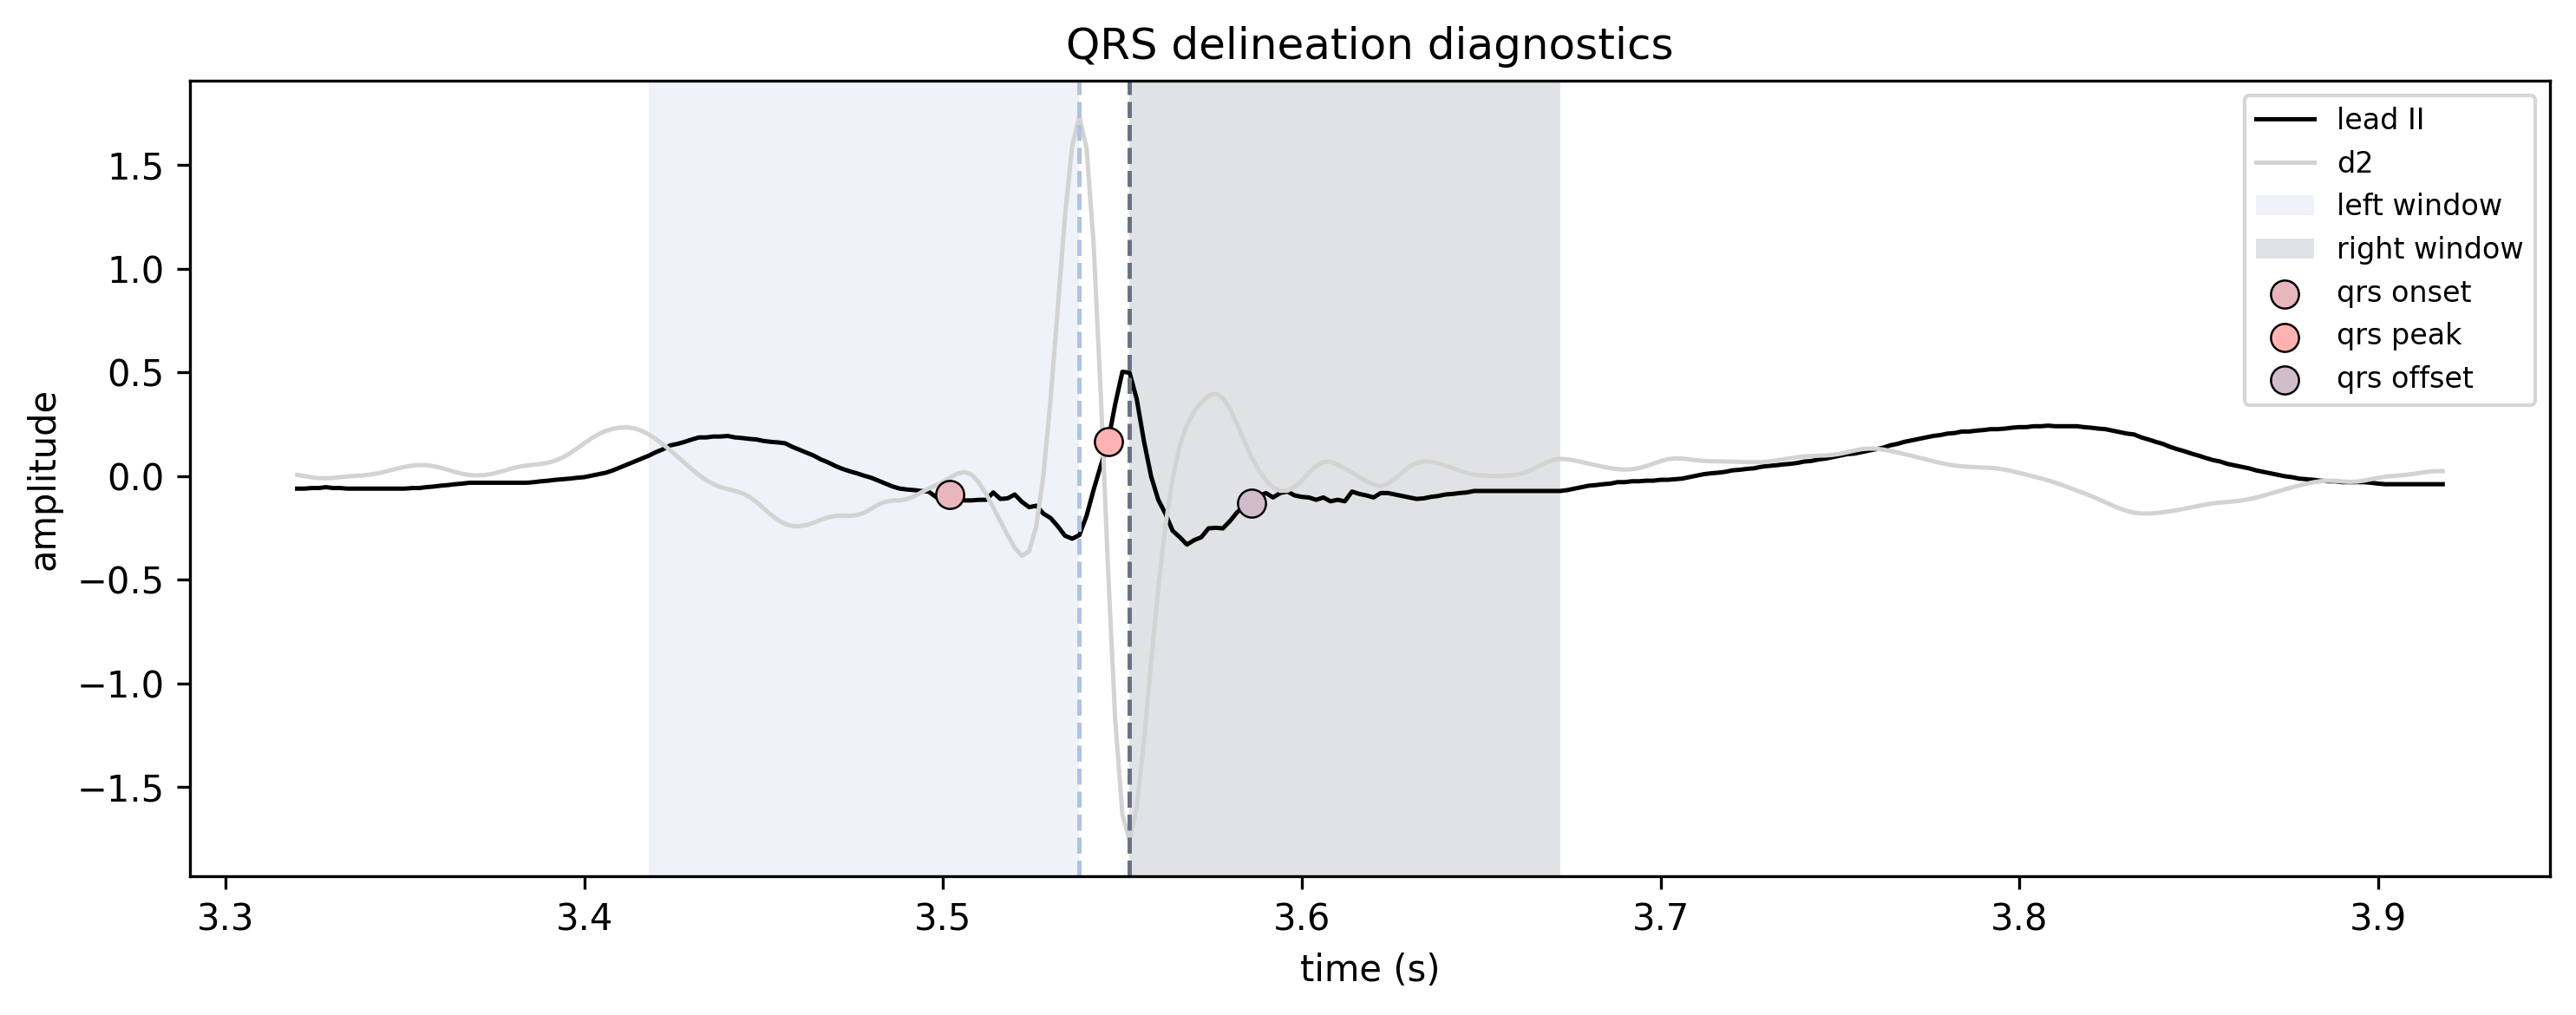

In [57]:
colors = {
    "qrs_onset":  "#eab6be",
    "qrs_peak":   "#ffb2b2",
    "qrs_offset": "#d0bccb",
    "left_window":  "#b1c2dd",
    "right_window": "#687284"
}

qrs_results = delineate_all_qrs(d2, R, fs)

t = np.arange(start, end) / fs

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(t, leadII[start:end], color="black", linewidth=1.2, label="lead II")
plt.plot(t, d2[start:end], color="lightgray", linewidth=1.2, label="d2")

onsets = np.array([res["onset"] for res in qrs_results])
peaks  = np.array([res["peak"] for res in qrs_results])
offsets = np.array([res["offset"] for res in qrs_results])
npre   = np.array([res["npre"] for res in qrs_results])
npost  = np.array([res["npost"] for res in qrs_results])

W = int(0.12*fs)

mask = (peaks >= start) & (peaks < end)
onsets_rel  = onsets[mask] - start
peaks_rel   = peaks[mask] - start
offsets_rel = offsets[mask] - start
npre_rel    = npre[mask] - start
npost_rel   = npost[mask] - start

for i in range(len(peaks_rel)):

    left_start = max(npre[mask][i] - W, start)
    left_end   = npre[mask][i]
    left_start_rel = left_start - start
    left_end_rel   = left_end - start

    plt.axvspan(t[left_start_rel], t[left_end_rel], facecolor=colors["left_window"],
                alpha=0.2, label="left window" if i==0 else "_nolegend_")
    plt.axvline(t[npre_rel[i]], color=colors["left_window"], linestyle="--", linewidth=1.2,
                label="_nolegend_")

    right_start = npost[mask][i]
    right_end   = min(npost[mask][i] + W, end)
    right_start_rel = right_start - start
    right_end_rel   = right_end - start

    plt.axvspan(t[right_start_rel], t[right_end_rel], facecolor=colors["right_window"],
                alpha=0.2, label="right window" if i==0 else "_nolegend_")
    plt.axvline(t[npost_rel[i]], color=colors["right_window"], linestyle="--", linewidth=1.2,
                label="_nolegend_")

for i in range(len(peaks_rel)):
    plt.scatter(t[onsets_rel[i]], leadII[onsets_rel[i]+start], color=colors["qrs_onset"], s=60,
                edgecolors="black", linewidths=0.6, zorder=5, label="qrs onset" if i==0 else "_nolegend_")
    plt.scatter(t[peaks_rel[i]], leadII[peaks_rel[i]+start], color=colors["qrs_peak"], s=60,
                edgecolors="black", linewidths=0.6, zorder=5, label="qrs peak" if i==0 else "_nolegend_")
    plt.scatter(t[offsets_rel[i]], leadII[offsets_rel[i]+start], color=colors["qrs_offset"], s=60,
                edgecolors="black", linewidths=0.6, zorder=5, label="qrs offset" if i==0 else "_nolegend_")

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"QRS delineation diagnostics")
plt.legend(frameon=True, edgecolor="#cccccc", fontsize=8)
plt.tight_layout()
plt.show()

#### 4. p-wave delination

In [58]:
# helpers
def is_local_modulus_max(a, i):
    return abs(a[i]) >= abs(a[i-1]) and abs(a[i]) >= abs(a[i+1])

def nearest_left_modulus_max(a, z, left):
    for i in range(z-1, left-1, -1):
        if is_local_modulus_max(a, i):
            return i
    return left

def nearest_right_modulus_max(a, z, right):
    for i in range(z+1, right+1):
        if is_local_modulus_max(a, i):
            return i
    return right

def modulus_maxima_between(a, s, e):
    s = max(1, s)
    e = min(len(a)-2, e)
    return [i for i in range(s, e+1) if is_local_modulus_max(a, i)]

# main function
def delineate_p_wave(d3, qrs_onset, qrs_peak, prev_peak, fs):

    # window length: min(300 ms, half previous RR)
    RR = qrs_peak - prev_peak
    if RR <= 0:
        return None

    win_ms = min(300.0, (RR / fs) * 1000.0 / 2.0)
    win = int(round(win_ms * fs / 1000.0))

    left  = max(0, qrs_onset - win)
    right = qrs_onset

    # exclude first 100 ms for Z search
    z_left = left + int(round(0.1 * fs))

    # zero-crossings
    zcs = [n for n in range(left+1, right)
           if np.sign(d3[n]) != np.sign(d3[n-1]) and n >= z_left]
    if not zcs:
        return None

    # compute AMMp for each Z candidate
    cand = []
    for z in zcs:
        npre  = nearest_left_modulus_max(d3, z, left)
        npost = nearest_right_modulus_max(d3, z, right)
        amm   = abs(d3[npre]) + abs(d3[npost])
        cand.append({"z": z, "npre": npre, "npost": npost, "amm": amm})

    # sort by descending AMMp
    cand.sort(key=lambda x: x["amm"], reverse=True)

    # select dominant nZ (eq 6.1)
    nZ = None
    npre_sel = npost_sel = None
    dom_amm = None

    def passes_eq61(a, npre, npost):
        return 0.5*abs(a[npost]) <= abs(a[npre]) <= 2*abs(a[npost])

    for c in cand:
        if passes_eq61(d3, c["npre"], c["npost"]):
            nZ, npre_sel, npost_sel, dom_amm = c["z"], c["npre"], c["npost"], c["amm"]
            break

    if nZ is None:
        return None

    biphasic = False
    delta = int(round(0.1 * fs))  # 100 ms

    zcs_sorted = sorted(zcs)
    idx = zcs_sorted.index(nZ)

    # left biphasic check
    if idx > 0 and (nZ - zcs_sorted[idx-1]) <= delta:
        zl = zcs_sorted[idx-1]
        npre_l  = nearest_left_modulus_max(d3, zl, left)
        npost_l = nearest_right_modulus_max(d3, zl, right)
        amm_l   = abs(d3[npre_l]) + abs(d3[npost_l])
        if passes_eq61(d3, npre_l, npost_l) and amm_l > 0.75*dom_amm:
            mm = modulus_maxima_between(d3, left if idx < 2 else zcs_sorted[idx-2], zl)
            if mm:
                npre_sel = mm[0]
                biphasic = True

    # right biphasic check
    if idx < len(zcs_sorted)-1 and (zcs_sorted[idx+1] - nZ) <= delta:
        zr = zcs_sorted[idx+1]
        npre_r  = nearest_left_modulus_max(d3, zr, left)
        npost_r = nearest_right_modulus_max(d3, zr, right)
        amm_r   = abs(d3[npre_r]) + abs(d3[npost_r])
        if passes_eq61(d3, npre_r, npost_r) and amm_r > 0.75*dom_amm:
            mm = modulus_maxima_between(d3, zr, right if idx+2 >= len(zcs_sorted) else zcs_sorted[idx+2])
            if mm:
                npost_sel = mm[-1]
                biphasic = True

    # onset (eq 6.3)
    eps_on = abs(d3[npre_sel]) / 4.0
    onset = None
    for n in range(npre_sel, left-1, -1):
        if abs(d3[n]) < eps_on:
            onset = n
            break

    # offset (eq 6.4)
    eps_off = 35.0 * abs(d3[npost_sel]) / 64.0
    offset = None
    for n in range(npost_sel, right):
        if abs(d3[n]) < eps_off:
            offset = n
            break

    if onset is None or offset is None:
        return None

    return {
        "peak":   int(nZ),
        "onset":  int(onset),
        "offset": int(offset),
        "npre":   int(npre_sel),
        "npost":  int(npost_sel),
        "biphasic": bool(biphasic)
    }

pres plot

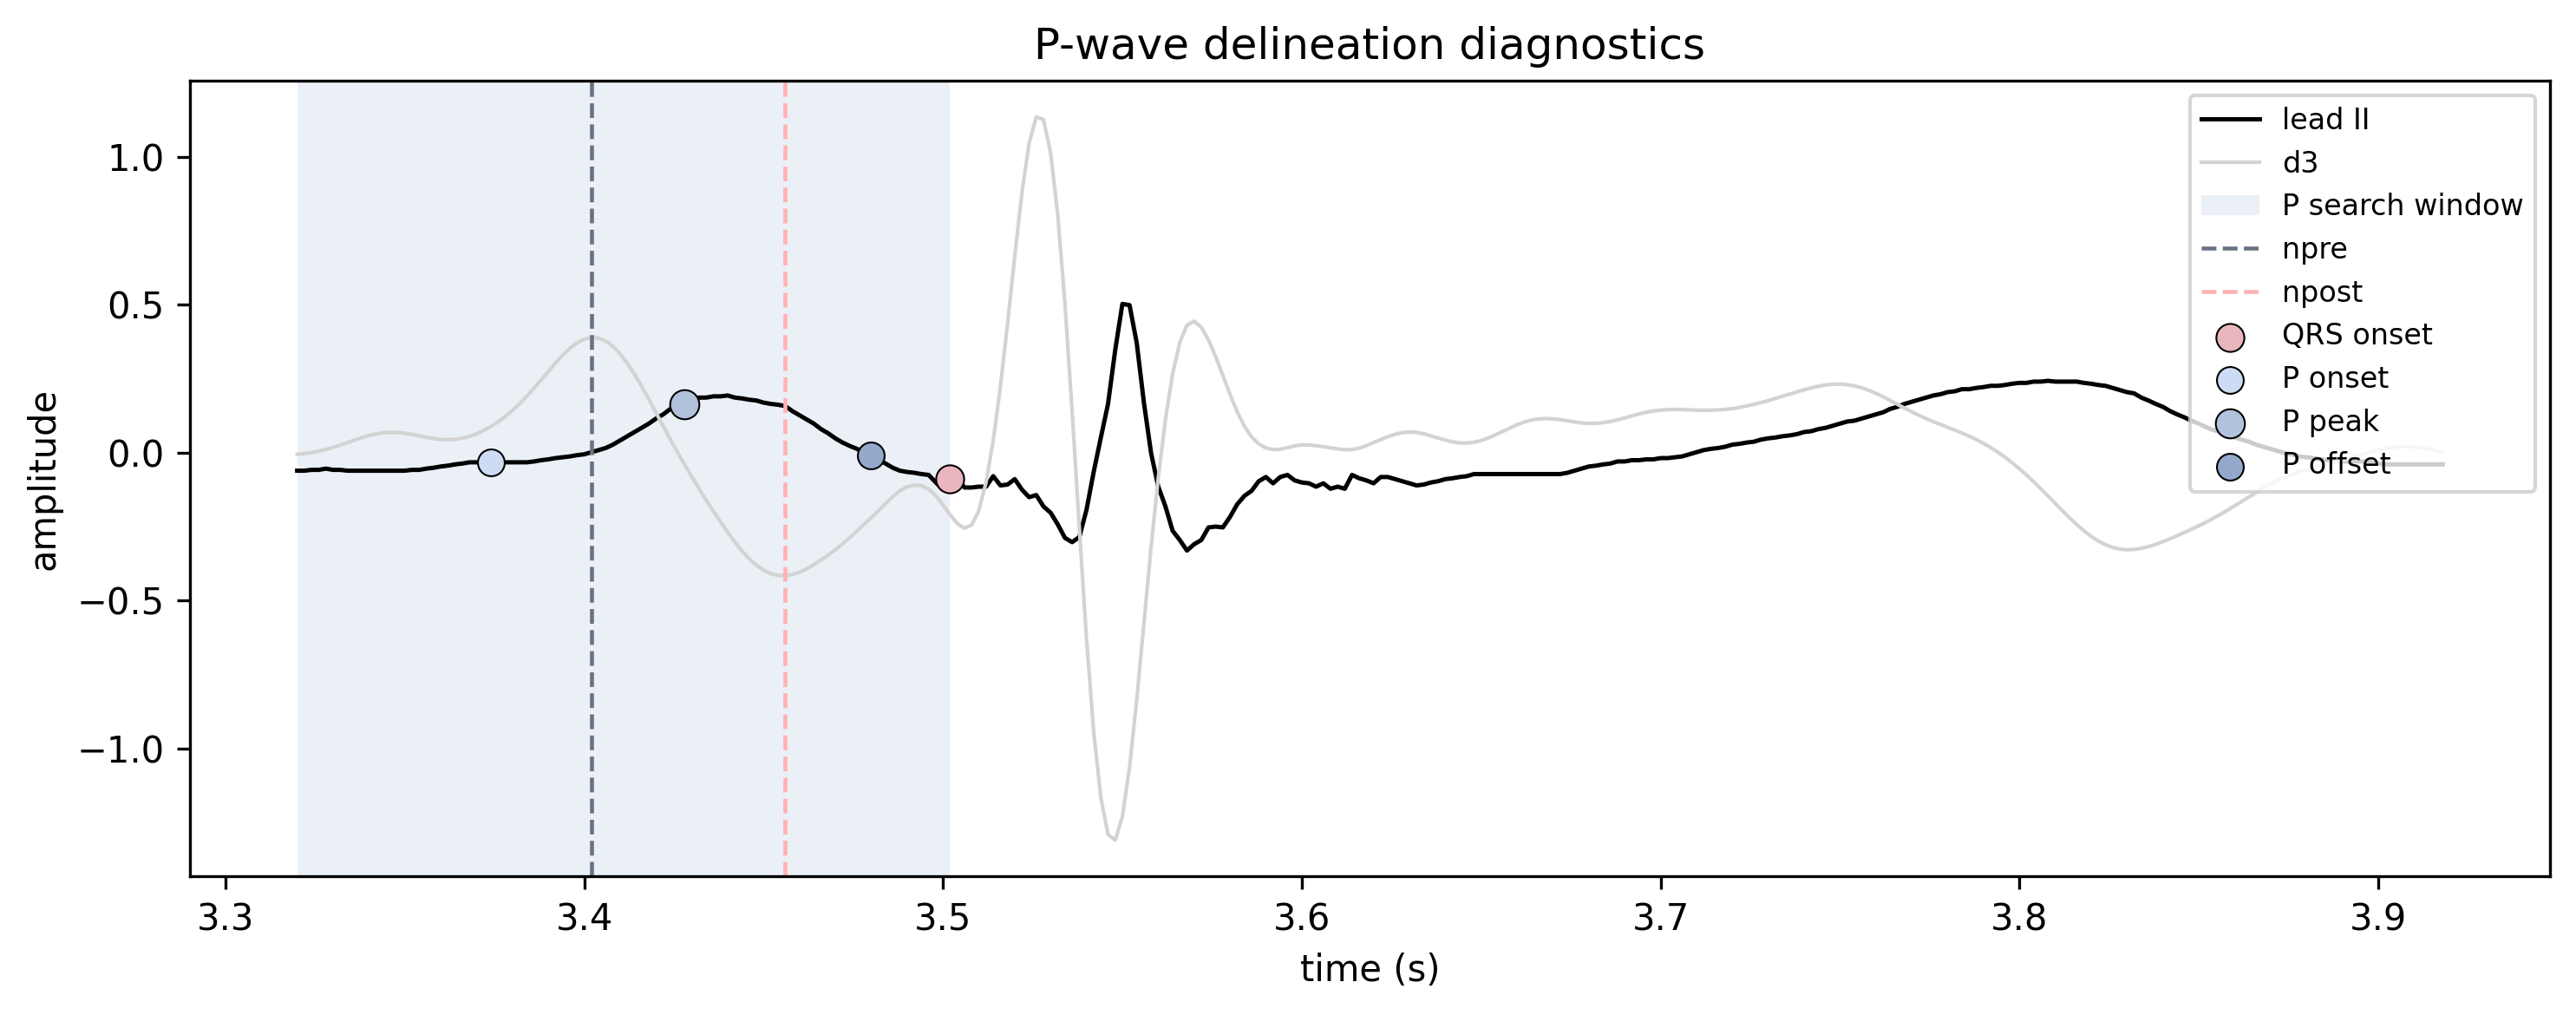

In [59]:
p_results = []

for i in range(1, len(R)):
    res = delineate_p_wave(
        d3=d3,
        qrs_onset=qrs_results[i]["onset"],
        qrs_peak=R[i],
        prev_peak=R[i-1],
        fs=fs
    )
    p_results.append(res)

colors = {
    "p_onset":  "#cddbf4",
    "p_peak":   "#b1c2dd",
    "p_offset": "#93a8ca",
    "p_window":  "#b1c2dd",
    "npre":      "#687284",
    "npost":     "#ffb2b2",
    "qrs_onset": "#eab6be",
}

t = np.arange(start, end) / fs

shown = {
    "p_on": False,
    "p_pk": False,
    "p_off": False,
    "qrs_on": False,
    "npre": False,
    "npost": False,
    "p_win": False,
}

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(t, leadII[start:end], color="black", linewidth=1.2, label="lead II")
plt.plot(t, d3[start:end], color="lightgray", linewidth=1.0, label="d3")


for i, pres in enumerate(p_results):

    if pres is None:
        continue

    p_on   = pres["onset"]
    p_pk   = pres["peak"]
    p_off  = pres["offset"]
    npre   = pres["npre"]
    npost  = pres["npost"]

    qrs_on = qrs_results[i+1]["onset"]
    prev_r = R[i]
    curr_r = R[i+1]

    RR = curr_r - prev_r
    win_ms = min(300.0, (RR / fs) * 1000.0 / 2.0)
    win = int(round(win_ms * fs / 1000.0))

    win_start = max(0, qrs_on - win)
    win_end   = qrs_on

    if not (start <= p_pk < end):
        continue

    rel = lambda x: x - start

    plot_ws = max(win_start, start)
    plot_we = min(win_end, end)

    if plot_ws < plot_we:
        plt.axvspan(
            t[rel(plot_ws)], t[rel(plot_we)],
            facecolor=colors["p_window"], alpha=0.25,
            label="P search window" if not shown["p_win"] else "_nolegend_"
        )
        shown["p_win"] = True

    if start <= npre < end:
        plt.axvline(
            t[rel(npre)], color=colors["npre"], linestyle="--", linewidth=1.1,
            label="npre" if not shown["npre"] else "_nolegend_"
        )
        shown["npre"] = True

    if start <= npost < end:
        plt.axvline(
            t[rel(npost)], color=colors["npost"], linestyle="--", linewidth=1.1,
            label="npost" if not shown["npost"] else "_nolegend_"
        )
        shown["npost"] = True

    if start <= qrs_on < end:
        plt.scatter(
            t[rel(qrs_on)], leadII[qrs_on],
            color=colors["qrs_onset"], s=60,
            edgecolors="black", linewidths=0.5, zorder=4,
            label="QRS onset" if not shown["qrs_on"] else "_nolegend_"
        )
        shown["qrs_on"] = True

    plt.scatter(
        t[rel(p_on)], leadII[p_on],
        color=colors["p_onset"], s=55,
        edgecolors="black", linewidths=0.5, zorder=4,
        label="P onset" if not shown["p_on"] else "_nolegend_"
    )
    shown["p_on"] = True

    plt.scatter(
        t[rel(p_pk)], leadII[p_pk],
        color=colors["p_peak"], s=65,
        edgecolors="black", linewidths=0.5, zorder=4,
        label="P peak" if not shown["p_pk"] else "_nolegend_"
    )
    shown["p_pk"] = True

    plt.scatter(
        t[rel(p_off)], leadII[p_off],
        color=colors["p_offset"], s=55,
        edgecolors="black", linewidths=0.5, zorder=4,
        label="P offset" if not shown["p_off"] else "_nolegend_"
    )
    shown["p_off"] = True

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title("P-wave delineation diagnostics")
plt.legend(loc="upper right", frameon=True, edgecolor="#cccccc", fontsize=8)
plt.tight_layout()
plt.show()

#### 5. t-wave delineation

In [60]:
def delineate_t_wave(d3n, qrs_off_prev, qrs_peak_curr, prev_peak, fs):

    # timing constants (paper)
    W80 = int(0.08 * fs)
    rr = qrs_peak_curr - prev_peak

    WT_left  = qrs_off_prev + W80
    WT_right = qrs_off_prev + int(19 * rr / 32)

    WTPK_left  = WT_left
    WTPK_right = qrs_off_prev + rr // 2

    if WT_right <= WT_left or WTPK_right <= WTPK_left:
        return None

    # zero-crossings for T peak
    zero_crossings = [
        n for n in range(WTPK_left + 1, WTPK_right)
        if np.sign(d3n[n]) != np.sign(d3n[n - 1])
    ]

    if not zero_crossings:
        return None

    # compute deltaMM for each crossing
    candidates = []
    for z in zero_crossings:
        AMMp, npre, npost = modulus_maxima_pair(d3n, z)
        candidates.append((z, AMMp, npre, npost))

    # dominant zero-crossing
    candidates.sort(key=lambda x: x[1], reverse=True)
    nZ, dom_MM, dom_npre, dom_npost = candidates[0]

    # biphasic check
    biphasic = False
    Tpk = nZ
    nfirst = dom_npre
    nlast  = dom_npost

    idx = zero_crossings.index(nZ)
    if idx > 0:
        zL = zero_crossings[idx - 1]
        MM_L, _, _ = modulus_maxima_pair(d3n, zL)
        if MM_L > (51 / 64) * dom_MM:
            biphasic = True
            Tpk = zL
            nfirst = modulus_maxima_pair(d3n, zL)[1]
            nlast  = dom_npost

    # T offset
    peak_val = abs(d3n[nlast])
    xiToff = (19 / 64) * peak_val

    # start after the post-MML
    search_start = nlast + int(0.04 * fs)
    Toff = WT_right

    for t in range(search_start, WT_right):
        if (
            abs(d3n[t]) < xiToff and
            abs(d3n[t]) < abs(d3n[t - 1])
        ):
            Toff = t
            break

    # T end (biphasic only)
    Tend = Toff
    if biphasic and idx + 1 < len(zero_crossings):
        zR = zero_crossings[idx + 1]
        _, _, npost_R = modulus_maxima_pair(d3n, zR)
        peak_R = abs(d3n[npost_R])
        xiTend = (19 / 64) * peak_R

        start = npost_R + int(0.04 * fs)
        for t in range(start, WT_right):
            if (
                abs(d3n[t]) < xiTend and
                abs(d3n[t]) < abs(d3n[t - 1])
            ):
                Tend = t
                break

    return {
        "peak": int(Tpk),
        "onset": int(WT_left),
        "offset": int(Toff),
        "tend": int(Tend),
        "biphasic": biphasic,
        "npre": int(dom_npre),
        "npost": int(dom_npost),
        "window": (int(WT_left), int(WT_right)),
        "pk_window": (int(WTPK_left), int(WTPK_right)),
    }

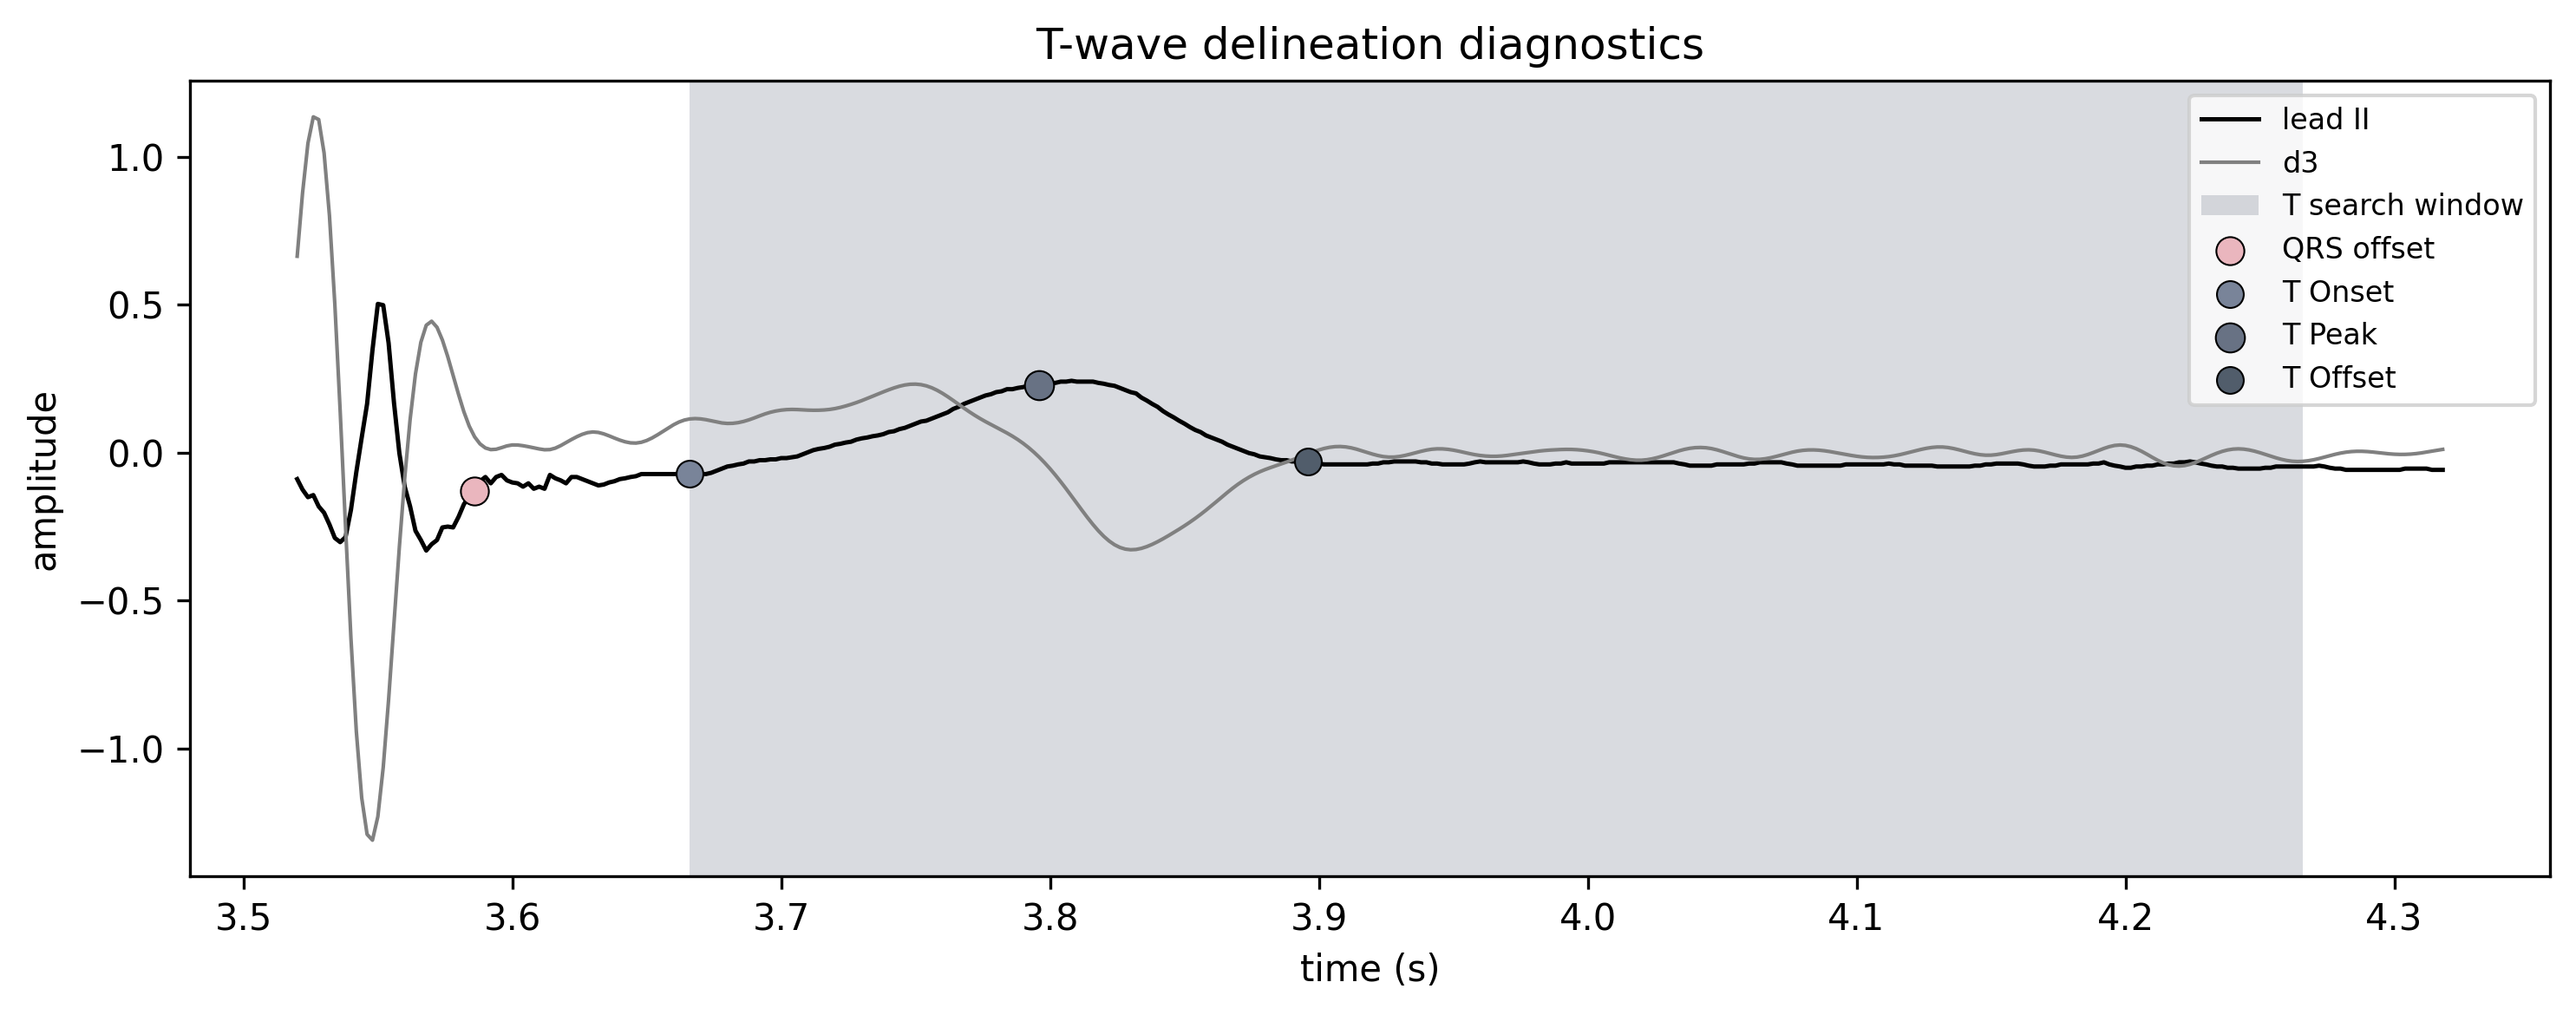

In [61]:
t_results = []

for i in range(1, len(R)):
    res = delineate_t_wave(
        d3n=d3,
        qrs_off_prev=qrs_results[i-1]["offset"],
        qrs_peak_curr=R[i],
        prev_peak=R[i-1],
        fs=fs
    )
    t_results.append(res)

colors = {
    "t_onset":  "#798499",
    "t_peak":   "#687284",
    "t_offset": "#515d6b",
    "t_window": "#687284",
    "qrs_offset": "#eab6be",
}

start_sec = 3.52
win_sec = 0.8

start = int(start_sec * fs)
end = int((start_sec + win_sec) * fs)

t_axis = np.arange(start, end) / fs
shown = {k: False for k in colors.keys()}

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(t_axis, leadII[start:end], color="black", linewidth=1.2, label="lead II")
plt.plot(t_axis, d3[start:end], color="gray", linewidth=1.0, label="d3")

for i, tres in enumerate(t_results):
    if tres is None:
        continue

    t_on, t_pk, t_off = tres["onset"], tres["peak"], tres["offset"]
    t_win, t_pk_win = tres["window"], tres["pk_window"]

    qrs_off = qrs_results[i]["offset_prev"] if "offset_prev" in qrs_results[i] else qrs_results[i]["offset"]

    rel = lambda x: x - start

    ws, we = max(t_win[0], start), min(t_win[1], end-1)
    if ws < we:
        plt.axvspan(
            t_axis[rel(ws)], t_axis[rel(we)],
            facecolor=colors["t_window"], alpha=0.25,
            label="T search window" if not shown["t_window"] else "_nolegend_"
        )
        shown["t_window"] = True

    if start <= qrs_off < end:
        qrs_clip = min(qrs_off, end-1)
        plt.scatter(
            t_axis[rel(qrs_clip)], leadII[qrs_clip],
            color=colors["qrs_offset"], s=60,
            edgecolors="black", linewidths=0.5, zorder=4,
            label="QRS offset" if not shown["qrs_offset"] else "_nolegend_"
        )
        shown["qrs_offset"] = True

    for key, idx, size in [("t_onset", t_on, 55),
                            ("t_peak", t_pk, 65),
                            ("t_offset", t_off, 55)]:
        if start <= idx < end:
            idx_clip = min(idx, end-1)
            plt.scatter(
                t_axis[rel(idx_clip)], leadII[idx_clip],
                color=colors[key], s=size,
                edgecolors="black", linewidths=0.5, zorder=5,
                label=key.replace("_", " ").title() if not shown[key] else "_nolegend_"
            )
            shown[key] = True

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title("T-wave delineation diagnostics")
plt.legend(loc="upper right", frameon=True, edgecolor="#cccccc", fontsize=8)
plt.tight_layout()
plt.show()

#### 6. metrics calc

In [27]:
import pandas as pd
import numpy as np

def compute_global_metrics_from_detections(detections, fs, signal):

    def mean_safe(vals):
        vals = [v for v in vals if v is not None]
        return float(np.mean(vals)) if vals else None

    def std_safe(vals):
        vals = [v for v in vals if v is not None]
        return float(np.std(vals)) if vals else None

    # RR intervals & HR
    R = detections.get("qrs_peak", [])
    RR_vals = [(R[i+1]-R[i])/fs for i in range(len(R)-1)] if len(R) > 1 else []
    rr_mean = mean_safe(RR_vals)
    rr_std  = std_safe(RR_vals)
    cv_rr = rr_std/rr_mean if rr_mean and rr_mean>0 else None

    rr_diff = [RR_vals[i+1]-RR_vals[i] for i in range(len(RR_vals)-1)] if len(RR_vals) > 1 else []
    rmssd = np.sqrt(np.mean(np.square(rr_diff))) if rr_diff else None
    hr_vals = [60.0/rr for rr in RR_vals if rr>0]
    hr_mean = mean_safe(hr_vals)
    hr_std  = std_safe(hr_vals)

    # PR interval
    p_onset = detections.get("p_onset", [])
    qrs_onset = detections.get("qrs_onset", [])
    pr_intervals = [(q-p)/fs for p,q in zip(p_onset, qrs_onset) if p is not None and q is not None]
    pr_mean = mean_safe(pr_intervals)
    pr_std  = std_safe(pr_intervals)
    pr_cv   = pr_std/pr_mean if pr_mean and pr_mean>0 else None

    # P-wave presence
    p_peak = detections.get("p_peak", [])
    p_offset = detections.get("p_offset", [])
    p_durations = [(off-on)/fs for on, off in zip(p_onset, p_offset) if on is not None and off is not None]
    p_presence = len(p_durations)/max(len(RR_vals),1)

    # QRS duration
    qrs_off = detections.get("qrs_offset", [])
    qrs_durations = [(off-on)/fs for on, off in zip(qrs_onset, qrs_off) if on is not None and off is not None]
    qrs_mean = mean_safe(qrs_durations)
    qrs_std = std_safe(qrs_durations)


    # QT interval + QTc (Bazett)
    t_offset = detections.get("t_offset", [])
    qt_intervals = [(t-q)/fs for q, t in zip(qrs_onset, t_offset) if q is not None and t is not None]
    qt_mean = mean_safe(qt_intervals)
    qtc_mean = qt_mean / np.sqrt(rr_mean) if rr_mean and qt_mean else None


    # SVT score
    svt_score = (1-p_presence)*(1-cv_rr) if cv_rr is not None else None


    # F-wave / baseline noise
    f_wave_density, baseline_density = [], []
    for i in range(len(R)):
        q_on = qrs_onset[i] if i<len(qrs_onset) else None
        prev_r = R[i-1] if i>0 else 0
        p_on = p_onset[i] if i<len(p_onset) else None
        pr_start = p_on if p_on is not None else prev_r + int(0.05*fs)
        pr_end = q_on if q_on is not None else None
        if pr_end is not None and pr_end>pr_start:
            f_wave_density.append(float(np.std(signal[pr_start:pr_end])))
        b1 = max(0, q_on-int(0.05*fs)) if q_on is not None else 0
        b2 = q_on if q_on is not None else 0
        if b2>b1:
            baseline_density.append(float(np.std(signal[b1:b2])))

    # PRT axes (simple vector approach)by axis using mean amplitudes: P, QRS, T
    # works if lead II only: angle in degrees relative to horizontal
    def axis_from_peaks(peaks, onsets, offsets):
        vals = []
        for p,o,f in zip(peaks,onsets,offsets):
            if p is not None:
                vals.append(signal[p])
        return float(np.mean(vals)) if vals else None

    p_axis = axis_from_peaks(p_peak, p_onset, p_offset)
    qrs_axis = axis_from_peaks(R, qrs_onset, qrs_off)
    t_peak_vals = detections.get("t_peak", [])
    t_axis = axis_from_peaks(t_peak_vals, t_offset, t_offset)

    # summary
    summary = {
        "RR_mean": rr_mean,
        "RR_std": rr_std,
        "RR_CV": cv_rr,
        "RMSSD": rmssd,
        "PR_mean": pr_mean,
        "PR_std": pr_std,
        "PR_CV": pr_cv,
        "P_presence_ratio": p_presence,
        "QRS_duration_mean": qrs_mean,
        "QRS_duration_std": qrs_std,
        "QT_mean": qt_mean,
        "QTc_mean": qtc_mean,
        "SVT_score": svt_score,
        "Fwave_mean": mean_safe(f_wave_density),
        "BaselineNoise_mean": mean_safe(baseline_density),
        "HR_mean": hr_mean,
        "HR_std": hr_std,
        "P_axis": p_axis,
        "QRS_axis": qrs_axis,
        "T_axis": t_axis
    }

    return pd.DataFrame([summary])

### run + eval

In [21]:
#main func
def run_detection(leadII, leadV1, fs):

    # wavelet + QRS
    details = atrous_decompose_aligned(leadII, 4)
    d2 = details[1]
    d3 = details[2]

    details_v1 = atrous_decompose_aligned(leadV1, 4)
    d3_v1 = details_v1[2]

    R, _ = qrs_detect_online(d2, d3, fs, 0.5)

    delineations = delineate_all_qrs(d2, R, fs)

    # P + T waves
    p_waves, p_waves_v1, t_waves = [], [], []

    for i in range(1, len(delineations)):
        qrs_peak   = delineations[i]["peak"]
        qrs_onset  = delineations[i]["onset"]
        prev_peak  = delineations[i-1]["peak"]
        prev_offset = delineations[i-1]["offset"]

        # P-wave delineation
        pw = delineate_p_wave(d3, qrs_onset, qrs_peak, prev_peak, fs)
        pw_v1 = delineate_p_wave(d3, qrs_onset, qrs_peak, prev_peak, fs)

        # T-wave delineation
        tw = delineate_t_wave(d3,
                              qrs_off_prev = prev_offset,
                              qrs_peak_curr = qrs_peak,
                              prev_peak = prev_peak,
                              fs = fs,
                              )

        p_waves.append(pw)
        p_waves_v1.append(pw_v1)
        t_waves.append(tw)

    return {
        "qrs_peak": R,
        "qrs_onset": [d["onset"] for d in delineations],
        "qrs_offset": [d["offset"] for d in delineations],
        "p_peak": [pw["peak"] if pw else None for pw in p_waves],
        "p_onset": [pw["onset"] if pw else None for pw in p_waves],
        "p_offset": [pw["offset"] if pw else None for pw in p_waves],
        "t_peak": [tw["peak"] if tw else None for tw in t_waves],
        "t_onset": [tw["onset"] if tw else None for tw in t_waves],
        "t_offset": [tw["offset"] if tw else None for tw in t_waves],
        "p_peak_v1": [pw["peak"] if pw else None for pw in p_waves_v1],
        "p_onset_v1": [pw["onset"] if pw else None for pw in p_waves_v1],
        "p_offset_v1": [pw["offset"] if pw else None for pw in p_waves_v1],
    }

#### LUDB

##### get annotations df

In [22]:
import os
import wfdb
import pandas as pd

def load_annotations(record_id):
    ann = wfdb.rdann(f"ludb_data/{record_id}", "ii")
    return ann

def classify_annotations(samples, symbols):
    N = len(symbols)
    i = 0
    triples = []

    while i < N:
        sym = symbols[i]
        samp = samples[i]

        if sym == "(":
            j = i + 1
            while j < N and symbols[j] != ")":
                j += 1
            if j >= N:
                i += 1
                continue

            onset_sample = samples[i]
            offset_sample = samples[j]

            inner_labels = [(k, samples[k]) for k in range(i+1, j) if symbols[k] not in ("(", ")")]
            label_sym = None
            label_sample = None

            if inner_labels:
                priority = {"N":3, "p":2, "t":1}
                best = None
                best_pr = -1
                for k, s in inner_labels:
                    pr = priority.get(symbols[k], 0)
                    if pr > best_pr:
                        best_pr = pr
                        best = (symbols[k], s)
                label_sym, label_sample = best
            else:
                mid_idx = (i + j)//2
                label_sample = samples[mid_idx]

            if label_sym == "N":
                kind = "qrs"
            elif label_sym == "p":
                kind = "p"
            elif label_sym == "t":
                kind = "t"
            else:
                try:
                    frac = (label_sample - onset_sample)/float(max(1, offset_sample - onset_sample))
                except:
                    frac = 0.5
                kind = "p" if frac < 0.33 else ("t" if frac > 0.66 else "qrs")

            triples.append((kind, int(onset_sample), int(label_sample), int(offset_sample)))
            i = j + 1
        else:
            i += 1

    # create flat lists with none if missing
    metrics = ["p", "qrs", "t"]
    results = {f"{m}_onset":[] for m in metrics}
    results.update({f"{m}_peak":[] for m in metrics})
    results.update({f"{m}_offset":[] for m in metrics})

    # sort triples by peak to keep them ordered
    triples.sort(key=lambda x: x[2] if x[2] is not None else -1)

    for kind in metrics:
        kind_triples = [t for t in triples if t[0]==kind]
        for k in ["onset", "peak", "offset"]:
            results[f"{kind}_{k}"] = [t[["onset","peak","offset"].index(k)+1] for t in kind_triples]

        # fill none if no waves found
        if not kind_triples:
            for k in ["onset", "peak", "offset"]:
                results[f"{kind}_{k}"] = [None]

    return results

# process all records
all_records_annot = []

for ecg_id in recordings_ids2:
    ann = load_annotations(ecg_id)
    samples = ann.sample
    symbols = ann.symbol

    ann_list = classify_annotations(samples, symbols)
    ann_list["ecg_id"] = ecg_id
    all_records_annot.append(ann_list)

df_annot = pd.DataFrame(all_records_annot)

# sort columns
cols = df_annot.columns.tolist()
cols.remove("ecg_id")
df_annot = df_annot[["ecg_id"] + sorted(cols)]

# sort rows by ecg_id
df_annot["ecg_id"] = df_annot["ecg_id"].astype(int)
df_annot = df_annot.sort_values("ecg_id").reset_index(drop=True)

df_annot.head()

ecg_id                                           p_offset  \
0       7         [1447, 1747, 2317, 2827, 3326, 3827, 4327]   
1       8                                             [None]   
2      22  [780, 1183, 1513, 1952, 2303, 2716, 3105, 3526...   
3      35                                             [None]   
4      38                                             [None]   

                                             p_onset  \
0         [1396, 1693, 2260, 2773, 3276, 3775, 4271]   
1                                             [None]   
2  [732, 1130, 1462, 1900, 2253, 2662, 3053, 3467...   
3                                             [None]   
4                                             [None]   

                                              p_peak  \
0         [1425, 1717, 2293, 2802, 3302, 3804, 4297]   
1                                             [None]   
2  [762, 1155, 1486, 1931, 2279, 2689, 3080, 3493...   
3                                             [None]   
4                                             [None]   

                                          qrs_offset  \
0    [996, 1498, 1793, 2371, 2874, 3377, 3880, 4370]   
1  [715, 1136, 1483, 1888, 2327, 2771, 3193, 3616...   
2  [475, 873, 1277, 1602, 2039, 2398, 2805, 3192,...   
3  [414, 623, 831, 1041, 1249, 1486, 1760, 1968, ...   
4  [547, 802, 1154, 1356, 1552, 1820, 2081, 2419,...   

                                           qrs_onset  \
0    [962, 1466, 1759, 2333, 2840, 3344, 3843, 4337]   
1  [658, 1071, 1436, 1842, 2285, 2720, 3136, 3547...   
2  [429, 824, 1218, 1552, 1993, 2351, 2758, 3146,...   
3  [355, 566, 769, 980, 1197, 1422, 1691, 1910, 2...   
4  [509, 761, 1107, 1288, 1508, 1772, 2036, 2372,...   

                                            qrs_peak  \
0    [977, 1480, 1774, 2348, 2856, 3357, 3859, 4352]   
1  [680, 1098, 1461, 1866, 2312, 2735, 3156, 3578...   
2  [452, 845, 1242, 1579, 2014, 2374, 2780, 3169,...   
3  [376, 586, 796, 1004, 1215, 1447, 1713, 1929, ...   
4  [530, 779, 1127, 1307, 1530, 1797, 2061, 2398,...   

                                            t_offset  \
0         [1151, 1650, 1946, 2520, 3025, 3527, 4030]   
1  [844, 1260, 1636, 2012, 2467, 2894, 3320, 3738...   
2  [618, 1006, 1396, 1740, 2179, 2528, 2941, 3328...   
3  [501, 710, 920, 1130, 1340, 1603, 1847, 2056, ...   
4  [641, 922, 1265, 1470, 1666, 1943, 2201, 2545,...   

                                             t_onset  \
0         [1028, 1547, 1836, 2404, 2917, 3430, 3934]   
1  [754, 1172, 1543, 1956, 2376, 2804, 3234, 3651...   
2  [529, 918, 1327, 1654, 2089, 2451, 2861, 3248,...   
3  [441, 644, 851, 1071, 1280, 1503, 1782, 1994, ...   
4  [584, 853, 1186, 1384, 1595, 1876, 2136, 2464,...   

                                              t_peak  
0         [1108, 1610, 1905, 2486, 2988, 3488, 3994]  
1  [806, 1221, 1587, 1988, 2427, 2858, 3281, 3700...  
2  [575, 970, 1367, 1703, 2141, 2500, 2904, 3294,...  
3  [469, 682, 891, 1101, 1309, 1556, 1814, 2023, ...  
4  [609, 891, 1231, 1432, 1636, 1914, 2178, 2515,...

##### run algo + save res in df

In [62]:
import wfdb
import os
import pandas as pd

def load_ludb_signal(ecg_id, data_dir="ludb_data"):

    record = f"{ecg_id}"
    path = os.path.join(data_dir, record)

    sig, fields = wfdb.rdsamp(path)

    leadII = sig[:, 1]   #  lead II
    leadV1 = sig[:, 6]   #  lead V1

    fs = fields["fs"]

    return leadII, leadV1, fs

In [63]:
def detections_to_table(ecg_id, detections):

    row = {"ecg_id": ecg_id}

    for key, value in detections.items():
        row[key] = value if isinstance(value, list) else [value]

    df = pd.DataFrame([row])

    # sort columns
    cols = df.columns.tolist()
    normal_cols = sorted([c for c in cols if c != "ecg_id" and not c.endswith("_v1")])
    v1_cols = sorted([c for c in cols if c.endswith("_v1")])
    final_order = ["ecg_id"] + normal_cols + v1_cols

    df = df[final_order]

    return df

In [64]:
def process_ecg(ecg_id, data_dir="ludb_data"):

    # load
    leadII, leadV1, fs = load_ludb_signal(ecg_id, data_dir)

    # detect
    detections = run_detection(leadII, leadV1, fs)

    # make detection table
    df_det = detections_to_table(ecg_id, detections)

    # metrics
    summary = compute_global_metrics_from_detections(
        detections=detections,
        fs=fs,
        signal=leadII
    )

    summary["ecg_id"] = ecg_id

    return df_det, summary

In [65]:
all_det_tables = []
all_summaries = []

for ecg_id in recordings_ids2:

    det_tab, summary = process_ecg(ecg_id, data_dir="ludb_data")

    all_det_tables.append(det_tab)
    all_summaries.append(summary)

df_detections = pd.concat(all_det_tables, ignore_index=True)
df_summaries = pd.concat(all_summaries)


df_detections["ecg_id"] = df_detections["ecg_id"].astype(int)
df_detections = df_detections.sort_values("ecg_id").reset_index(drop=True)

In [66]:
df_detections.head()

ecg_id                                           p_offset  \
0       7  [939, 1441, 1740, 2310, 2819, 3319, 3820, 4316...   
1       8  [None, 1067, 1431, 1787, 2219, None, 3083, Non...   
2      22  [804, 1171, 1505, 1945, 2296, 2708, 3113, 3519...   
3      35  [None, None, 725, 965, None, None, 1656, None,...   
4      38  [491, 725, 1078, None, None, None, None, None,...   

                                             p_onset  \
0  [884, 1388, 1687, 2252, 2763, 3267, 3766, 4262...   
1  [None, 1032, 1340, 1706, 2179, None, 3037, Non...   
2  [777, 1124, 1456, 1891, 2254, 2656, 3074, 3461...   
3  [None, None, 678, 916, None, None, 1613, None,...   
4  [426, 690, 1028, None, None, None, None, None,...   

                                              p_peak  \
0  [916, 1419, 1714, 2287, 2795, 3296, 3798, 4291...   
1  [None, 1060, 1389, 1765, 2210, None, 3056, Non...   
2  [791, 1149, 1479, 1921, 2273, 2683, 3102, 3487...   
3  [None, None, 708, 946, None, None, 1636, None,...   
4  [476, 709, 1058, None, None, None, None, None,...   

                                          qrs_offset  \
0  [492, 995, 1498, 1793, 2367, 2873, 3375, 3876,...   
1  [382, 802, 1149, 1482, 1910, 2315, 2771, 3192,...   
2  [474, 870, 1266, 1602, 2038, 2397, 2803, 3193,...   
3  [203, 412, 621, 829, 1052, 1248, 1479, 1760, 1...   
4  [331, 547, 799, 1150, 1426, 1548, 1819, 2079, ...   

                                           qrs_onset  \
0  [448, 956, 1454, 1751, 2329, 2832, 3330, 3833,...   
1  [234, 667, 1084, 1438, 1843, 2285, 2673, 3130,...   
2  [430, 825, 1219, 1558, 1992, 2351, 2759, 3149,...   
3  [138, 347, 559, 762, 977, 1186, 1418, 1685, 19...   
4  [282, 498, 755, 1083, 1288, 1505, 1771, 2037, ...   

                                            qrs_peak  \
0  [[473, 975, 1479, 1773, 2346, 2854, 3356, 3857...   
1  [[278, 696, 1113, 1459, 1864, 2311, 2698, 3172...   
2  [[450, 844, 1241, 1578, 2013, 2372, 2778, 3168...   
3  [[166, 375, 585, 794, 1004, 1215, 1433, 1712, ...   
4  [[307, 527, 778, 1127, 1323, 1529, 1793, 2057,...   

                                            t_offset  \
0  [653, 1160, 1661, 1948, 2536, 3039, 3544, 4039...   
1  [558, 950, 1272, 1637, 2127, 2418, 2895, 3316,...   
2  [621, 1002, 1408, 1738, 2175, 2544, 2934, 3332...   
3  [313, 523, 736, 945, 1148, 1377, 1599, 1875, 2...   
4  [461, 696, 920, 1266, 1546, 1673, 1936, 2170, ...   

                                             t_onset  \
0  [532, 1035, 1538, 1833, 2407, 2913, 3415, 3916...   
1  [422, 842, 1189, 1522, 1950, 2355, 2811, 3232,...   
2  [514, 910, 1306, 1642, 2078, 2437, 2843, 3233,...   
3  [243, 452, 661, 869, 1092, 1288, 1519, 1800, 2...   
4  [371, 587, 839, 1190, 1466, 1588, 1859, 2119, ...   

                                              t_peak  \
0  [600, 1102, 1604, 1898, 2479, 2981, 3481, 3986...   
1  [510, 901, 1215, 1578, 2102, 2361, 2853, 3275,...   
2  [516, 965, 1363, 1698, 2135, 2494, 2898, 3289,...   
3  [289, 499, 708, 916, 1126, 1332, 1552, 1842, 2...   
4  [426, 641, 840, 1225, 1523, 1629, 1908, 2131, ...   

                                         p_offset_v1  \
0  [939, 1441, 1740, 2310, 2819, 3319, 3820, 4316...   
1  [None, 1067, 1431, 1787, 2219, None, 3083, Non...   
2  [804, 1171, 1505, 1945, 2296, 2708, 3113, 3519...   
3  [None, None, 725, 965, None, None, 1656, None,...   
4  [491, 725, 1078, None, None, None, None, None,...   

                                          p_onset_v1  \
0  [884, 1388, 1687, 2252, 2763, 3267, 3766, 4262...   
1  [None, 1032, 1340, 1706, 2179, None, 3037, Non...   
2  [777, 1124, 1456, 1891, 2254, 2656, 3074, 3461...   
3  [None, None, 678, 916, None, None, 1613, None,...   
4  [426, 690, 1028, None, None, None, None, None,...   

                                           p_peak_v1  
0  [916, 1419, 1714, 2287, 2795, 3296, 3798, 4291...  
1  [None, 1060, 1389, 1765, 2210, None, 3056, Non...  
2  [791, 1149, 1479, 1921, 2273, 2683, 3102, 3487...  
3  [None, None, 708, 946, No

In [67]:
df_summaries.head()

RR_mean    RR_std     RR_CV     RMSSD   PR_mean    PR_std PR_CV  \
0  0.833091  0.069979  0.083999  0.112974 -0.637429  0.079316  None   
0  0.537125  0.097229  0.181018  0.138350 -0.382600  0.086265  None   
0  0.844000  0.218619  0.259027  0.295156 -0.710286  0.134455  None   
0  0.959778  0.359755  0.374831  0.688650 -0.764333  0.238636  None   
0  0.937333  0.184256  0.196575  0.271967 -0.807000  0.217390  None   

   P_presence_ratio  QRS_duration_mean  QRS_duration_std  ...  QTc_mean  \
0          0.636364           0.162500          0.066177  ...  0.485452   
0          0.625000           0.104824          0.044235  ...  0.489331   
0          0.636364           0.122833          0.041194  ...  0.580666   
0          0.666667           0.167800          0.008829  ...  0.471355   
0          0.666667           0.169400          0.038782  ...  0.563957   

   SVT_score  Fwave_mean  BaselineNoise_mean     HR_mean     HR_std    P_axis  \
0   0.333091    0.054835            0.036029   72.548935   6.320577 -0.030115   
0   0.307118    0.028262            0.004063  115.296558  20.206936 -0.012414   
0   0.269445    0.024621            0.025307   79.985825  37.405078 -0.004079   
0   0.208390    0.099328            0.003085   70.571405  22.854764  0.011540   
0   0.267808    0.041941            0.012614   66.544127  13.190476 -0.004350   

   QRS_axis    T_axis  ecg_id  
0 -0.007750  0.086641       8  
0  0.225732 -0.016287      38  
0  0.563254  0.003292      44  
0  0.259071  0.109699      51  
0  0.085644 -0.032626      83  

[5 rows x 21 columns]

##### validation

In [68]:
# helper: flatten + clean array
def flatten_and_clean(arr):
    if arr is None:
        return []
    out = []
    for x in arr:
        if x is None:
            continue
        if isinstance(x, (list, np.ndarray)):
            out.extend(x)
        else:
            out.append(x)
    return out


# match events with none handling & annotation window
def match_events_with_none_logic(ann_array, det_array, tol_samples, wave_name=None):
 # check if annotation is all none or empty
    ann_is_empty = True
    if ann_array is not None:
        for a in ann_array:
            if a is not None:
                ann_is_empty = False
                break

    # special case: no annotation
    if ann_is_empty:
        # count a TP for each none in the annotation
        TP = len([a for a in det_array if a is None])
        det_count = len([d for d in flatten_and_clean(det_array) if d is not None])

        if det_count == 0:
            # perfect behavior: nothing detected
            return TP, 0, 0, []
        else:
            # any detected value is a false positive
            return TP, det_count, 0, []

    # normal case: flatten & rm none
    ann_array_clean = [int(a) for a in flatten_and_clean(ann_array)]
    det_array_clean = [int(d) for d in flatten_and_clean(det_array)]

    # restrict detections to annotation window +- tol
    ann_min = min(ann_array_clean) - tol_samples
    ann_max = max(ann_array_clean) + tol_samples
    det_array_clean = [d for d in det_array_clean if ann_min <= d <= ann_max]

    TP = 0
    FP = 0
    FN = 0
    errors = []
    matched_det = set()

    # match annotated -> detection
    for ann in ann_array_clean:
        if len(det_array_clean) == 0:
            FN += 1
            continue

        diffs = np.array([
            abs(ann - d) if i not in matched_det else np.inf
            for i, d in enumerate(det_array_clean)
        ])
        if np.all(np.isinf(diffs)):
            FN += 1
            continue

        idx = int(np.argmin(diffs))
        diff = diffs[idx]

        if diff <= tol_samples:
            TP += 1
            matched_det.add(idx)
            errors.append(det_array_clean[idx] - ann)
        else:
            FN += 1

    # unmatched detections in window -> FP
    FP += len(det_array_clean) - len(matched_det)

    return TP, FP, FN, errors

#main func
def validate_dataframe(df_annot, df_detections, fs=250):
    tol_samples = int(0.150 * fs)  # 150 ms tolerance

    wave_types = [
        "p_onset","p_peak","p_offset",
        "qrs_onset","qrs_peak","qrs_offset",
        "t_onset","t_peak","t_offset"
    ]

    results = []

    for idx in range(len(df_annot)):
        ecg_id = df_annot.loc[idx, "ecg_id"]
        row = {"ecg_id": ecg_id}

        for wave in wave_types:
            ann_arr = df_annot.loc[idx, wave]
            det_arr = df_detections.loc[idx, wave]

            TP, FP, FN, errors = match_events_with_none_logic(ann_arr, det_arr, tol_samples, wave_name=wave)

            # compute precision / recall / f1
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            # timing error stats
            m = np.mean(errors) if len(errors) > 0 else np.nan
            s = np.std(errors) if len(errors) > 0 else np.nan

            # save row
            row.update({
                f"{wave}_TP": TP,
                f"{wave}_FP": FP,
                f"{wave}_FN": FN,
                f"{wave}_precision": precision,
                f"{wave}_recall": recall,
                f"{wave}_f1": f1,
                f"{wave}_mean_err": m,
                f"{wave}_std_err": s
            })

        results.append(row)

    return pd.DataFrame(results)

df_validation = []
df_validation = validate_dataframe(df_annot, df_detections)

In [69]:
#mapping dict
rhythm_map = {}

for _id in [8, 38, 44, 51, 83, 88, 93, 95, 96, 101, 110, 112, 129, 173]:
    rhythm_map[_id] = "Atrial fibrillation"

for _id in [35, 52, 103]:
    rhythm_map[_id] = "Atrial flutter"

for _id in [70, 114, 117, 188]:
    rhythm_map[_id] = "Sinus tachycardia"

for _id in [7, 22, 60, 66, 78, 108, 132]:
    rhythm_map[_id] = "PAC"

for _id in [56, 58, 62, 119, 123, 135, 142, 149, 152, 154, 157, 161, 162, 166, 168, 177, 187, 190, 193, 194, 195, 198, 199]:
    rhythm_map[_id] = "Normal"

# now add rhythm_type column to df_validation
df_validation["rhythm_type"] = df_validation["ecg_id"].map(rhythm_map).fillna("Other/Unknown")
df_summaries["rhythm_type"] = df_summaries["ecg_id"].map(rhythm_map).fillna("Other/Unknown")

In [70]:
df_validation.head()

ecg_id  p_onset_TP  p_onset_FP  p_onset_FN  p_onset_precision  \
0       7           7           0           0           1.000000   
1       8           4           7           0           0.363636   
2      22           9           1           1           0.900000   
3      35          14           6           0           0.700000   
4      38           6          10           0           0.375000   

   p_onset_recall  p_onset_f1  p_onset_mean_err  p_onset_std_err  p_peak_TP  \
0             1.0    1.000000         -8.428571         1.178030          7   
1             1.0    0.533333               NaN              NaN          4   
2             0.9    0.900000         -3.222222         9.089405         10   
3             1.0    0.823529               NaN              NaN         14   
4             1.0    0.545455               NaN              NaN          6   

   ...  t_peak_std_err  t_offset_TP  t_offset_FP  t_offset_FN  \
0  ...        0.638877            7            0            0   
1  ...        1.247219            6            3            3   
2  ...        0.628539           10            0            0   
3  ...        9.873998           19            0            0   
4  ...       18.797749           12            2            2   

   t_offset_precision  t_offset_recall  t_offset_f1  t_offset_mean_err  \
0            1.000000         1.000000     1.000000          11.142857   
1            0.666667         0.666667     0.666667           2.000000   
2            1.000000         1.000000     1.000000           2.400000   
3            1.000000         1.000000     1.000000          22.842105   
4            0.857143         0.857143     0.857143           0.916667   

   t_offset_std_err          rhythm_type  
0          4.763809                  PAC  
1          4.864840  Atrial fibrillation  
2          6.858571                  PAC  
3          8.190258       Atrial flutter  
4         12.776661  Atrial fibrillation  

[5 rows x 74 columns]

In [77]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(df_summaries[df_summaries["ecg_id"] == 7])

   RR_mean    RR_std     RR_CV     RMSSD   PR_mean    PR_std PR_CV  \
0    0.974  0.143595  0.147428  0.251373 -0.838889  0.138317  None   

   P_presence_ratio  QRS_duration_mean  QRS_duration_std   QT_mean  QTc_mean  \
0               1.0              0.085          0.004669  0.414889   0.42039   

   SVT_score  Fwave_mean  BaselineNoise_mean    HR_mean     HR_std    P_axis  \
0        0.0    0.081234            0.077592  63.612511  13.786228  0.111269   

   QRS_axis    T_axis  ecg_id rhythm_type  
0  0.198722  0.184028       7         PAC  


In [72]:
def compute_mse_summary(df, waves):
    rows = []

    for wave in waves:
        mean_err = df[f"{wave}_mean_err"].values
        std_err  = df[f"{wave}_std_err"].values

        # remove NaNs
        mask = ~np.isnan(mean_err) & ~np.isnan(std_err)
        mean_err = mean_err[mask]
        std_err  = std_err[mask]

        # MSE per ECG (E[x^2] = var + mean^2)
        mse = std_err**2 + mean_err**2

        rows.append({
            "wave": wave,
            "mean_MSE": np.mean(mse),
            "std_MSE":  np.std(mse)
        })

    return pd.DataFrame(rows)

In [73]:
waves_of_interest = [
    "p_onset",
    "p_peak",
    "p_offset",
    "qrs_onset",
    "qrs_peak",
    "qrs_offset",
    "t_onset",
    "t_peak",
    "t_offset"
]

mse_table = compute_mse_summary(df_validation, waves_of_interest)
mse_table_sorted = mse_table.sort_values("mean_MSE").reset_index(drop=True)

mse_table_sorted["mean_MSE"] = mse_table_sorted["mean_MSE"].round(2)
mse_table_sorted["std_MSE"] = mse_table_sorted["std_MSE"].round(2)

print(mse_table_sorted)

         wave  mean_MSE  std_MSE
0    qrs_peak     26.80    91.46
1   qrs_onset     49.39    56.86
2      p_peak     55.05    66.07
3      t_peak     79.05   120.96
4     p_onset    106.26    41.38
5    p_offset    114.67   105.61
6    t_offset    158.85   146.07
7  qrs_offset    242.69   223.42
8     t_onset    460.14   316.86


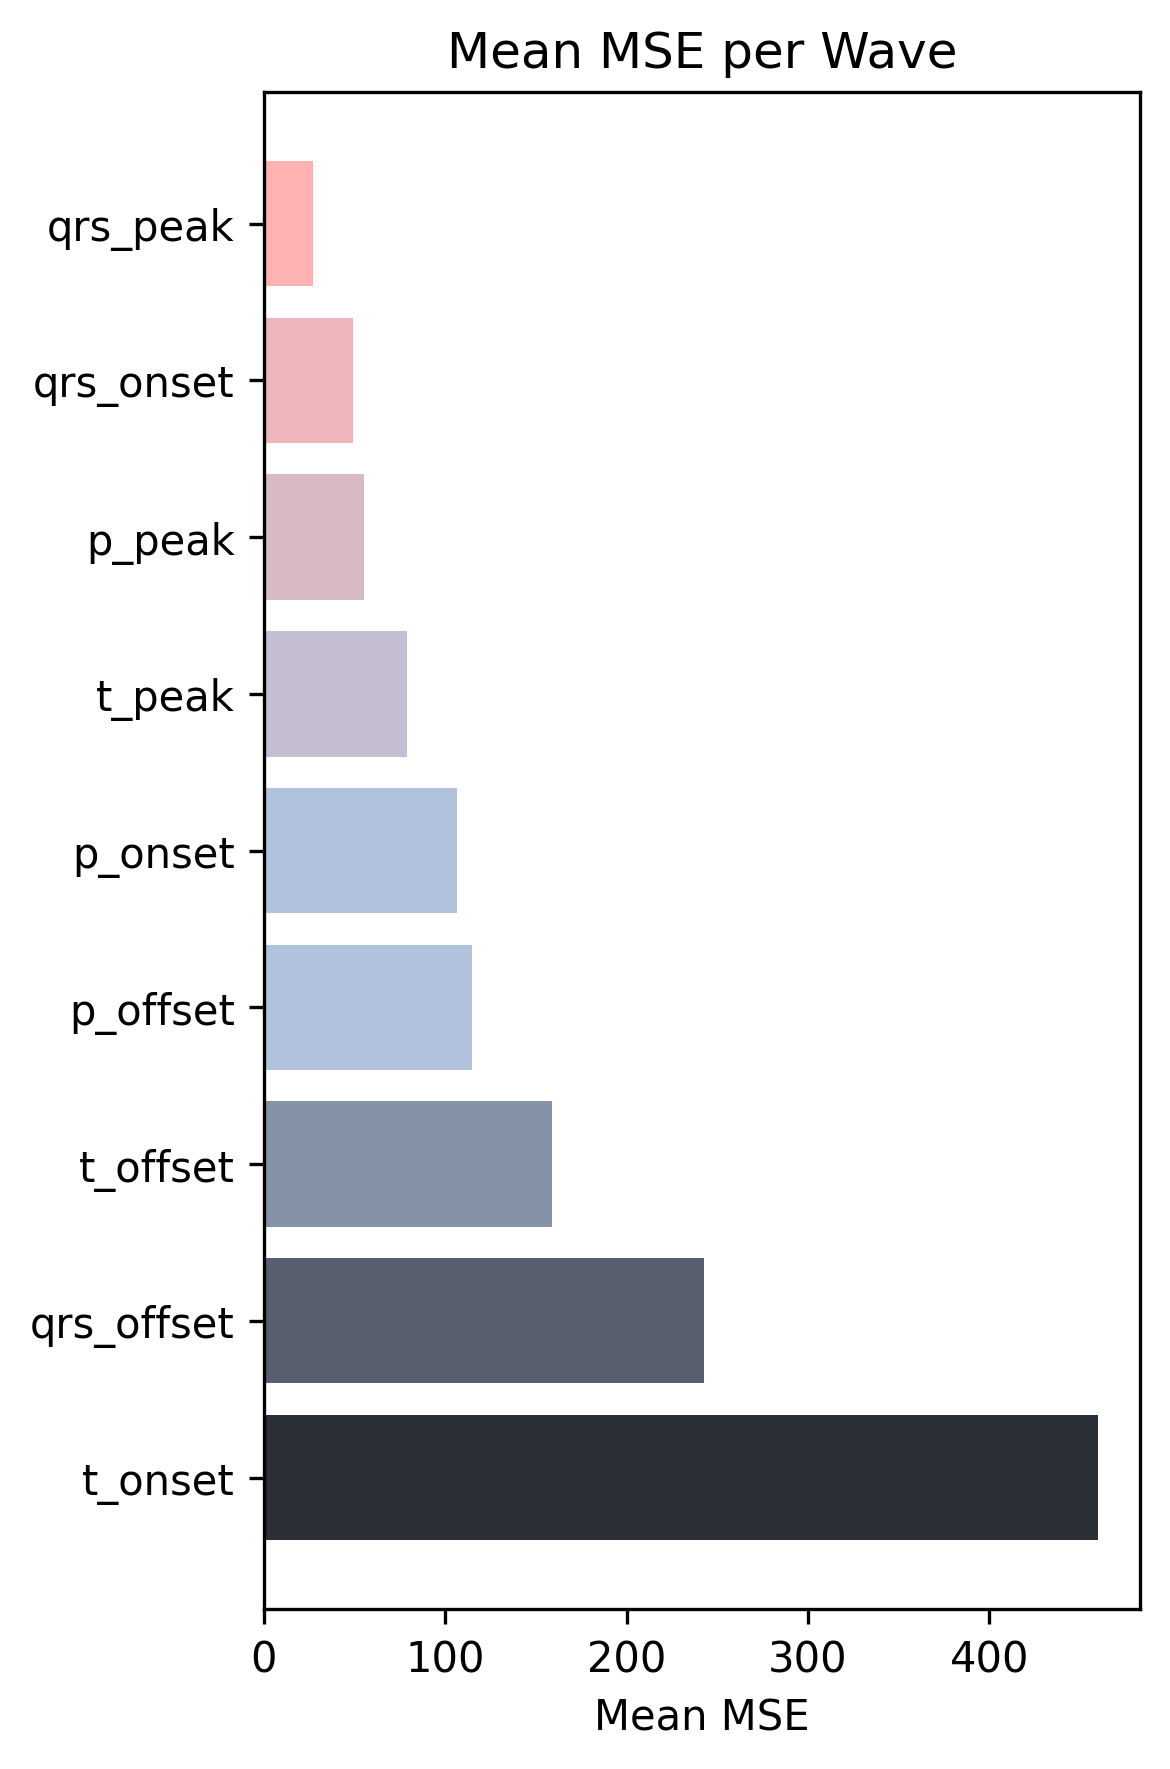

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

mse_sorted = mse_table_sorted.copy()
mse_sorted = mse_sorted.sort_values("mean_MSE", ascending=False)

colors_start = "#2b2f37"
colors_mid   = "#b1c2dd"
colors_end   = "#ffb2b2"

n = len(mse_sorted)
top = np.linspace(0, 0.5, n//2)
bottom = np.linspace(0.5, 1, n - n//2)
gradient_vals = np.concatenate([top, bottom])

cmap = mcolors.LinearSegmentedColormap.from_list("mse_cmap", [colors_start, colors_mid, colors_end])
bar_colors = cmap(gradient_vals)

plt.figure(figsize=(4, 6), dpi=300)
plt.barh(mse_sorted["wave"], mse_sorted["mean_MSE"], color=bar_colors, edgecolor=None)
plt.xlabel("Mean MSE")
plt.title("Mean MSE per Wave")
plt.tight_layout()
plt.show()

##### pres plots

In [95]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

wave_colors = {
    "p_onset":  "#cddbf4",
    "p_peak":   "#b1c2dd",
    "p_offset": "#93a8ca",

    "qrs_onset":  "#ffb2b2",
    "qrs_peak":   "#eab6be",
    "qrs_offset": "#d0bccb",

    "t_onset":  "#798499",
    "t_peak":   "#687284",
    "t_offset": "#515d6b",
}

def clean_wave_array(x):
    out = []
    if x is None:
        return out
    for v in x:
        if v is None:
            continue
        if isinstance(v, (list, np.ndarray)):
            out.extend(v)
        else:
            out.append(v)
    return [int(v) for v in out]

def plot_ecg_with_marks(
    ecg_id,
    beat_idx,
    df_detect,
    df_annot,
    data_path,
    pad=200
):
    record = wfdb.rdrecord(f"{data_path}/{ecg_id}")
    sig = record.p_signal[:, 1]

    det_qrs = clean_wave_array(
        df_detect.loc[df_detect["ecg_id"] == ecg_id, "qrs_peak"].values[0]
    )

    if len(det_qrs) < beat_idx + 3:
        print(f"ecg {ecg_id}: not enough detected beats")
        return

    start = max(det_qrs[beat_idx] - pad, 0)
    end   = min(det_qrs[beat_idx + 2] + pad, len(sig))

    fig, ax = plt.subplots(figsize=(18, 4))
    ax.plot(sig, color="black", lw=1)
    ax.set_xlim(start, end)
    ax.set_title(
        f"ecg {ecg_id}  | detected beats {beat_idx}, {beat_idx+1}, {beat_idx+2}"
    )

    added_labels = set()

    waves = [
        "p_onset","p_peak","p_offset",
        "qrs_onset","qrs_peak","qrs_offset",
        "t_onset","t_peak","t_offset"
    ]

    for wave in waves:
        color = wave_colors[wave]

        ann = clean_wave_array(
            df_annot.loc[df_annot["ecg_id"] == ecg_id, wave].values[0]
        )
        for pos in ann:
            if start <= pos <= end:
                ax.axvline(
                    pos, color=color, linestyle="--", alpha=0.9, linewidth=1.8
                )

        det = clean_wave_array(
            df_detect.loc[df_detect["ecg_id"] == ecg_id, wave].values[0]
        )
        xs = [p for p in det if start <= p <= end]
        ys = [sig[p] for p in xs]

        label = wave if wave not in added_labels else None
        ax.scatter(xs, ys, color=color, s=50, label=label)

        if label:
            added_labels.add(wave)

    ax.legend(loc="upper right", ncol=3)
    plt.tight_layout()
    plt.show()

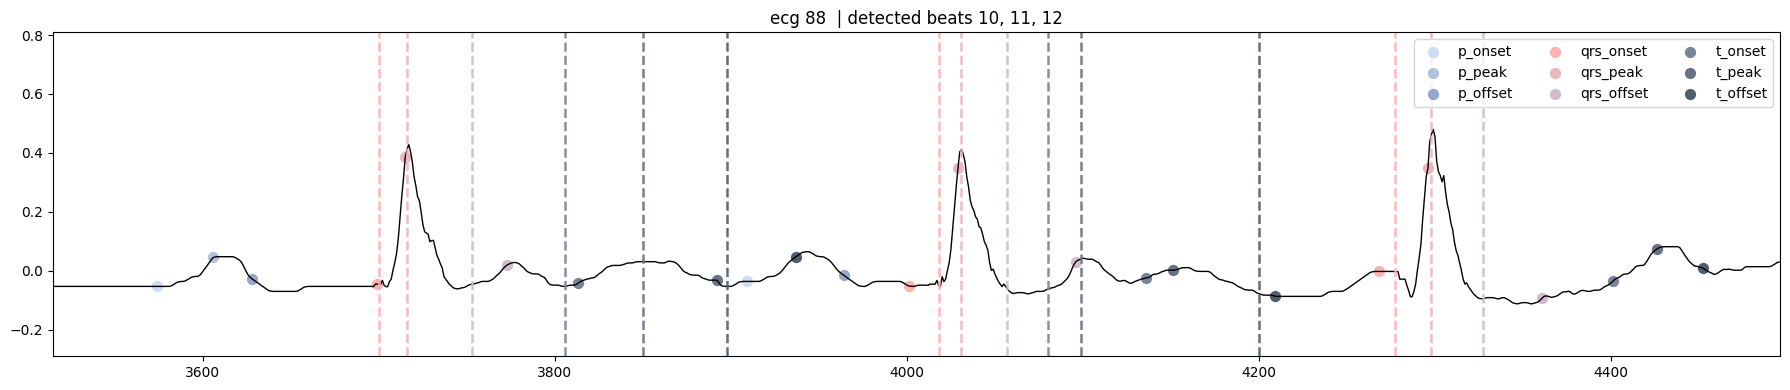

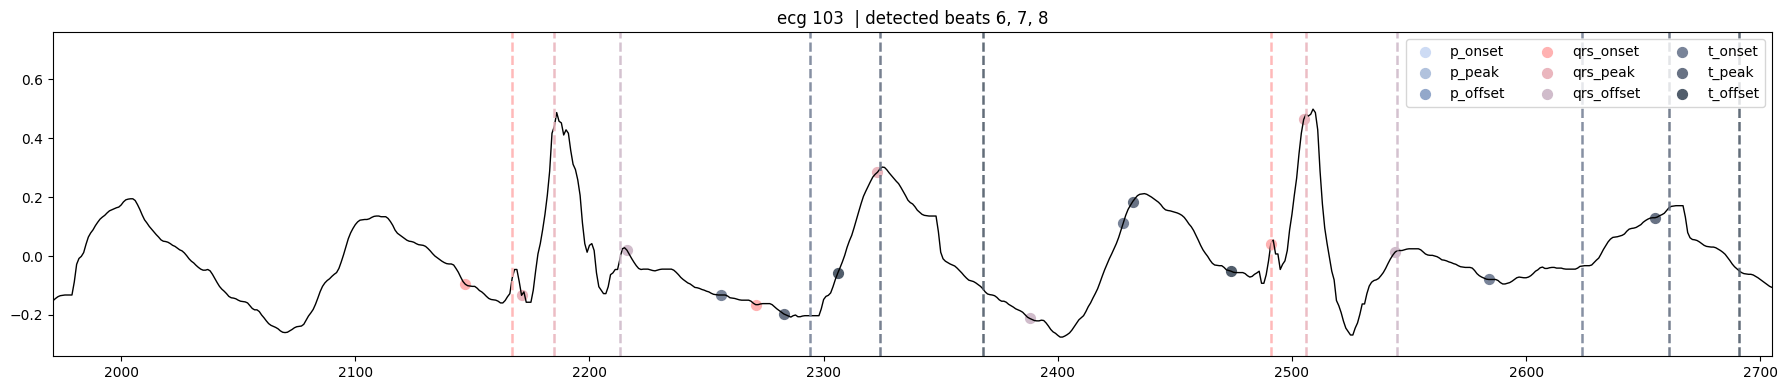

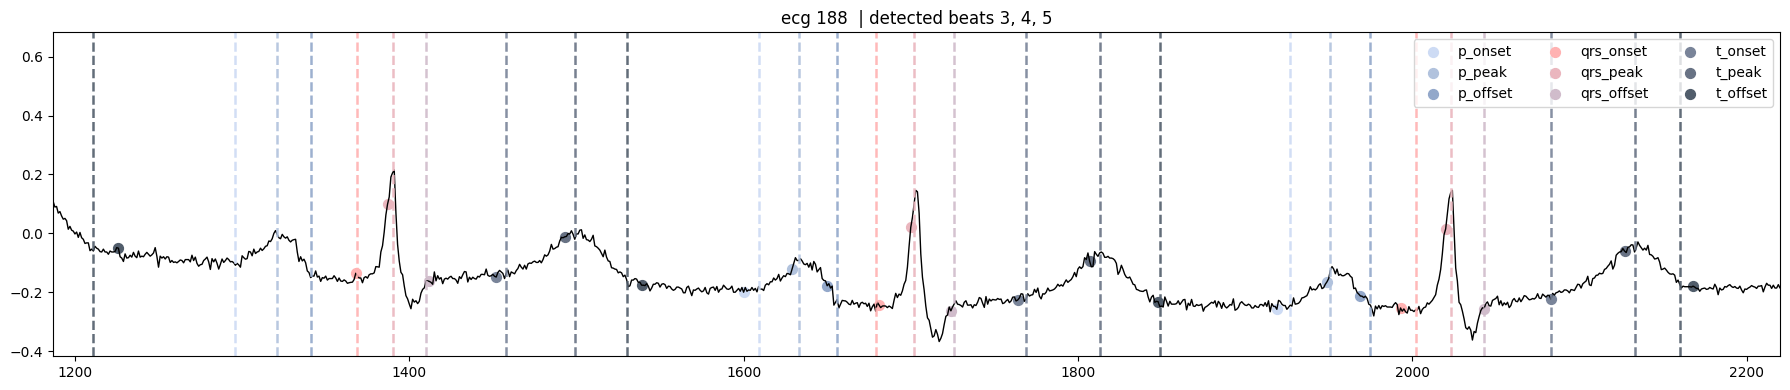

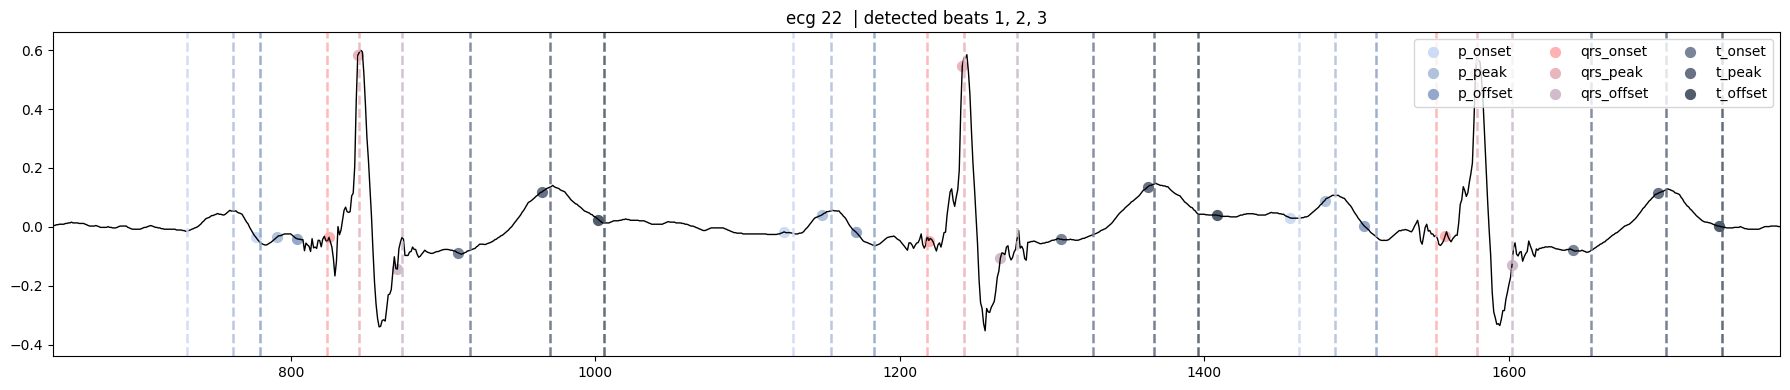

In [97]:
relevant_ecgs  = [88, 103, 188, 22]
relevant_beats = [10, 6, 3, 1]

for ecg_id, beat_idx in zip(relevant_ecgs, relevant_beats):
    plot_ecg_with_marks(
        ecg_id=ecg_id,
        beat_idx=beat_idx,
        df_annot=df_annot,
        df_detect=df_detections,
        data_path="ludb_data"
    )

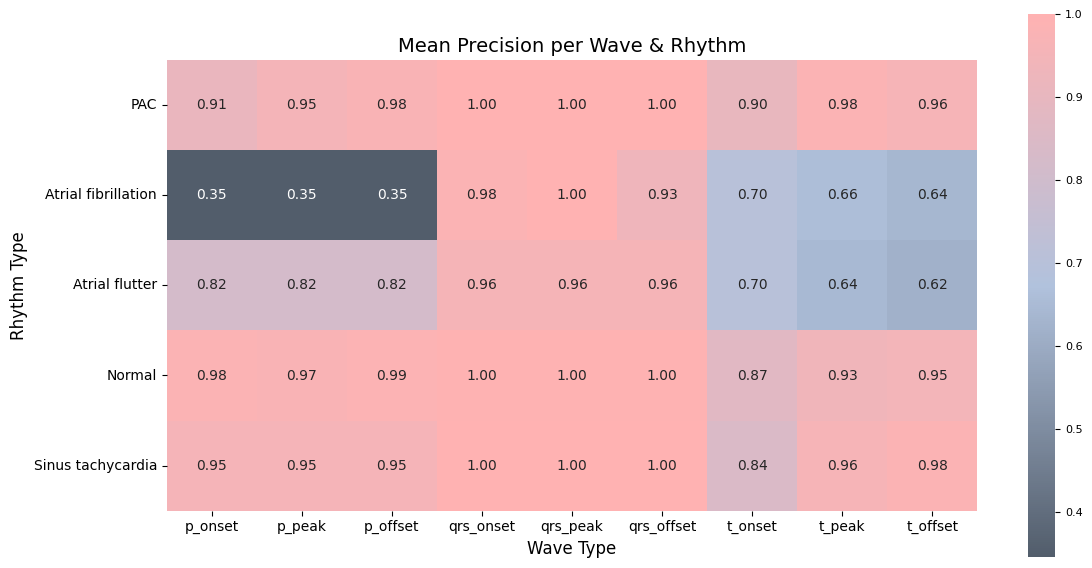

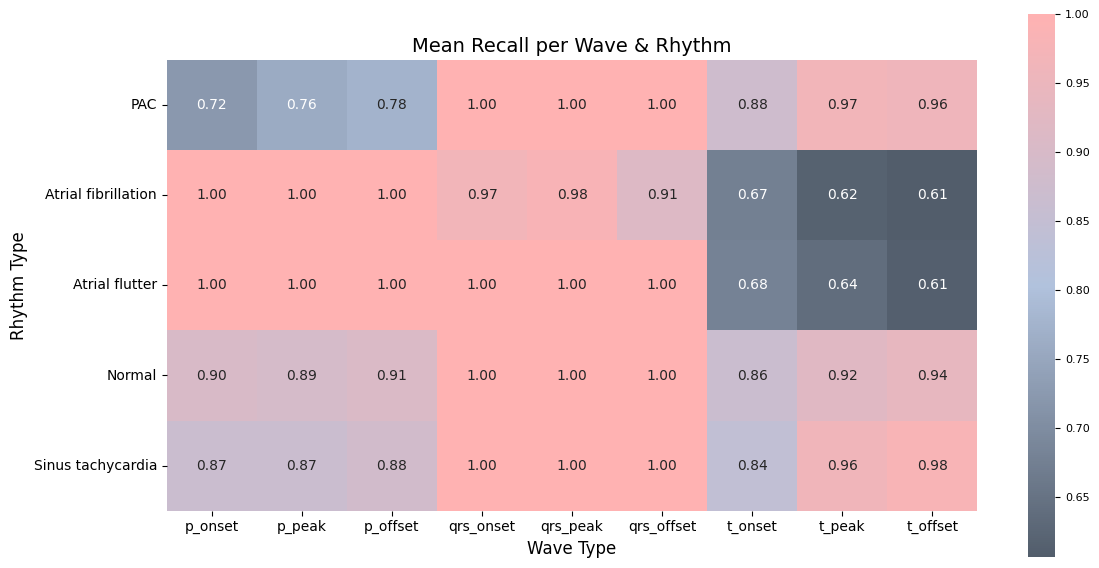

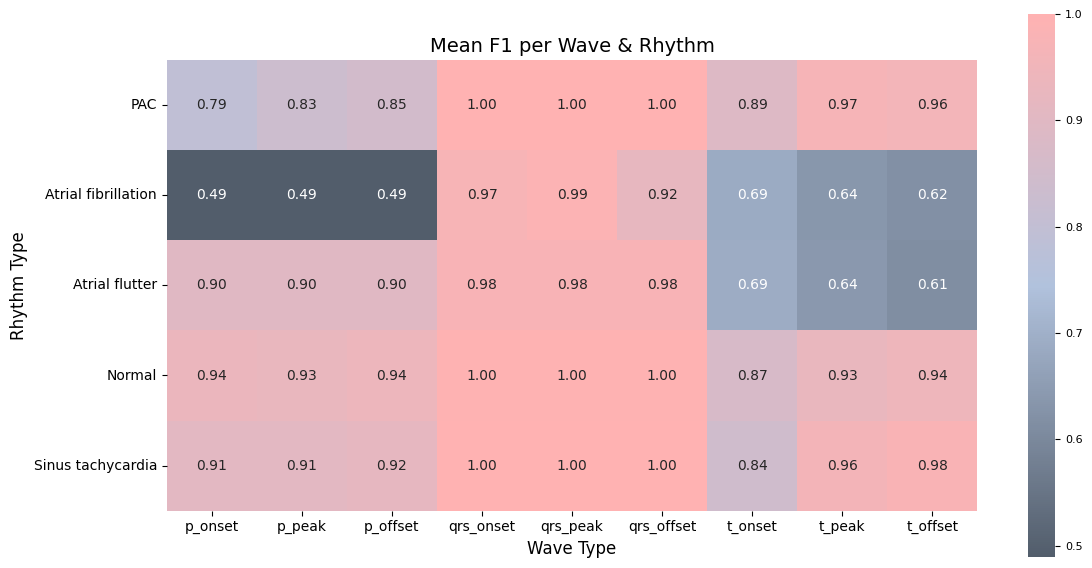

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

wave_types = ['p_onset','p_peak','p_offset',
              'qrs_onset','qrs_peak','qrs_offset',
              't_onset','t_peak','t_offset']

rhythms = df_validation['rhythm_type'].unique()

mean_prec = pd.DataFrame(index=rhythms, columns=wave_types, dtype=float)
mean_rec  = pd.DataFrame(index=rhythms, columns=wave_types, dtype=float)
mean_f1   = pd.DataFrame(index=rhythms, columns=wave_types, dtype=float)

for rhythm in rhythms:
    df_r = df_validation[df_validation['rhythm_type'] == rhythm]
    for wave in wave_types:
        mean_prec.loc[rhythm, wave] = df_r[f"{wave}_precision"].mean()
        mean_rec.loc[rhythm, wave]  = df_r[f"{wave}_recall"].mean()
        mean_f1.loc[rhythm, wave]   = df_r[f"{wave}_f1"].mean()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("blue_to_pink", ["#525d6b","#b1c2dd", "#ffb2b2"])

def plot_metric_heatmap(metric_df, metric_name):
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(
        metric_df,
        annot=True, fmt=".2f",
        cmap=custom_cmap,
        cbar=True,
        square=True
    )
    plt.title(f"Mean {metric_name} per Wave & Rhythm", fontsize=14)
    plt.xlabel("Wave Type", fontsize=12)
    plt.ylabel("Rhythm Type", fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_ylabel('', rotation=0)

    plt.tight_layout()
    plt.show()

for metric_df, metric_name in zip([mean_prec, mean_rec, mean_f1], ['Precision','Recall','F1']):
    plot_metric_heatmap(metric_df, metric_name)

#### PTB-XL

In [24]:
import wfdb
import os

def load_ptbxl_signal(ecg_id, data_dir="ptbxl_data", leads=("II", "V1")):
    """
    loads a PTB-XL record stored as:
        {ecg_id:05d}_hr

    returns:
        selected leads (default: lead II, V1)
        sampling frequency fs
    """

    fname = f"{ecg_id:05d}_hr"
    path = os.path.join(data_dir, fname)

    sig, fields = wfdb.rdsamp(path)
    fs = fields["fs"]

    leadII = sig[:, 1]   #  lead II
    leadV1 = sig[:, 6]   #  lead V1

    return leadII, leadV1, fs

In [ ]:
def process_ecg_pt(ecg_id, data_dir="ptbxl_data"):

    # load
    leadII, leadV1, fs = load_ptbxl_signal(ecg_id, data_dir)

    # detect
    detections = run_detection(leadII, leadV1, fs)

    # make detection table
    df_det = detections_to_table(ecg_id, detections)

    # metrics
    summary = compute_global_metrics_from_detections(
        detections=detections,
        fs=fs,
        signal=leadII
    )

    summary["ecg_id"] = ecg_id

    return df_det, summary

In [ ]:
all_det_tables2 = []
all_summaries2 = []

for ecg_id in recordings_ids:

    det_tab, summary = process_ecg_pt(ecg_id, data_dir="ptbxl_data")

    all_det_tables2.append(det_tab)
    all_summaries2.append(summary)

df_detections_pt = pd.concat(all_det_tables2, ignore_index=True)
df_summaries_pt = pd.concat(all_summaries2)


df_detections_pt["ecg_id"] = df_detections_pt["ecg_id"].astype(int)
df_detections_pt = df_detections_pt.sort_values("ecg_id").reset_index(drop=True)

In [ ]:
# map dict
rhythm_map2 = {}

for _id in [351, 4117, 4401, 4423, 4531, 4532, 4761, 5634, 5776, 7215, 7221, 7489, 8215, 9592, 10723, 11510, 12369, 12542, 12602, 12632, 12847, 12879, 12948, 13199, 13742, 13832, 14102, 14221, 14792, 14824, 14862, 15039, 15834, 16731, 16834, 17386, 17457, 18485, 18928, 18966, 19667, 19925, 19941, 19952, 19956, 20406, 20440, 21490]:
    rhythm_map2[_id] = "Atrial fibrillation"

for _id in [17, 18, 20, 23, 34, 449, 858, 1173, 1773, 2430, 2739, 3306, 4874, 5252, 5390, 6179, 6205, 7159, 7412, 7462, 7512, 7567, 7796, 8265, 8476, 10065, 10160, 10564, 10900, 10913, 10933, 10943, 10986, 11343, 11886, 12891, 12986, 13386, 13987, 14070, 14083, 15106, 15478, 15513, 16401, 17049, 17067, 17080, 17096, 17106, 17119, 19170, 19896, 19961, 20085, 21006]:
    rhythm_map2[_id] = "Atrial flutter"

for _id in [1670, 4408, 12767, 18178]:
    rhythm_map2[_id] = "Sinus tachycardia"

for _id in [964, 1168, 2692, 3500, 3638, 4118, 4478, 4552, 4595, 5103, 5434, 5967, 6130, 6809, 7235, 7907, 8746, 8974, 9458, 9642, 10317, 11589, 11948, 12028, 12391, 12750, 13561, 14109, 14433, 14899, 15588, 17931, 18082, 18526, 18813, 19049, 20149]:
    rhythm_map2[_id] = "PAC"

for _id in [3, 4, 5, 6, 9, 10, 13, 14, 16, 21, 24, 25, 29, 31, 33, 35, 36, 42, 43, 46, 47, 51, 53, 55, 56, 57, 58, 59, 61, 66, 67, 70, 71, 74, 75, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 99, 104, 109, 110, 111, 113, 114, 115, 117, 120, 121, 123, 124, 125, 126, 129, 147, 165, 174, 178, 183, 193, 196, 197, 198, 200, 201, 202, 203, 204, 206, 208, 221, 224, 227, 229, 230, 231, 239, 241, 244, 248, 252, 353, 354, 355, 356, 358, 359, 361, 364, 365, 366, 368, 370, 371, 372, 373, 374, 375, 376, 379, 387, 389, 391, 392, 393, 395, 397, 398, 401, 403, 406, 431, 432, 434, 435, 438, 451, 490, 506, 533, 580, 582, 587, 590, 638, 644, 662, 729, 753, 773, 776, 777, 779, 783, 784, 787, 790, 792, 793, 797, 808, 813, 815, 904, 905, 935, 958, 1018, 1054, 1190, 1230, 1247, 1254, 1257, 1259, 1263]:
    rhythm_map2[_id] = "Normal"

for _id in [1299, 1919, 2051, 3134, 3267, 3476, 6822, 7889, 8461, 9866, 10306, 12346, 12489, 12537, 13155, 13186, 14286, 14780, 15253, 16106, 16229, 16753, 19540, 21410]:
    rhythm_map2[_id] = "PSVT"

df_summaries_pt["rhythm_type"] = df_summaries_pt["ecg_id"].map(rhythm_map2).fillna("Other/Unknown")

In [ ]:
df_summaries_pt.head()

RR_mean    RR_std     RR_CV     RMSSD  PR_mean  PR_std     PR_CV  \
0  0.424400  0.008754  0.020628  0.009657    0.511   0.019  0.037182   
0  0.349600  0.002332  0.006672  0.001732      NaN     NaN       NaN   
0  0.384348  0.012930  0.033641  0.022692      NaN     NaN       NaN   
0  0.354583  0.001956  0.005517  0.002670      NaN     NaN       NaN   
0  0.374696  0.001921  0.005127  0.001859      NaN     NaN       NaN   

   P_presence_ratio   QT_mean  QRS_duration_std  SVT_score  Fwave_mean  \
0               0.1 -0.224100          0.022362   0.881435    0.088447   
0               0.0 -0.086696          0.032875   0.993328    0.123077   
0               0.0 -0.072783          0.065005   0.966359    0.040540   
0               0.0 -0.050583          0.048179   0.994483    0.041339   
0               0.0 -0.081111          0.044415   0.994873    0.069912   

   BaselineNoise_mean     HR_mean    HR_std  ecg_id rhythm_type  
0            0.004953  141.435531  2.884242    1299        PSVT  
0            0.018635  171.632357  1.145583    1919        PSVT  
0            0.020053  156.287762  5.329424    2051        PSVT  
0            0.040570  169.217851  0.935348    3134        PSVT  
0            0.004833  160.134166  0.820388    3267        PSVT

#### data merge ml validat

In [ ]:
# add dataset labels
df_summaries = df_summaries.copy()
df_summaries["dset"] = "ludb"

df_summaries_pt = df_summaries_pt.copy()
df_summaries_pt["dset"] = "ptbxl"

# union
df_all = pd.concat(
    [df_summaries, df_summaries_pt],
    axis=0,
    ignore_index=True
)

In [ ]:
df_all.head()

RR_mean    RR_std     RR_CV     RMSSD   PR_mean    PR_std     PR_CV  \
0  0.829400  0.061300  0.073908  0.094796  0.871500  0.105961  0.121585   
1  0.543600  0.096734  0.177950  0.141837  0.683000  0.070197  0.102778   
2  0.886889  0.149860  0.168972  0.224872  0.984333  0.165156  0.167785   
3  0.954000  0.364538  0.382115  0.693093  1.024800  0.372309  0.363299   
4  0.937333  0.185117  0.197494  0.273327  1.064400  0.199429  0.187363   

   P_presence_ratio   QT_mean  QRS_duration_std  SVT_score  Fwave_mean  \
0          0.800000 -0.488800          0.066010   0.185218    0.075026   
1          0.400000 -0.290800          0.044958   0.493230    0.040129   
2          0.666667 -0.629556          0.026382   0.277009    0.099722   
3          0.555556 -0.552667          0.043973   0.274615    0.089768   
4          0.555556 -0.590889          0.037566   0.356669    0.056331   

   BaselineNoise_mean     HR_mean     HR_std  ecg_id          rhythm_type  \
0            0.033093   72.768471   5.805299       8  Atrial fibrillation   
1            0.003095  113.857468  19.952559      38  Atrial fibrillation   
2            0.020504   69.535028  11.211117      44  Atrial fibrillation   
3            0.003689   71.338251  23.441817      51  Atrial fibrillation   
4            0.009527   66.569563  13.265611      83  Atrial fibrillation   

   dset  
0  ludb  
1  ludb  
2  ludb  
3  ludb  
4  ludb

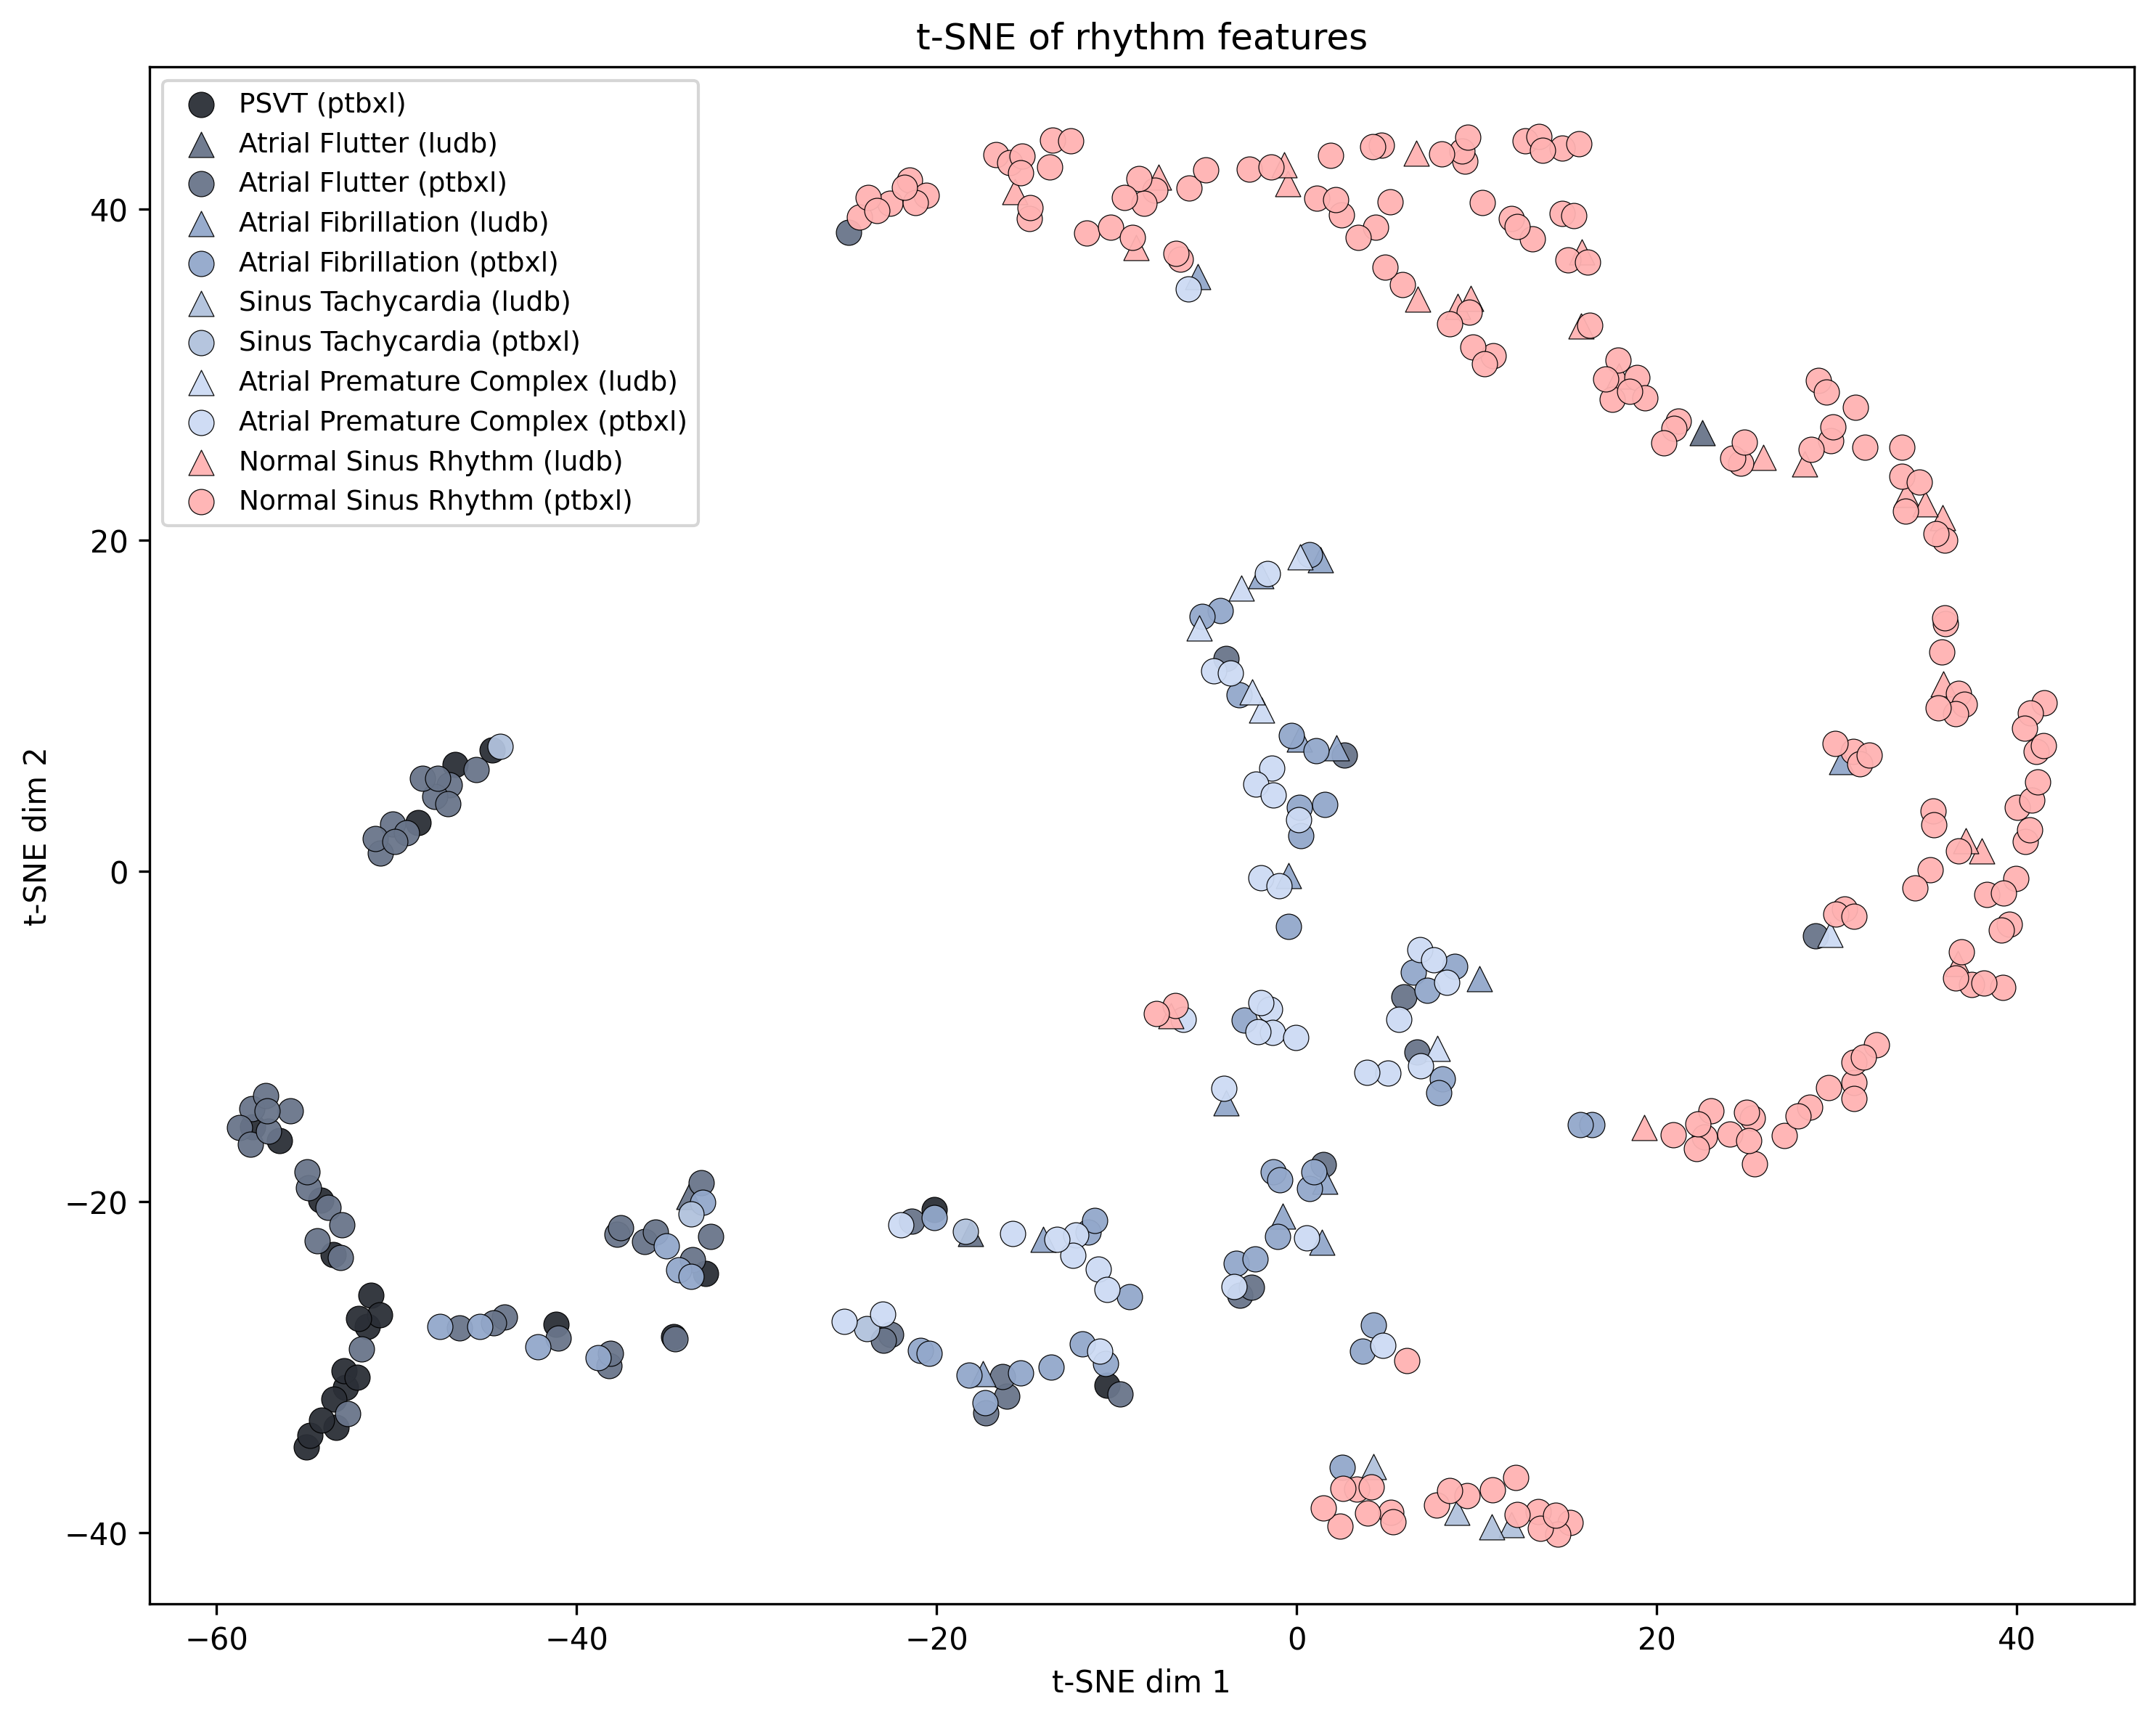

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df = df_all.copy()

y = df["rhythm_type"].values
dset = df["dset"].values

# fill nones with 0s
X_df = df.drop(columns=["rhythm_type", "ecg_id", "dset"])
X = X_df.fillna(0).values

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=8.2,
    learning_rate="auto",
    init="random",
    random_state=43
)

X_tsne = tsne.fit_transform(X)

label_map = {
    "PSVT": "PSVT",
    "Atrial flutter": "Atrial Flutter",
    "Atrial fibrillation": "Atrial Fibrillation",
    "Sinus tachycardia": "Sinus Tachycardia",
    "PAC": "Atrial Premature Complex",
    "Normal": "Normal Sinus Rhythm",
}

classes = list(label_map.keys())

custom_palette = [
    "#2b2f37",
    "#69758a",
    "#93a8cb",
    "#b1c2dd",
    "#cddbf4",
    "#ffb2b2",
]

color_map = {cls: custom_palette[i] for i, cls in enumerate(classes)}

marker_map = {
    "ludb": "^",
    "ptbxl": "o",
}

plt.figure(figsize=(10, 8), dpi=300)

for cls in classes:
    for ds in ["ludb", "ptbxl"]:
        idx = (y == cls) & (dset == ds)
        if not np.any(idx):
            continue

        plt.scatter(
            X_tsne[idx, 0],
            X_tsne[idx, 1],
            color=color_map[cls],
            marker=marker_map[ds],
            s=70,
            alpha=0.95,
            edgecolors="black",
            linewidths=0.3,
            label=f"{label_map[cls]} ({ds})"
        )

plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("t-SNE of rhythm features")

plt.legend(
    frameon=True,
    fontsize=9,
    markerscale=1,
    handletextpad=0.4
)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df = df_all.copy()

y = df["rhythm_type"].values
X_df = df.drop(columns=["rhythm_type", "ecg_id", "dset"], errors="ignore")

# fill nones with 0
X = X_df.fillna(0).values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


# random forest classifier
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# predictions + accuracy
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print("\nrandom forest accuracy")
print(f"{acc:.4f}")

print("\nclassification report")
print(classification_report(y_test, y_pred))

# feature importance
importances = rf.feature_importances_
feat_names = X_df.columns

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\n feature importance ranking")
print(fi)


random forest accuracy
0.7959

classification report
                     precision    recall  f1-score   support

Atrial fibrillation       0.67      0.88      0.76        16
     Atrial flutter       0.69      0.73      0.71        15
             Normal       0.94      0.96      0.95        48
                PAC       0.57      0.36      0.44        11
               PSVT       0.60      0.50      0.55         6
  Sinus tachycardia       0.00      0.00      0.00         2

           accuracy                           0.80        98
          macro avg       0.58      0.57      0.57        98
       weighted avg       0.77      0.80      0.78        98


 feature importance ranking
               feature  importance
14              HR_std    0.102619
3                RMSSD    0.099762
2                RR_CV    0.089682
13             HR_mean    0.081952
0              RR_mean    0.080405
1               RR_std    0.078664
8              QT_mean    0.070170
12  BaselineNoise_mean  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### pres plots

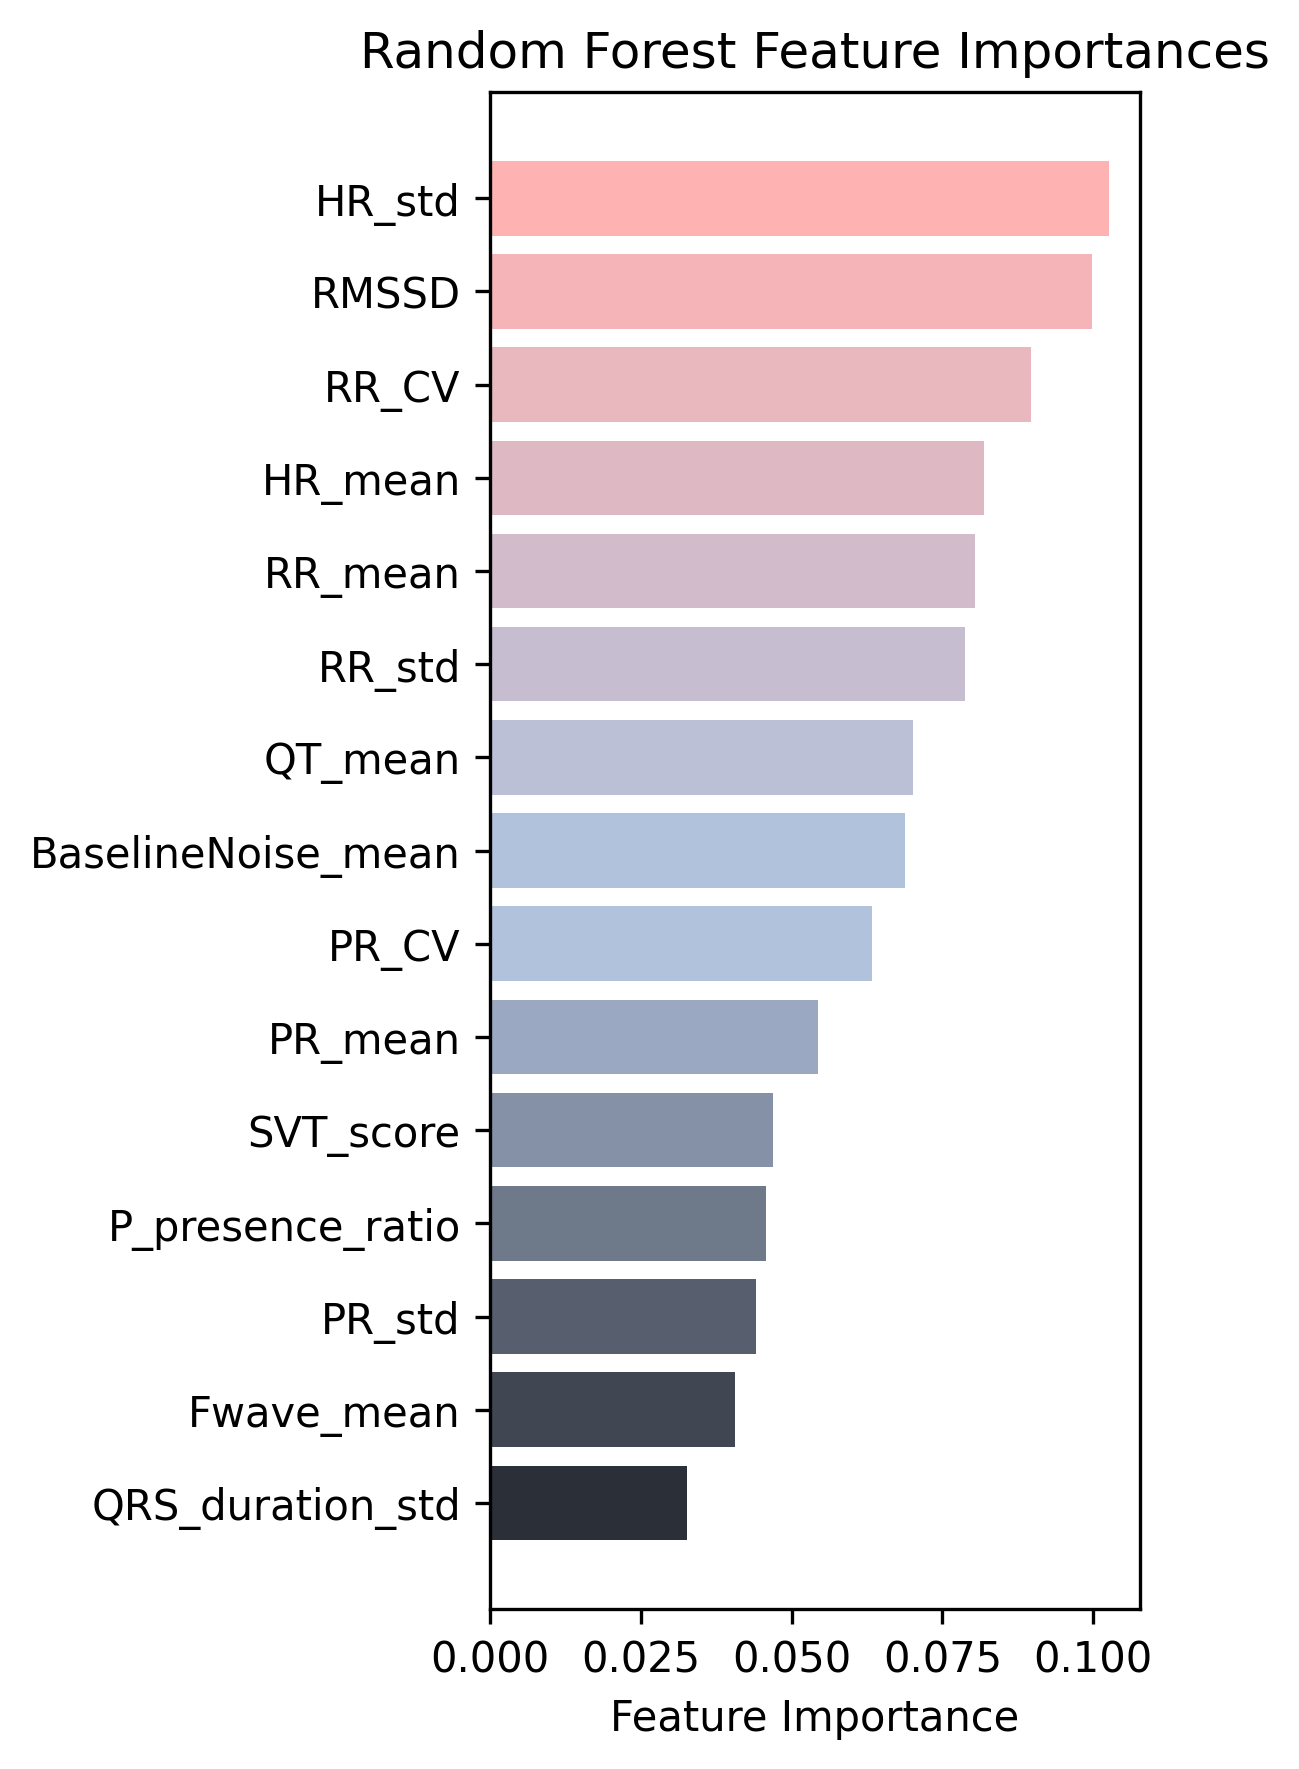

In [ ]:
import matplotlib.colors as mcolors

fi_sorted = fi.sort_values("importance", ascending=True)

colors_start = "#2b2f37"
colors_mid   = "#b1c2dd"
colors_end   = "#ffb2b2"

n = len(fi_sorted)

top = np.linspace(0, 0.5, n//2)
bottom = np.linspace(0.5, 1, n - n//2)
gradient_vals = np.concatenate([top, bottom])

cmap = mcolors.LinearSegmentedColormap.from_list(
    "feat_cmap", [colors_start, colors_mid, colors_end]
)

bar_colors = cmap(gradient_vals)

plt.figure(figsize=(4, 6), dpi=300)
plt.barh(fi_sorted["feature"], fi_sorted["importance"], color=bar_colors, edgecolor=None)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


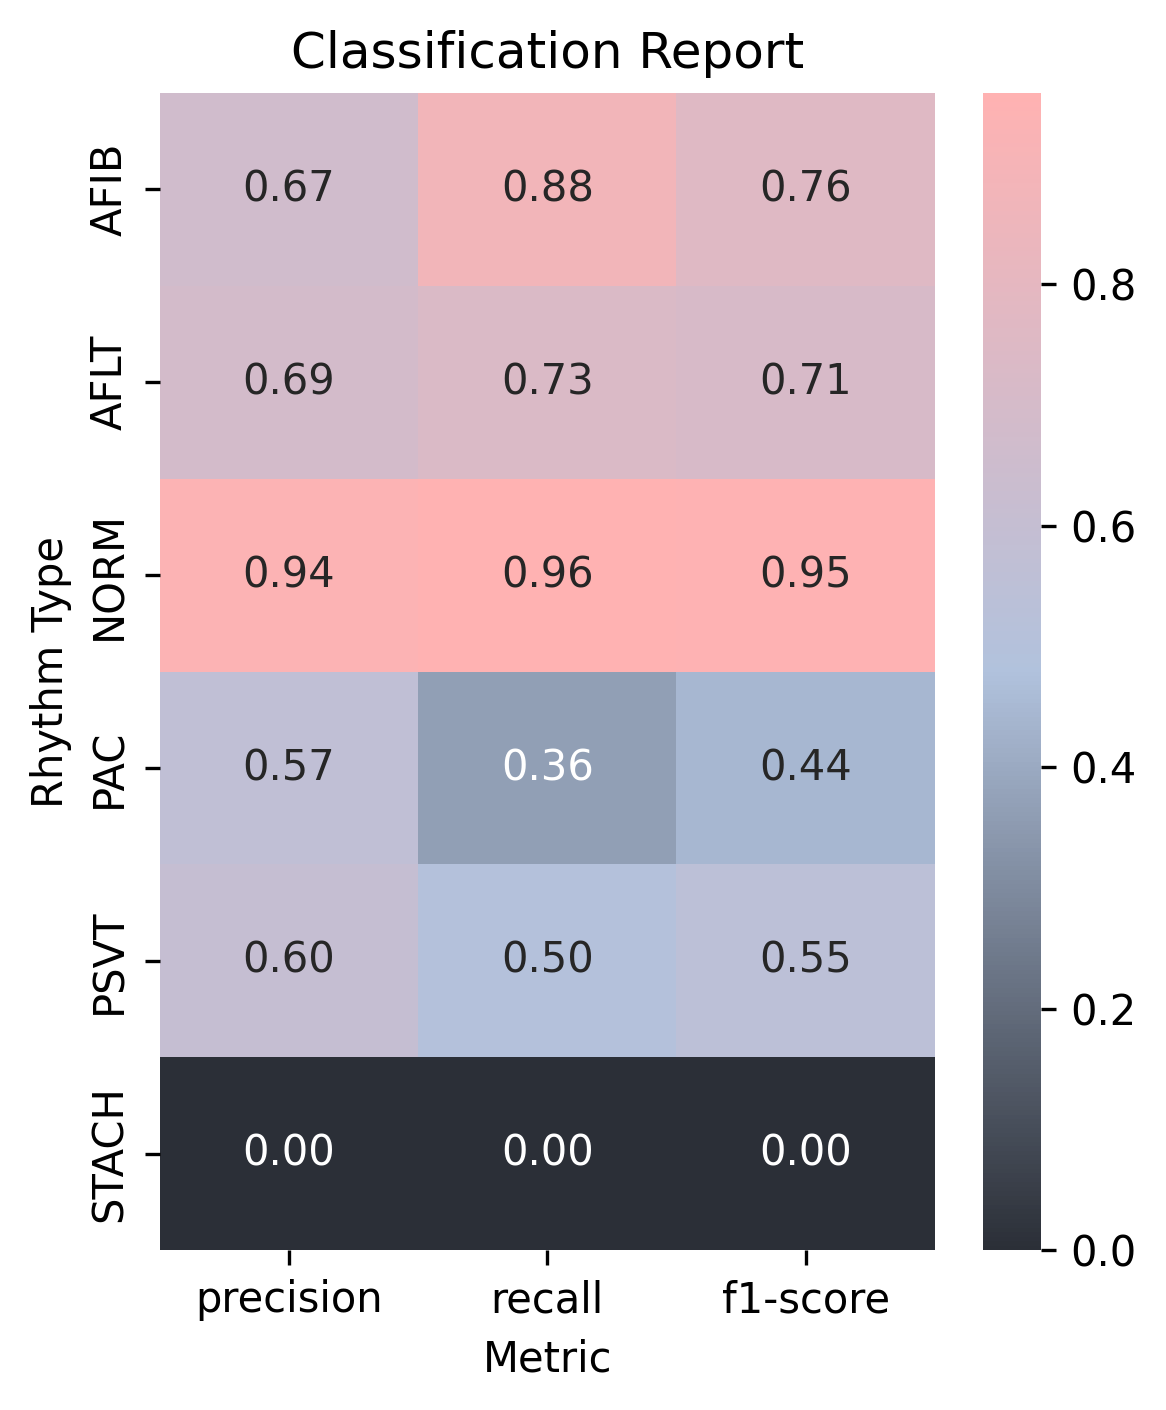

In [ ]:
import seaborn as sns

report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics = ["precision", "recall", "f1-score"]

rhythms = [k for k in report_dict.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]

data = pd.DataFrame({
    m: [report_dict[r][m] for r in rhythms]
    for m in metrics
}, index=rhythms)


colors_start = "#2b2f37"
colors_mid   = "#b1c2dd"
colors_end   = "#ffb2b2"

norm = plt.Normalize(data.values.min(), data.values.max())
cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
    "heatmap_cmap", [colors_start, colors_mid, colors_end]
)

label_map = {
    "PSVT": "PSVT",
    "Atrial flutter": "AFLT",
    "Atrial fibrillation": "AFIB",
    "Sinus tachycardia": "STACH",
    "PAC": "PAC",
    "Normal": "NORM",
}

data.rename(index=label_map, inplace=True)

plt.figure(figsize=(4, len(rhythms)*0.8), dpi=300)
sns.heatmap(
    data,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar=True,
    linewidths=0,
    linecolor="gray",
    norm=norm
)
plt.title("Classification Report")
plt.ylabel("Rhythm Type")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

#### partial annotation from ecg from image

In [98]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

#files uploaded and metrics computed manually

def ecg_from_image(
    img_path,
    true_duration=5.0,      # seconds
    mm_per_s=25.0,          # chart speed
    mm_per_mv=10.0,         # amplitude scale
    fs_target=250.0,        # target resample rate
    plot=True
):

    # load image
    img = Image.open(img_path).convert("RGBA")
    arr = np.array(img)

    alpha = arr[:, :, 3]
    height, width = alpha.shape

    # extract midline of stroke
    signal_px = []
    for x in range(width):
        ys = np.where(alpha[:, x] > 0)[0]
        if len(ys) > 0:
            center = (ys.min() + ys.max()) / 2.0
            signal_px.append(center)
        else:
            signal_px.append(np.nan)

    signal_px = np.array(signal_px)
    signal_px = height - signal_px
    signal_px = signal_px[~np.isnan(signal_px)]

    N = len(signal_px)
    # reverse-engineer px/mm
    px_per_mm = N / (true_duration * mm_per_s)

    # amplitude calibration (pixels → mV)
    signal_mV = (signal_px / px_per_mm) * (1.0 / mm_per_mv)

    # time axis
    px_per_second = px_per_mm * mm_per_s
    dt = 1.0 / px_per_second
    t = np.arange(len(signal_mV)) * dt

    # resample
    N_target = int(true_duration * fs_target)
    signal_resampled = resample(signal_mV, N_target)
    t_resampled = np.linspace(0, true_duration, N_target)

    # plot
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t_resampled, signal_resampled, linewidth=1)
        plt.xlabel("time (s)")
        plt.ylabel("amplitude (mV)")
        plt.title(f"Calibrated ECG ({int(fs_target)} Hz)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return t_resampled, signal_resampled

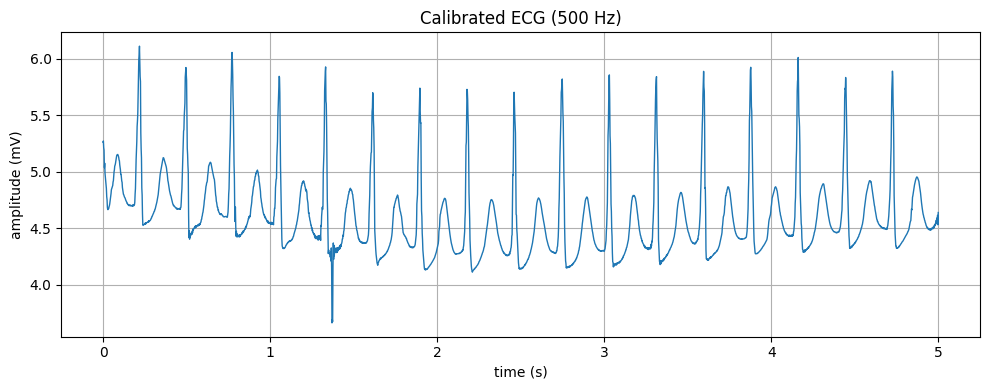

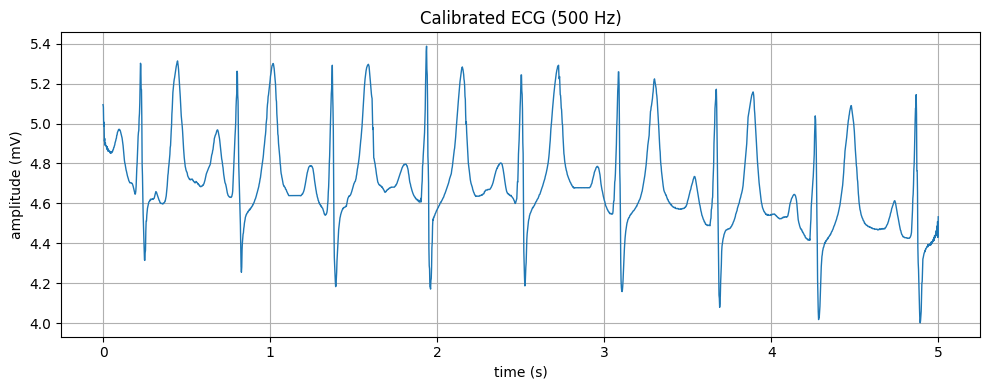

In [100]:
t_psvt, ecg_psvt = ecg_from_image("psvt.PNG", fs_target=500)
t_norm, ecg_norm = ecg_from_image("norm.PNG", fs_target=500)

##### run algo

In [101]:
def run_detection_img(leadII, fs):

    # wavelet + QRS
    details = atrous_decompose_aligned(leadII, 4)
    d2 = details[1]
    d3 = details[2]

    R, _ = qrs_detect_online(d2, d3, fs, 0.5)

    delineations = delineate_all_qrs(d2, R, fs)

    # P + T waves
    p_waves, t_waves = [], []

    for i in range(1, len(delineations)):
        qrs_peak   = delineations[i]["peak"]
        qrs_onset  = delineations[i]["onset"]
        prev_peak  = delineations[i-1]["peak"]
        prev_offset = delineations[i-1]["offset"]

        # P-wave delineation
        pw = delineate_p_wave(d3, qrs_onset, qrs_peak, prev_peak, fs)

        # T-wave delineation
        tw = delineate_t_wave(d3,
                              qrs_off_prev = prev_offset,
                              qrs_peak_curr = qrs_peak,
                              prev_peak = prev_peak,
                              fs = fs,
                              )

        p_waves.append(pw)
        t_waves.append(tw)

    return {
        "qrs_peak": R,
        "qrs_onset": [d["onset"] for d in delineations],
        "qrs_offset": [d["offset"] for d in delineations],
        "p_peak": [pw["peak"] if pw else None for pw in p_waves],
        "p_onset": [pw["onset"] if pw else None for pw in p_waves],
        "p_offset": [pw["offset"] if pw else None for pw in p_waves],
        "t_peak": [tw["peak"] if tw else None for tw in t_waves],
        "t_onset": [tw["onset"] if tw else None for tw in t_waves],
        "t_offset": [tw["offset"] if tw else None for tw in t_waves],
    }

def process_ecg_from_image(ecg, fs_target=500):

    leadII = ecg
    fs = fs_target

    # detect
    detections = run_detection_img(leadII, fs)

    # make detection table
    df_det = pd.DataFrame({
        "qrs_peak":   [detections.get("qrs_peak")],
        "qrs_onset":  [detections.get("qrs_onset")],
        "qrs_offset": [detections.get("qrs_offset")],

        "p_peak":   [detections.get("p_peak")],
        "p_onset":  [detections.get("p_onset")],
        "p_offset": [detections.get("p_offset")],

        "t_peak":   [detections.get("t_peak")],
        "t_onset":  [detections.get("t_onset")],
        "t_offset": [detections.get("t_offset")],
    })


    # metrics
    summary = compute_global_metrics_from_detections(
        detections=detections,
        fs=fs,
        signal=leadII
    )

    return df_det, summary

In [102]:
# psvt signal
df_psvt, summary_psvt = process_ecg_from_image(
    ecg = ecg_psvt,
    fs_target=500
)

# normal/stach signal
df_norm, summary_norm = process_ecg_from_image(
    ecg = ecg_norm,
    fs_target=500
)

##### pres plots

In [103]:
wave_colors = {
    "p_onset":  "#cddbf4",
    "p_peak":   "#b1c2dd",
    "p_offset": "#93a8ca",

    "qrs_onset":  "#ffb2b2",
    "qrs_peak":   "#eab6be",
    "qrs_offset": "#d0bccb",

    "t_onset":  "#798499",
    "t_peak":   "#687284",
    "t_offset": "#515d6b",
}

def clean_wave_array(x):
    out = []
    if x is None:
        return out
    for v in x:
        if v is None:
            continue
        if isinstance(v, (list, np.ndarray)):
            out.extend(v)
        else:
            out.append(v)
    return [int(v) for v in out]


def plot_ecg_detect_only_img(
    ecg,
    df_det,
    beat_idx=5,
    pad=200,
    title="ECG detection"
):

    sig = ecg

    det_qrs = clean_wave_array(df_det.loc[0, "qrs_peak"])

    if len(det_qrs) < beat_idx + 3:
        print("not enough detected beats 😭")
        return

    start = max(det_qrs[beat_idx] - pad, 0)
    end   = min(det_qrs[beat_idx + 2] + pad, len(sig))

    fig, ax = plt.subplots(figsize=(18, 4))
    ax.plot(sig, color="black", lw=1)
    ax.set_xlim(start, end)
    ax.set_title(title)

    added_labels = set()

    waves = [
        "p_onset","p_peak","p_offset",
        "qrs_onset","qrs_peak","qrs_offset",
        "t_onset","t_peak","t_offset"
    ]

    for wave in waves:
        color = wave_colors[wave]

        det = clean_wave_array(df_det.loc[0, wave])

        xs = [p for p in det if start <= p <= end]
        ys = [sig[p] for p in xs]

        label = wave if wave not in added_labels else None
        ax.scatter(xs, ys, color=color, s=45, label=label, zorder=5)

        if label:
            added_labels.add(wave)

    ax.legend(loc="upper right", ncol=3)
    plt.tight_layout()
    plt.show()

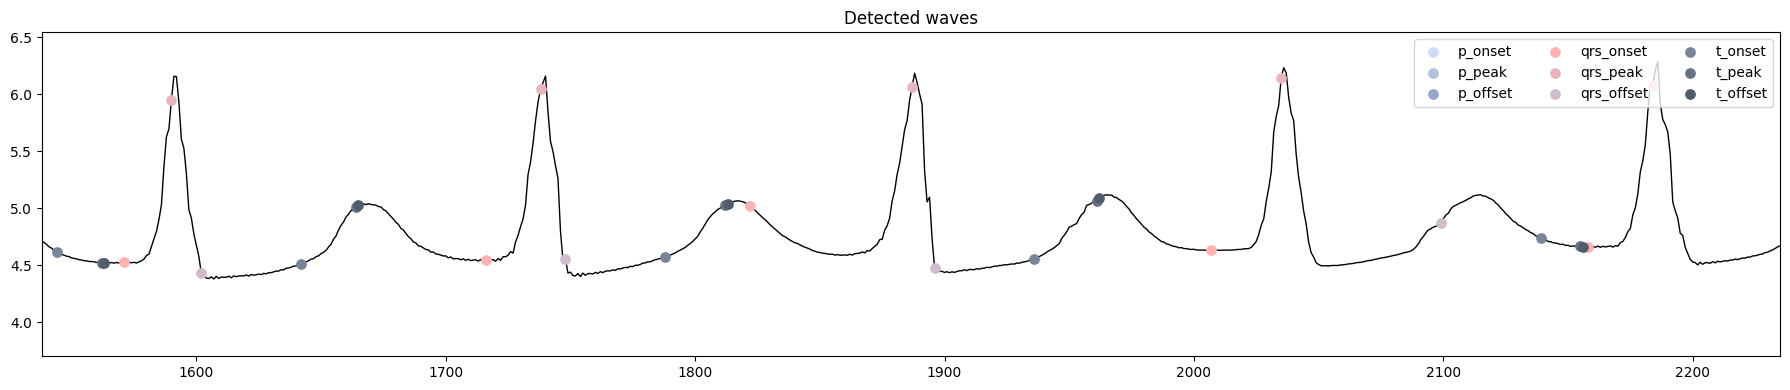

In [331]:
plot_ecg_detect_only_img(
    ecg=ecg_psvt,
    df_det=df_psvt,
    beat_idx=10,
    title="Detected waves"
)

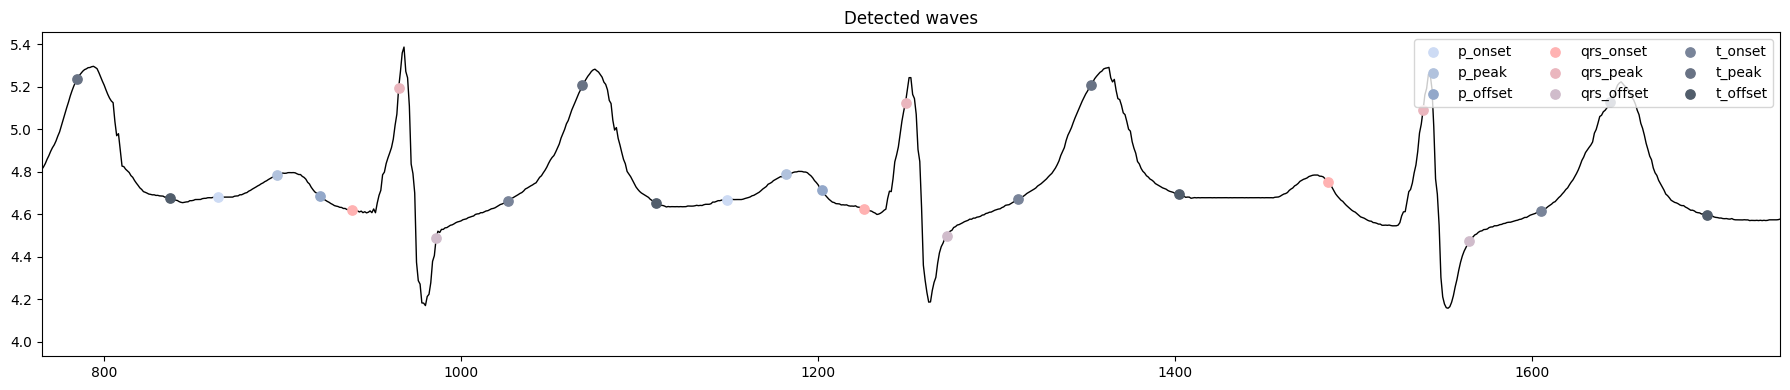

In [104]:
plot_ecg_detect_only_img(
    ecg=ecg_norm,
    df_det=df_norm,
    beat_idx=2,
    title="Detected waves"
)

##### validation

In [105]:
psvt_ref = dict(HR=213, QT=214, QTc=403, QRS=62)
norm_ref = dict(HR=100, QT=326, QTc=420, QRS=72)

In [106]:
def check_against_reference(summary, ref, name):
    print(f"\n checking {name} \n")

    print(f"HR: detected={summary['HR_mean']:.1f} bpm | ref={ref['HR']} bpm")

    print(f"QT: detected={summary['QT_mean']:.1f} ms | ref={ref['QT']} ms")

    if "RR_mean" in summary:
        QTc = summary["QT_mean"] / np.sqrt(summary["RR_mean"])
        print(f"QTc (Bazett): detected={QTc:.1f} ms | ref={ref['QTc']} ms")

    print(f"QRS duration (mean): detected={summary['QRS_duration_mean']:.1f} ms | ref={ref['QRS']} ms")

    print(f"P presence ratio: {summary['P_presence_ratio']:.2f}")

In [107]:
def get_scalar(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return x[0]
    if hasattr(x, "iloc"):
        return x.iloc[0]
    return x

def check_against_reference(summary, ref, name):
    # get scalar values
    HR = get_scalar(summary["HR_mean"])
    QT_sec = get_scalar(summary["QT_mean"])
    RR_sec = get_scalar(summary["RR_mean"])
    QRS_sec = get_scalar(summary["QRS_duration_std"])
    P_ratio = get_scalar(summary["P_presence_ratio"])

    # convert seconds → milliseconds
    QT = QT_sec * 1000 if QT_sec is not None else None
    QRS = QRS_sec * 1000 if QRS_sec is not None else None

    # QTc using Bazett formula: QTc = QT / sqrt(RR)
    QTc = QT / np.sqrt(RR_sec) if QT_sec is not None and RR_sec is not None else None

    print(f"\n checking {name} \n")
    print(f"HR:   detected = {HR:.1f} bpm | ref = {ref['HR']} bpm")
    print(f"QT:   detected = {QT:.1f} ms  | ref = {ref['QT']} ms")
    print(f"QTc:  detected = {QTc:.1f} ms | ref = {ref['QTc']} ms")
    print(f"QRS:  detected = {QRS:.1f} ms | ref = {ref['QRS']} ms")
    print(f"P presence ratio: {P_ratio:.2f}")

In [108]:
check_against_reference(summary_psvt, psvt_ref, "PSVT")
check_against_reference(summary_norm, norm_ref, "NORMAL")


 checking PSVT 

HR:   detected = 212.9 bpm | ref = 213 bpm
QT:   detected = 401.9 ms  | ref = 214 ms
QTc:  detected = 756.9 ms | ref = 403 ms
QRS:  detected = 27.6 ms | ref = 62 ms
P presence ratio: 0.00

 checking NORMAL 

HR:   detected = 104.1 bpm | ref = 100 bpm
QT:   detected = 374.3 ms  | ref = 326 ms
QTc:  detected = 493.1 ms | ref = 420 ms
QRS:  detected = 25.3 ms | ref = 72 ms
P presence ratio: 0.67
